## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


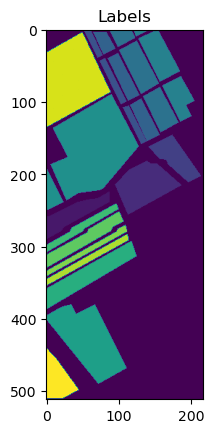

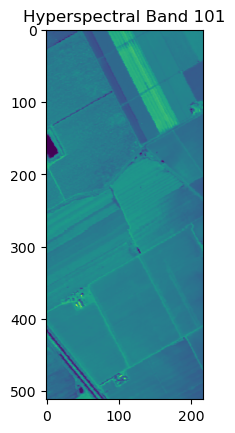

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53409 samples
	shape (53409, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(640, 5, 5, 204)
(80, 5, 5, 204)
(53409, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1570, PSNR: 7.1534


	 Training Batch [200/677], Loss: 0.0932, PSNR: 9.4820


	 Training Batch [400/677], Loss: 0.0463, PSNR: 12.4968


	 Training Batch [600/677], Loss: 0.0251, PSNR: 15.1220


Epoch [1/50] Training Loss: 0.0686, PSNR: 11.5164
	[Val]   Batch [1/170] Loss: 0.0213, PSNR: 15.7982
	[Val]   Batch [10/170] Loss: 0.0210, PSNR: 15.9624
	[Val]   Batch [20/170] Loss: 0.0211, PSNR: 15.8668
	[Val]   Batch [30/170] Loss: 0.0219, PSNR: 15.6503
	[Val]   Batch [40/170] Loss: 0.0219, PSNR: 15.7346


	[Val]   Batch [50/170] Loss: 0.0207, PSNR: 15.9505
	[Val]   Batch [60/170] Loss: 0.0217, PSNR: 15.8115
	[Val]   Batch [70/170] Loss: 0.0212, PSNR: 15.9049
	[Val]   Batch [80/170] Loss: 0.0216, PSNR: 15.7143
	[Val]   Batch [90/170] Loss: 0.0209, PSNR: 15.9610


	[Val]   Batch [100/170] Loss: 0.0210, PSNR: 15.8773
	[Val]   Batch [110/170] Loss: 0.0211, PSNR: 15.8664
	[Val]   Batch [120/170] Loss: 0.0198, PSNR: 14.1788
	[Val]   Batch [130/170] Loss: 0.0209, PSNR: 15.9616
	[Val]   Batch [140/170] Loss: 0.0205, PSNR: 16.0200


	[Val]   Batch [150/170] Loss: 0.0220, PSNR: 15.7559
	[Val]   Batch [160/170] Loss: 0.0216, PSNR: 15.7995
	[Val]   Batch [170/170] Loss: 0.0224, PSNR: 15.0846
Epoch [1/50] Validation Loss: 0.0213, PSNR: 15.7863

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0213, PSNR: 15.8626


	 Training Batch [200/677], Loss: 0.0143, PSNR: 17.5545


	 Training Batch [400/677], Loss: 0.0110, PSNR: 18.7584


	 Training Batch [600/677], Loss: 0.0096, PSNR: 19.3054


Epoch [2/50] Training Loss: 0.0130, PSNR: 18.0829
	[Val]   Batch [1/170] Loss: 0.0086, PSNR: 19.7209
	[Val]   Batch [10/170] Loss: 0.0082, PSNR: 20.0605
	[Val]   Batch [20/170] Loss: 0.0083, PSNR: 19.9313
	[Val]   Batch [30/170] Loss: 0.0089, PSNR: 19.5429
	[Val]   Batch [40/170] Loss: 0.0092, PSNR: 19.5206


	[Val]   Batch [50/170] Loss: 0.0080, PSNR: 20.0785
	[Val]   Batch [60/170] Loss: 0.0089, PSNR: 19.6720
	[Val]   Batch [70/170] Loss: 0.0087, PSNR: 19.7742
	[Val]   Batch [80/170] Loss: 0.0088, PSNR: 19.6371
	[Val]   Batch [90/170] Loss: 0.0084, PSNR: 19.9175


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.8377
	[Val]   Batch [110/170] Loss: 0.0083, PSNR: 19.8982
	[Val]   Batch [120/170] Loss: 0.0073, PSNR: 18.5237
	[Val]   Batch [130/170] Loss: 0.0084, PSNR: 19.9374
	[Val]   Batch [140/170] Loss: 0.0078, PSNR: 20.2009


	[Val]   Batch [150/170] Loss: 0.0091, PSNR: 19.5731
	[Val]   Batch [160/170] Loss: 0.0089, PSNR: 19.6653
	[Val]   Batch [170/170] Loss: 0.0091, PSNR: 19.0192
Epoch [2/50] Validation Loss: 0.0085, PSNR: 19.7697

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0072, PSNR: 19.9801


	 Training Batch [200/677], Loss: 0.0067, PSNR: 20.9243


	 Training Batch [400/677], Loss: 0.0065, PSNR: 20.9898


	 Training Batch [600/677], Loss: 0.0056, PSNR: 21.6305


Epoch [3/50] Training Loss: 0.0065, PSNR: 21.0507
	[Val]   Batch [1/170] Loss: 0.0047, PSNR: 22.3918
	[Val]   Batch [10/170] Loss: 0.0045, PSNR: 22.6924
	[Val]   Batch [20/170] Loss: 0.0045, PSNR: 22.5742
	[Val]   Batch [30/170] Loss: 0.0049, PSNR: 22.1563
	[Val]   Batch [40/170] Loss: 0.0050, PSNR: 22.1775


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.6543
	[Val]   Batch [60/170] Loss: 0.0049, PSNR: 22.3106
	[Val]   Batch [70/170] Loss: 0.0047, PSNR: 22.4654
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3085
	[Val]   Batch [90/170] Loss: 0.0046, PSNR: 22.5464


	[Val]   Batch [100/170] Loss: 0.0047, PSNR: 22.4167
	[Val]   Batch [110/170] Loss: 0.0046, PSNR: 22.5189
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 21.0739
	[Val]   Batch [130/170] Loss: 0.0046, PSNR: 22.5317


	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.8614
	[Val]   Batch [150/170] Loss: 0.0050, PSNR: 22.2186
	[Val]   Batch [160/170] Loss: 0.0048, PSNR: 22.3331
	[Val]   Batch [170/170] Loss: 0.0049, PSNR: 21.7042
Epoch [3/50] Validation Loss: 0.0046, PSNR: 22.4078

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0045, PSNR: 22.5804


	 Training Batch [200/677], Loss: 0.0038, PSNR: 23.3487


	 Training Batch [400/677], Loss: 0.0031, PSNR: 24.1835


	 Training Batch [600/677], Loss: 0.0027, PSNR: 24.8432


Epoch [4/50] Training Loss: 0.0037, PSNR: 23.4988
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.7913
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0617
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.9191
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4673
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.6576


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9035
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.6858
	[Val]   Batch [70/170] Loss: 0.0027, PSNR: 24.9362
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.7363
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.9088


	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6624
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9254
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.1984
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7580
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.2195


	[Val]   Batch [150/170] Loss: 0.0029, PSNR: 24.6331
	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.7598
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.1108
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7666

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0031, PSNR: 24.2733


	 Training Batch [200/677], Loss: 0.0026, PSNR: 24.9450


	 Training Batch [400/677], Loss: 0.0025, PSNR: 25.1674


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.7279


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.2469
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3211
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.5801
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.3821
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.8886
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2527


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3929
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1585
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.5192
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2473


	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4416
	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0730
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5446
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6259
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1567


	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7413
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1076
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2782
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.5474
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2548

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 25.9461


	 Training Batch [200/677], Loss: 0.0019, PSNR: 26.3578


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.8806


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.6860


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.4771
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6640
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.9510
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7035
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.1670
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6699
	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6690


	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4806
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.9099
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6150
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7647
	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3155


	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.0229
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.8360
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3835
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1048
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4410


	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6272
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.9415
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5859

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0017, PSNR: 26.9557


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.4396


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.4363


	 Training Batch [600/677], Loss: 0.0013, PSNR: 28.0956


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4248
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.5662
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8456
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5867
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0096
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6059


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.4664
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.3623
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.8664
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.5313


	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.6799
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.1541
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.9785
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6388
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.2435


	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0043
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3144
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.5346
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.8957
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.4710

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.7707


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.3104


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.4015


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.3269


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2213
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.4592
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.7251
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.4498
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.8329
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5355


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2990
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.2307
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.8080
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.4241
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.6066


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 28.9970
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.9456
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.4727
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.0855
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9153


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.1550
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.4109
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.7524
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.3390

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.8682


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.8580


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.2920


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.4172


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9115
	[Val]   Batch [1/170] Loss: 0.0008, PSNR: 30.3101
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.5355
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.2930
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.6289
	[Val]   Batch [40/170] Loss: 0.0008, PSNR: 30.3872


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.0418
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.0410
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6630
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.2753
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.4554


	[Val]   Batch [100/170] Loss: 0.0009, PSNR: 29.7953
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.7977
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.2599
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.8803
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.7634


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 29.9504
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2313
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6317
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.1626

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.9074


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.0967


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.1868


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.8024


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5498
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.9288
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.1625
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.8653
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 30.2495
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.0455


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.6372
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.6619
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3014
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.9021
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.1618


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.4645
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.4654
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.8834
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.5243
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.3941


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.5512
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.8287
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.2811
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.7735

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.4324


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.6879


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.9241


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.9912


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.0864
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.6658
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 31.9895
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6155
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.0340
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.7558


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.3614
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.4365
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 31.9889
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.7113
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 31.9362


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.2610
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.2426
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6529
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.3348


	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.1990
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.3654
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.5390
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 31.1609
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.5478

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.3878


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.5112


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.2617


	 Training Batch [600/677], Loss: 0.0006, PSNR: 30.7799


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.6093
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.4740
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.7956
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.3873
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.8636
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.5832
	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.0586


	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.2741
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.7977
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.5691
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.8110
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.1108


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.0932
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.3752
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.1894
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.0046
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.2017


	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.3129
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.1263
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.3598

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3480


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2449


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.1293


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1286


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.0740
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.9614
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3042
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.8252
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.4038
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.0812
	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.5296


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.7866
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2456
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.0922
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.3575
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.7024


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.5664
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.8598
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.7329
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.4808


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.7829
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.7662
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.6628
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.8508

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 30.9409


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.8240


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.5271


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.2344


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.4916
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5163
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8805
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3470
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.9968
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6548


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.0354
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.3922
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.8048
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.6973
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.9921


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.3334
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1244
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.3937
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.3752


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0288
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.3845
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.2989
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.3585
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4247

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0833


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.0967


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.3708


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1628


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.8599
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0741
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.4544
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8782
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.6163
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1834


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.5263
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.0078
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.2714
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.2738
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.5620


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.9325
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6719
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.9170
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.0147
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5735


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.0138
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.7964
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.1414
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.9927

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.1565


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.6043


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.8621


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3872


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.1877
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0941
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.5580
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.9611
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.7453
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1931


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.5959
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.1016
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.2471
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.3597
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.6377


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.1095
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6762
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0596
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.2226
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.6321


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.1570
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8268
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3000
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.0853

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.7958


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3713


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.8497


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.1465


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5209
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.7959
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.1960
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.5540
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.4207
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.9089


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2222
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7941
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9290
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 35.0341
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3968


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7935
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.3654
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.6903
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8777
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3080


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.8197
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.4496
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.9559
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.7307

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0947


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7953


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.9828


	 Training Batch [600/677], Loss: 0.0003, PSNR: 33.8559


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7256
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.2794
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.7313
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 35.0042
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.9455
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4317


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.6407
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.3184
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4468
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.5851
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.9493


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.3542
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.8799
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.1939
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.4121
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.8209


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.3792
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9196
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.6221
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.2406

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.7243


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.8239


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.7963


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.2193


Epoch [19/50] Training Loss: 0.0004, PSNR: 32.9600
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.4896
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.8687
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.1754
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.1643
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.5810


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.8239
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.5065
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.5957
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.7779
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.1480


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.5784
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.0689
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4317
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.6861
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.9779


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.5726
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 35.1111
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.8190
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.4370
Early stopping triggered at epoch 19. No improvement for 3 epochs.


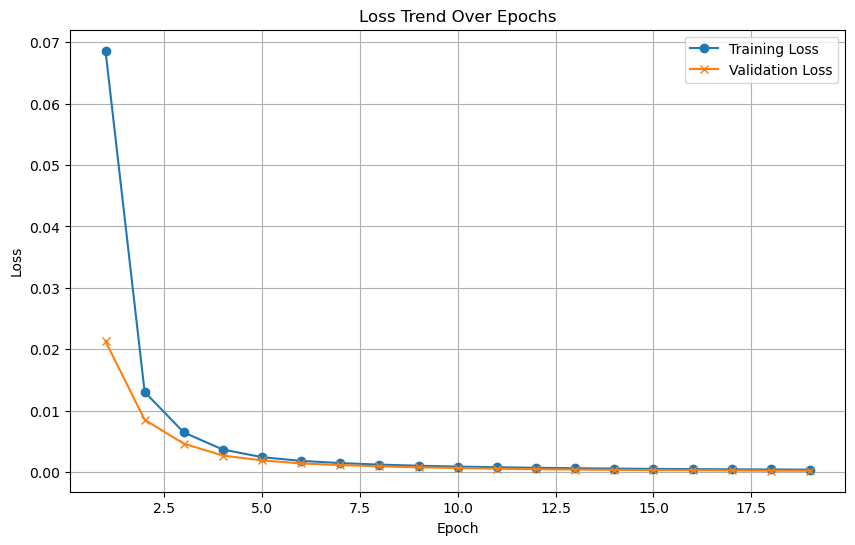

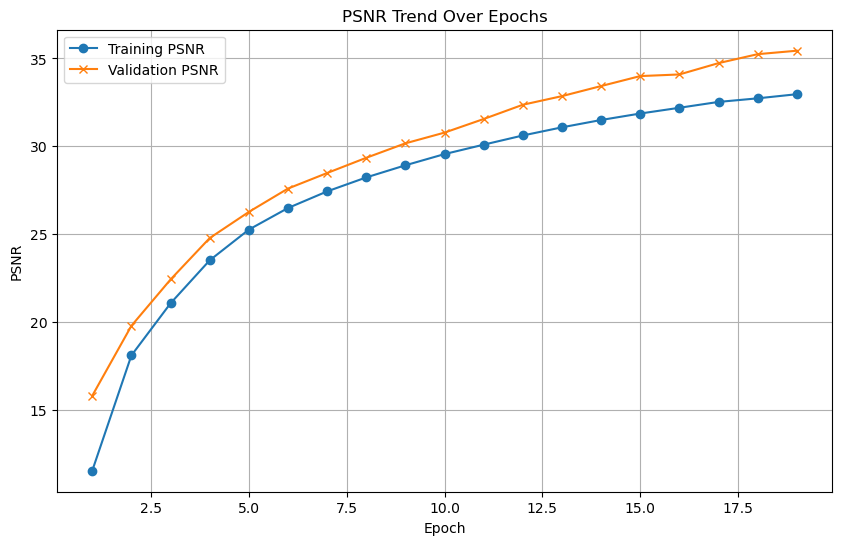

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/209 for test dataset.


    Processed batch 101/209 for test dataset.


    Processed batch 201/209 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7644
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7781. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6974
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6582
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6276
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [10/1000] completed, Average Training Loss: 2.5027
    Validation Batch [1/1], Loss: 2.7765
Validation Loss: 2.7765, Validation Accuracy: 6.25%
Validation loss improved from 2.7771 to 2.7765. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4686
    Validation Batch [1/1], Loss: 2.7757
Validation Loss: 2.7757, Validation Accuracy: 6.25%
Validation loss improved from 2.7765 to 2.7757. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4433
    Validation Batch [1/1], Loss: 2.7741
Validation Loss: 2.7741, Validation Accuracy: 10.00%
Validation loss improved from 2.7757 to 2.7741. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4317
    Validation Batch [1/1], Loss: 2.7721
Validation Loss: 2.7721, Validation Accuracy: 12.50%
Validation loss improved from 2.7741 to 2.7721. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/

Epoch [23/1000] completed, Average Training Loss: 2.2554
    Validation Batch [1/1], Loss: 2.6477
Validation Loss: 2.6477, Validation Accuracy: 23.75%
Validation loss improved from 2.6809 to 2.6477. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2380
    Validation Batch [1/1], Loss: 2.6124
Validation Loss: 2.6124, Validation Accuracy: 33.75%
Validation loss improved from 2.6477 to 2.6124. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2124
    Validation Batch [1/1], Loss: 2.5655
Validation Loss: 2.5655, Validation Accuracy: 40.00%
Validation loss improved from 2.6124 to 2.5655. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.1970
    Validation Batch [1/1], Loss: 2.5217
Validation Loss: 2.5217, Validation Accuracy: 43.75%
Validation loss improved from 2.5655 to 2.5217. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [2

Epoch [35/1000] completed, Average Training Loss: 2.0555
    Validation Batch [1/1], Loss: 2.1628
Validation Loss: 2.1628, Validation Accuracy: 61.25%
Validation loss improved from 2.1984 to 2.1628. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.0496
    Validation Batch [1/1], Loss: 2.1050
Validation Loss: 2.1050, Validation Accuracy: 57.50%
Validation loss improved from 2.1628 to 2.1050. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.0168
    Validation Batch [1/1], Loss: 2.1293
Validation Loss: 2.1293, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.0112
    Validation Batch [1/1], Loss: 2.0683
Validation Loss: 2.0683, Validation Accuracy: 62.50%
Validation loss improved from 2.1050 to 2.0683. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] complet

    Validation Batch [1/1], Loss: 1.9753
Validation Loss: 1.9753, Validation Accuracy: 65.00%
Validation loss improved from 1.9897 to 1.9753. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.9223
    Validation Batch [1/1], Loss: 1.9676
Validation Loss: 1.9676, Validation Accuracy: 65.00%
Validation loss improved from 1.9753 to 1.9676. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.9441
    Validation Batch [1/1], Loss: 1.9495
Validation Loss: 1.9495, Validation Accuracy: 65.00%
Validation loss improved from 1.9676 to 1.9495. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.9068
    Validation Batch [1/1], Loss: 1.9133
Validation Loss: 1.9133, Validation Accuracy: 66.25%
Validation loss improved from 1.9495 to 1.9133. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.8812
    Vali

Epoch [56/1000] completed, Average Training Loss: 1.7349
    Validation Batch [1/1], Loss: 1.7377
Validation Loss: 1.7377, Validation Accuracy: 73.75%
Validation loss improved from 1.7548 to 1.7377. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.7119
    Validation Batch [1/1], Loss: 1.7119
Validation Loss: 1.7119, Validation Accuracy: 68.75%
Validation loss improved from 1.7377 to 1.7119. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.6989
    Validation Batch [1/1], Loss: 1.7094
Validation Loss: 1.7094, Validation Accuracy: 68.75%
Validation loss improved from 1.7119 to 1.7094. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.6805
    Validation Batch [1/1], Loss: 1.6730
Validation Loss: 1.6730, Validation Accuracy: 68.75%
Validation loss improved from 1.7094 to 1.6730. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [6

Epoch [69/1000] completed, Average Training Loss: 1.5222
    Validation Batch [1/1], Loss: 1.4972
Validation Loss: 1.4972, Validation Accuracy: 75.00%
Validation loss improved from 1.5165 to 1.4972. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.5032
    Validation Batch [1/1], Loss: 1.5151
Validation Loss: 1.5151, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4924
    Validation Batch [1/1], Loss: 1.4636
Validation Loss: 1.4636, Validation Accuracy: 77.50%
Validation loss improved from 1.4972 to 1.4636. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.4790
    Validation Batch [1/1], Loss: 1.4386
Validation Loss: 1.4386, Validation Accuracy: 77.50%
Validation loss improved from 1.4636 to 1.4386. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] complet

Epoch [82/1000] completed, Average Training Loss: 1.3385
    Validation Batch [1/1], Loss: 1.2977
Validation Loss: 1.2977, Validation Accuracy: 81.25%
Validation loss improved from 1.3310 to 1.2977. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.2971
    Validation Batch [1/1], Loss: 1.2687
Validation Loss: 1.2687, Validation Accuracy: 81.25%
Validation loss improved from 1.2977 to 1.2687. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.3118
    Validation Batch [1/1], Loss: 1.2837
Validation Loss: 1.2837, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.2850
    Validation Batch [1/1], Loss: 1.2593
Validation Loss: 1.2593, Validation Accuracy: 80.00%
Validation loss improved from 1.2687 to 1.2593. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] complet

Epoch [96/1000] completed, Average Training Loss: 1.0966
    Validation Batch [1/1], Loss: 1.0744
Validation Loss: 1.0744, Validation Accuracy: 81.25%
Validation loss improved from 1.0987 to 1.0744. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.1014
    Validation Batch [1/1], Loss: 1.0526
Validation Loss: 1.0526, Validation Accuracy: 81.25%
Validation loss improved from 1.0744 to 1.0526. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.1001
    Validation Batch [1/1], Loss: 1.0587
Validation Loss: 1.0587, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0781
    Validation Batch [1/1], Loss: 1.0363
Validation Loss: 1.0363, Validation Accuracy: 81.25%
Validation loss improved from 1.0526 to 1.0363. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] compl

Epoch [108/1000] completed, Average Training Loss: 0.9533
    Validation Batch [1/1], Loss: 0.9075
Validation Loss: 0.9075, Validation Accuracy: 88.75%
Validation loss improved from 0.9340 to 0.9075. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 0.9293
    Validation Batch [1/1], Loss: 0.8995
Validation Loss: 0.8995, Validation Accuracy: 88.75%
Validation loss improved from 0.9075 to 0.8995. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 0.9216
    Validation Batch [1/1], Loss: 0.8935
Validation Loss: 0.8935, Validation Accuracy: 87.50%
Validation loss improved from 0.8995 to 0.8935. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.9108
    Validation Batch [1/1], Loss: 0.8646
Validation Loss: 0.8646, Validation Accuracy: 93.75%
Validation loss improved from 0.8935 to 0.8646. Saving model...

LOG: Epoch [112/1000] - Training


Epoch [121/1000] completed, Average Training Loss: 0.7880
    Validation Batch [1/1], Loss: 0.7393
Validation Loss: 0.7393, Validation Accuracy: 95.00%
Validation loss improved from 0.7469 to 0.7393. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.7685
    Validation Batch [1/1], Loss: 0.7159
Validation Loss: 0.7159, Validation Accuracy: 96.25%
Validation loss improved from 0.7393 to 0.7159. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.7539
    Validation Batch [1/1], Loss: 0.7132
Validation Loss: 0.7132, Validation Accuracy: 95.00%
Validation loss improved from 0.7159 to 0.7132. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.7486
    Validation Batch [1/1], Loss: 0.7307
Validation Loss: 0.7307, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000

Epoch [135/1000] completed, Average Training Loss: 0.6269
    Validation Batch [1/1], Loss: 0.6378
Validation Loss: 0.6378, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.6121
    Validation Batch [1/1], Loss: 0.6149
Validation Loss: 0.6149, Validation Accuracy: 97.50%
Validation loss improved from 0.6165 to 0.6149. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.5980
    Validation Batch [1/1], Loss: 0.5987
Validation Loss: 0.5987, Validation Accuracy: 97.50%
Validation loss improved from 0.6149 to 0.5987. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.6078
    Validation Batch [1/1], Loss: 0.5796
Validation Loss: 0.5796, Validation Accuracy: 93.75%
Validation loss improved from 0.5987 to 0.5796. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000

    Validation Batch [1/1], Loss: 0.5002
Validation Loss: 0.5002, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.4929
    Validation Batch [1/1], Loss: 0.5033
Validation Loss: 0.5033, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.4929
    Validation Batch [1/1], Loss: 0.4711
Validation Loss: 0.4711, Validation Accuracy: 92.50%
Validation loss improved from 0.4885 to 0.4711. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.4693
    Validation Batch [1/1], Loss: 0.4934
Validation Loss: 0.4934, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.4674
    Validation Batch [1/1], Loss: 0.4478
Vali

Epoch [162/1000] completed, Average Training Loss: 0.4164
    Validation Batch [1/1], Loss: 0.4565
Validation Loss: 0.4565, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3999
    Validation Batch [1/1], Loss: 0.4367
Validation Loss: 0.4367, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3965
    Validation Batch [1/1], Loss: 0.4290
Validation Loss: 0.4290, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.3848
    Validation Batch [1/1], Loss: 0.3794
Validation Loss: 0.3794, Validation Accuracy: 96.25%
Validation loss improved from 0.4041 to 0.3794. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training 

Epoch [174/1000] completed, Average Training Loss: 0.3308
    Validation Batch [1/1], Loss: 0.3610
Validation Loss: 0.3610, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.3263
    Validation Batch [1/1], Loss: 0.3670
Validation Loss: 0.3670, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.3260
    Validation Batch [1/1], Loss: 0.3124
Validation Loss: 0.3124, Validation Accuracy: 97.50%
Validation loss improved from 0.3394 to 0.3124. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.3161
    Validation Batch [1/1], Loss: 0.3045
Validation Loss: 0.3045, Validation Accuracy: 97.50%
Validation loss improved from 0.3124 to 0.3045. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Av

Epoch [188/1000] completed, Average Training Loss: 0.2594
    Validation Batch [1/1], Loss: 0.2663
Validation Loss: 0.2663, Validation Accuracy: 96.25%
Validation loss improved from 0.2860 to 0.2663. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.2604
    Validation Batch [1/1], Loss: 0.2794
Validation Loss: 0.2794, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2518
    Validation Batch [1/1], Loss: 0.2658
Validation Loss: 0.2658, Validation Accuracy: 97.50%
Validation loss improved from 0.2663 to 0.2658. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2727
    Validation Batch [1/1], Loss: 0.2930
Validation Loss: 0.2930, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Av

Epoch [202/1000] completed, Average Training Loss: 0.2220
    Validation Batch [1/1], Loss: 0.2318
Validation Loss: 0.2318, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.2157
    Validation Batch [1/1], Loss: 0.2298
Validation Loss: 0.2298, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.2171
    Validation Batch [1/1], Loss: 0.2333
Validation Loss: 0.2333, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.2058
    Validation Batch [1/1], Loss: 0.2472
Validation Loss: 0.2472, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.1863
  

Epoch [215/1000] completed, Average Training Loss: 0.1630
    Validation Batch [1/1], Loss: 0.2162
Validation Loss: 0.2162, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1597
    Validation Batch [1/1], Loss: 0.2009
Validation Loss: 0.2009, Validation Accuracy: 97.50%
Validation loss improved from 0.2108 to 0.2009. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1738
    Validation Batch [1/1], Loss: 0.2047
Validation Loss: 0.2047, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.1536
    Validation Batch [1/1], Loss: 0.2048
Validation Loss: 0.2048, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training 

Epoch [228/1000] completed, Average Training Loss: 0.1531
    Validation Batch [1/1], Loss: 0.3069
Validation Loss: 0.3069, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1502
    Validation Batch [1/1], Loss: 0.2203
Validation Loss: 0.2203, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1510
    Validation Batch [1/1], Loss: 0.2569
Validation Loss: 0.2569, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1387
    Validation Batch [1/1], Loss: 0.2264
Validation Loss: 0.2264, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.1429


Epoch [242/1000] completed, Average Training Loss: 0.1369
    Validation Batch [1/1], Loss: 0.2470
Validation Loss: 0.2470, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.1347
    Validation Batch [1/1], Loss: 0.1852
Validation Loss: 0.1852, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.1323
    Validation Batch [1/1], Loss: 0.2006
Validation Loss: 0.2006, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.1092
    Validation Batch [1/1], Loss: 0.1795
Validation Loss: 0.1795, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.1173
  

Epoch [254/1000] completed, Average Training Loss: 0.1079
    Validation Batch [1/1], Loss: 0.1759
Validation Loss: 0.1759, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Loss: 0.1749
Validation Loss: 0.1749, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0959
    Validation Batch [1/1], Loss: 0.1767
Validation Loss: 0.1767, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.1683
Validation Loss: 0.1683, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.099

Epoch [267/1000] completed, Average Training Loss: 0.0979
    Validation Batch [1/1], Loss: 0.1622
Validation Loss: 0.1622, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.1927
Validation Loss: 0.1927, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.1061
    Validation Batch [1/1], Loss: 0.1757
Validation Loss: 0.1757, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.1102
  

Epoch [281/1000] completed, Average Training Loss: 0.0812
    Validation Batch [1/1], Loss: 0.1753
Validation Loss: 0.1753, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.0831
    Validation Batch [1/1], Loss: 0.1504
Validation Loss: 0.1504, Validation Accuracy: 97.50%
Validation loss improved from 0.1514 to 0.1504. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.0696
    Validation Batch [1/1], Loss: 0.1690
Validation Loss: 0.1690, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0742
    Validation Batch [1/1], Loss: 0.1693
Validation Loss: 0.1693, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.1610
Validation Loss: 0.1610, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.0674
    Validation Batch [1/1], Loss: 0.1487
Validation Loss: 0.1487, Validation Accuracy: 97.50%
Validation loss improved from 0.1497 to 0.1487. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.1645
Validation Loss: 0.1645, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 0.1612
Validation Loss: 0.1612, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.0697
    Validation Batch [1/1], Loss: 0.1751
Vali

    Validation Batch [1/1], Loss: 0.1691
Validation Loss: 0.1691, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.0596
    Validation Batch [1/1], Loss: 0.1471
Validation Loss: 0.1471, Validation Accuracy: 97.50%
Validation loss improved from 0.1474 to 0.1471. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0610
    Validation Batch [1/1], Loss: 0.1450
Validation Loss: 0.1450, Validation Accuracy: 97.50%
Validation loss improved from 0.1471 to 0.1450. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.1498
Validation Loss: 0.1498, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.0615
    Validation Batch [1/1], Lo

Epoch [320/1000] completed, Average Training Loss: 0.0633
    Validation Batch [1/1], Loss: 0.1742
Validation Loss: 0.1742, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.1512
Validation Loss: 0.1512, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0537
    Validation Batch [1/1], Loss: 0.1475
Validation Loss: 0.1475, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0611
    Validation Batch [1/1], Loss: 0.1471
Validation Loss: 0.1471, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.055

Epoch [333/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.1516
Validation Loss: 0.1516, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0456
    Validation Batch [1/1], Loss: 0.1481
Validation Loss: 0.1481, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.1392
Validation Loss: 0.1392, Validation Accuracy: 97.50%
Validation loss improved from 0.1433 to 0.1392. Saving model...

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.1408
Validation Loss: 0.1408, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training 

Epoch [347/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.2671
Validation Loss: 0.2671, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.1484
Validation Loss: 0.1484, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.3687
Validation Loss: 0.3687, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.0518
    Validation Batch [1/1], Loss: 0.3098
Validation Loss: 0.3098, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.046

Epoch [360/1000] completed, Average Training Loss: 0.0441
    Validation Batch [1/1], Loss: 0.1512
Validation Loss: 0.1512, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.1563
Validation Loss: 0.1563, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.1671
Validation Loss: 0.1671, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.0394
    Validation Batch [1/1], Loss: 0.1611
Validation Loss: 0.1611, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.038

Epoch [373/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.1691
Validation Loss: 0.1691, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0348
    Validation Batch [1/1], Loss: 0.1609
Validation Loss: 0.1609, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.1404
Validation Loss: 0.1404, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.1549
Validation Loss: 0.1549, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.0399
  

Epoch [386/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.1568
Validation Loss: 0.1568, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0326
    Validation Batch [1/1], Loss: 0.1689
Validation Loss: 0.1689, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.1695
Validation Loss: 0.1695, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.1460
Validation Loss: 0.1460, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.036

    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0285
    Validation Batch [1/1], Loss: 0.1455
Validation Loss: 0.1455, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.1483
Validation Loss: 0.1483, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.1348
Validation Loss: 0.1348, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.1463
Validation Loss

Epoch [412/1000] completed, Average Training Loss: 0.0304
    Validation Batch [1/1], Loss: 0.1564
Validation Loss: 0.1564, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.1536
Validation Loss: 0.1536, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.1430
Validation Loss: 0.1430, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0327
    Validation Batch [1/1], Loss: 0.1429
Validation Loss: 0.1429, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.028

Epoch [425/1000] completed, Average Training Loss: 0.0326
    Validation Batch [1/1], Loss: 0.1424
Validation Loss: 0.1424, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.1379
Validation Loss: 0.1379, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.0307
    Validation Batch [1/1], Loss: 0.1397
Validation Loss: 0.1397, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.1588
Validation Loss: 0.1588, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.024

Epoch [438/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.3515
Validation Loss: 0.3515, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0268
    Validation Batch [1/1], Loss: 0.2565
Validation Loss: 0.2565, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.1642
Validation Loss: 0.1642, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.024

Epoch [451/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.1497
Validation Loss: 0.1497, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.2073
Validation Loss: 0.2073, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.1450
Validation Loss: 0.1450, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1779
Validation Loss: 0.1779, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.030

Epoch [465/1000] completed, Average Training Loss: 0.0283
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.1847
Validation Loss: 0.1847, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.1462
Validation Loss: 0.1462, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.1531
Validation Loss: 0.1531, Validation Accuracy: 97.50%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.022

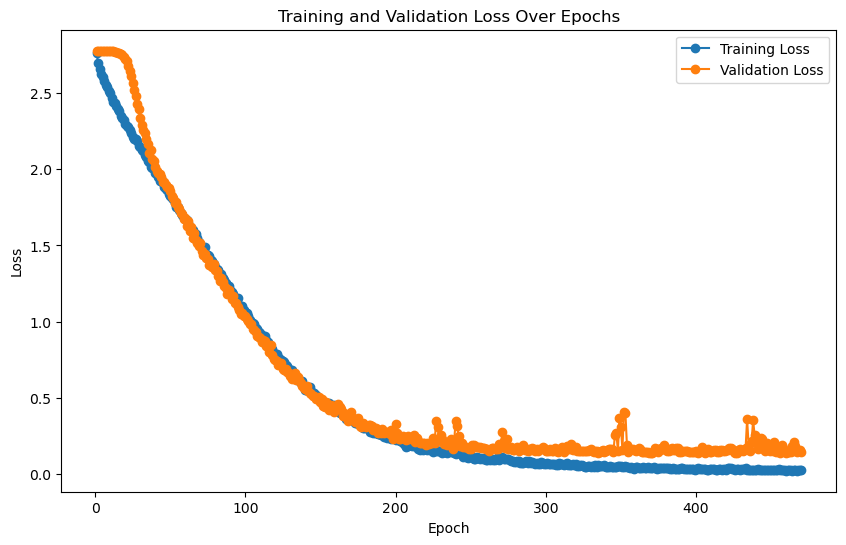

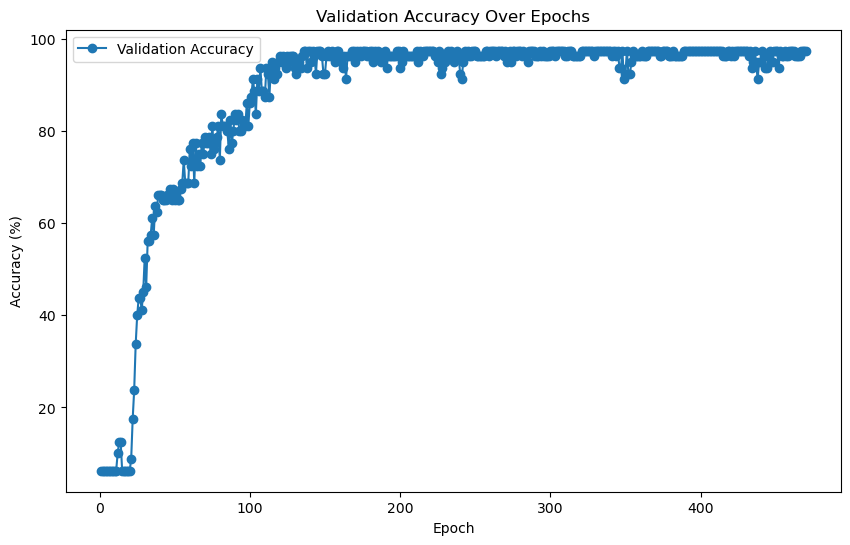


Evaluating on the test set...
    Test Batch [1/209], Loss: 0.4083



Final Test Loss: 0.2994, Test Accuracy: 92.99%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.
  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.


  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.
  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.


  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.
  Processed batch 130/209 for test dataset.


  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.


  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)

LOG: Training features shape: (640, 64), Training labels shape: (640,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53409, 64), Test labels shape: (53409,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.


Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1964
           1       1.00      0.96      0.98      3681
           2       0.93      0.98      0.96      1931
           3       1.00      0.99      1.00      1349
           4       0.95      0.97      0.96      2633
           5       1.00      0.99      0.99      3914
           6       0.96      0.99      0.98      3534
           7       0.79      0.70      0.74     11226
           8       0.99      0.96      0.97      6158
           9       0.91      0.81      0.86      3233
          10       0.66      0.95      0.78      1023
          11       0.81      0.98      0.89      1882
          12       0.77      0.98      0.87       871
          13       0.85      0.95      0.89      1025
          14       0.63      0.66      0.64      7223
          15       0.84      0.91      0.88      1762

    accuracy                           0.86     53

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)
Train reps shape: (640, 64)
Train labels shape: (640,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53409, 64)
Test labels shape: (53409,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6853  |  Val Loss: 2.5244
Validation loss improved from inf to 2.5244.
[Epoch 2/1000] Train Loss: 2.4280  |  Val Loss: 2.2869
Validation loss improved from 2.5244 to 2.2869.
[Epoch 3/1000] Train Loss: 2.1739  |  Val Loss: 2.0294
Validation loss improved from 2.2869 to 2.0294.
[Epoch 4/1000] Train Loss: 1.9052  |  Val Loss: 1.7586
Validation loss improved from 2.0294 to 1.7586.
[Epoch 5/1000] Train Loss: 1.6168  |  Val Loss: 1.4902
Validation loss improved from 1.7586 to 1.4902.


[Epoch 6/1000] Train Loss: 1.3790  |  Val Loss: 1.2847
Validation loss improved from 1.4902 to 1.2847.
[Epoch 7/1000] Train Loss: 1.1804  |  Val Loss: 1.1152
Validation loss improved from 1.2847 to 1.1152.
[Epoch 8/1000] Train Loss: 1.0172  |  Val Loss: 0.9605
Validation loss improved from 1.1152 to 0.9605.
[Epoch 9/1000] Train Loss: 0.8933  |  Val Loss: 0.8654
Validation loss improved from 0.9605 to 0.8654.
[Epoch 10/1000] Train Loss: 0.7953  |  Val Loss: 0.7843
Validation loss improved from 0.8654 to 0.7843.
[Epoch 11/1000] Train Loss: 0.7173  |  Val Loss: 0.7070
Validation loss improved from 0.7843 to 0.7070.


[Epoch 12/1000] Train Loss: 0.6493  |  Val Loss: 0.6533
Validation loss improved from 0.7070 to 0.6533.
[Epoch 13/1000] Train Loss: 0.5840  |  Val Loss: 0.6012
Validation loss improved from 0.6533 to 0.6012.
[Epoch 14/1000] Train Loss: 0.5434  |  Val Loss: 0.5743
Validation loss improved from 0.6012 to 0.5743.
[Epoch 15/1000] Train Loss: 0.5050  |  Val Loss: 0.5525
Validation loss improved from 0.5743 to 0.5525.


[Epoch 16/1000] Train Loss: 0.4723  |  Val Loss: 0.5141
Validation loss improved from 0.5525 to 0.5141.
[Epoch 17/1000] Train Loss: 0.4531  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 18/1000] Train Loss: 0.4378  |  Val Loss: 0.5090
Validation loss improved from 0.5141 to 0.5090.
[Epoch 19/1000] Train Loss: 0.4168  |  Val Loss: 0.4571
Validation loss improved from 0.5090 to 0.4571.
[Epoch 20/1000] Train Loss: 0.3775  |  Val Loss: 0.4346
Validation loss improved from 0.4571 to 0.4346.
[Epoch 21/1000] Train Loss: 0.3535  |  Val Loss: 0.4304
Validation loss improved from 0.4346 to 0.4304.


[Epoch 22/1000] Train Loss: 0.3374  |  Val Loss: 0.4242
Validation loss improved from 0.4304 to 0.4242.
[Epoch 23/1000] Train Loss: 0.3320  |  Val Loss: 0.4183
Validation loss improved from 0.4242 to 0.4183.
[Epoch 24/1000] Train Loss: 0.3222  |  Val Loss: 0.4116
Validation loss improved from 0.4183 to 0.4116.
[Epoch 25/1000] Train Loss: 0.3169  |  Val Loss: 0.3794
Validation loss improved from 0.4116 to 0.3794.


[Epoch 26/1000] Train Loss: 0.3045  |  Val Loss: 0.3998
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.2990  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 0.2905  |  Val Loss: 0.3850
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 29/1000] Train Loss: 0.2714  |  Val Loss: 0.3765
Validation loss improved from 0.3794 to 0.3765.
[Epoch 30/1000] Train Loss: 0.2577  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 31/1000] Train Loss: 0.2649  |  Val Loss: 0.3546
Validation loss improved from 0.3765 to 0.3546.


[Epoch 32/1000] Train Loss: 0.2489  |  Val Loss: 0.3790
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 0.2531  |  Val Loss: 0.3772
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 0.2583  |  Val Loss: 0.3673
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 35/1000] Train Loss: 0.2400  |  Val Loss: 0.3461
Validation loss improved from 0.3546 to 0.3461.
[Epoch 36/1000] Train Loss: 0.2372  |  Val Loss: 0.3558
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.2211  |  Val Loss: 0.3624
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 38/1000] Train Loss: 0.2136  |  Val Loss: 0.3405
Validation loss improved from 0.3461 to 0.3405.
[Epoch 39/1000] Train Loss: 0.2150  |  Val Loss: 0.3500
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.2069  |  Val Loss: 0.3556
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 0.2076  |  Val Loss: 0.3400
Validation loss improved from 0.3405 to 0.3400.


[Epoch 42/1000] Train Loss: 0.1982  |  Val Loss: 0.3542
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.2029  |  Val Loss: 0.3497
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 44/1000] Train Loss: 0.2081  |  Val Loss: 0.3701
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 45/1000] Train Loss: 0.1982  |  Val Loss: 0.3301
Validation loss improved from 0.3400 to 0.3301.
[Epoch 46/1000] Train Loss: 0.1842  |  Val Loss: 0.3407
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.1903  |  Val Loss: 0.3509
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 48/1000] Train Loss: 0.1998  |  Val Loss: 0.3289
Validation loss improved from 0.3301 to 0.3289.
[Epoch 49/1000] Train Loss: 0.1949  |  Val Loss: 0.3233
Validation loss improved from 0.3289 to 0.3233.
[Epoch 50/1000] Train Loss: 0.1914  |  Val Loss: 0.3288
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.1835  |  Val Loss: 0.3407
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.1760  |  Val Loss: 0.3085
Validation loss improved from 0.3233 to 0.3085.


[Epoch 53/1000] Train Loss: 0.1828  |  Val Loss: 0.3320
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.1670  |  Val Loss: 0.3444
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.1673  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 56/1000] Train Loss: 0.1655  |  Val Loss: 0.3279
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 57/1000] Train Loss: 0.1581  |  Val Loss: 0.3045
Validation loss improved from 0.3085 to 0.3045.


[Epoch 58/1000] Train Loss: 0.1502  |  Val Loss: 0.3002
Validation loss improved from 0.3045 to 0.3002.
[Epoch 59/1000] Train Loss: 0.1628  |  Val Loss: 0.3245
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.1749  |  Val Loss: 0.3886
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.1665  |  Val Loss: 0.3130
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.1514  |  Val Loss: 0.2978
Validation loss improved from 0.3002 to 0.2978.
[Epoch 63/1000] Train Loss: 0.1402  |  Val Loss: 0.3083
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 64/1000] Train Loss: 0.1446  |  Val Loss: 0.3382
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 0.1458  |  Val Loss: 0.3181
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 66/1000] Train Loss: 0.1453  |  Val Loss: 0.2844
Validation loss improved from 0.2978 to 0.2844.
[Epoch 67/1000] Train Loss: 0.1526  |  Val Loss: 0.3078
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.1406  |  Val Loss: 0.2959
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 69/1000] Train Loss: 0.1549  |  Val Loss: 0.3314
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 70/1000] Train Loss: 0.1463  |  Val Loss: 0.3035
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 71/1000] Train Loss: 0.1482  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 72/1000] Train Loss: 0.1480  |  Val Loss: 0.3883
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 73/1000] Train Loss: 0.1530  |  Val Loss: 0.2799
Validation loss improved from 0.2844 to 0.2799.
[Epoch 74/1000] Train Loss: 0.1409  |  Val Loss: 0.3234
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 75/1000] Train Loss: 0.1381  |  Val Loss: 0.2945
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 0.1282  |  Val Loss: 0.3383
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 0.1558  |  Val Loss: 0.3014
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 0.1259  |  Val Loss: 0.3205
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 79/1000] Train Loss: 0.1218  |  Val Loss: 0.2978
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 80/1000] Train Loss: 0.1259  |  Val Loss: 0.3211
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 81/1000] Train Loss: 0.1206  |  Val Loss: 0.3126
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 82/1000] Train Loss: 0.1226  |  Val Loss: 0.3139
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 83/1000] Train Loss: 0.1134  |  Val Loss: 0.3447
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 84/1000] Train Loss: 0.1291  |  Val Loss: 0.2855
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 85/1000] Train Loss: 0.1132  |  Val Loss: 0.2742
Validation loss improved from 0.2799 to 0.2742.


[Epoch 86/1000] Train Loss: 0.1409  |  Val Loss: 0.2831
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 0.1246  |  Val Loss: 0.3572
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 88/1000] Train Loss: 0.1297  |  Val Loss: 0.3057
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 0.1168  |  Val Loss: 0.3043
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 90/1000] Train Loss: 0.1110  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 91/1000] Train Loss: 0.1066  |  Val Loss: 0.3009
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 0.1096  |  Val Loss: 0.2809
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 93/1000] Train Loss: 0.1062  |  Val Loss: 0.3031
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 94/1000] Train Loss: 0.1030  |  Val Loss: 0.3043
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 95/1000] Train Loss: 0.1294  |  Val Loss: 0.4022
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 96/1000] Train Loss: 0.1372  |  Val Loss: 0.3783
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 97/1000] Train Loss: 0.1055  |  Val Loss: 0.3320
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 98/1000] Train Loss: 0.1054  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 99/1000] Train Loss: 0.1085  |  Val Loss: 0.2969
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 100/1000] Train Loss: 0.1001  |  Val Loss: 0.3055
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 101/1000] Train Loss: 0.0937  |  Val Loss: 0.3589
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 102/1000] Train Loss: 0.1028  |  Val Loss: 0.3395
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 103/1000] Train Loss: 0.1041  |  Val Loss: 0.3378
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 104/1000] Train Loss: 0.0994  |  Val Loss: 0.3039
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 105/1000] Train Loss: 0.0993  |  Val Loss: 0.3070
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 106/1000] Train Loss: 0.1102  |  Val Loss: 0.2991
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 107/1000] Train Loss: 0.0936  |  Val Loss: 0.2989
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 108/1000] Train Loss: 0.0902  |  Val Loss: 0.3243
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 109/1000] Train Loss: 0.0927  |  Val Loss: 0.3452
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 110/1000] Train Loss: 0.0990  |  Val Loss: 0.3241
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 111/1000] Train Loss: 0.0913  |  Val Loss: 0.2733
Validation loss improved from 0.2742 to 0.2733.


[Epoch 112/1000] Train Loss: 0.1014  |  Val Loss: 0.3233
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 0.0911  |  Val Loss: 0.3446
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/1000] Train Loss: 0.0960  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 115/1000] Train Loss: 0.0941  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 116/1000] Train Loss: 0.0853  |  Val Loss: 0.3271
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 117/1000] Train Loss: 0.0812  |  Val Loss: 0.3052
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 118/1000] Train Loss: 0.0849  |  Val Loss: 0.3437
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 119/1000] Train Loss: 0.0852  |  Val Loss: 0.3528
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 120/1000] Train Loss: 0.0842  |  Val Loss: 0.3255
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 121/1000] Train Loss: 0.0843  |  Val Loss: 0.3081
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 122/1000] Train Loss: 0.0832  |  Val Loss: 0.3126
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 123/1000] Train Loss: 0.0942  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 124/1000] Train Loss: 0.0903  |  Val Loss: 0.3771
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 125/1000] Train Loss: 0.0919  |  Val Loss: 0.3152
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 126/1000] Train Loss: 0.0748  |  Val Loss: 0.3313
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 127/1000] Train Loss: 0.0848  |  Val Loss: 0.3297
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 128/1000] Train Loss: 0.0855  |  Val Loss: 0.3901
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 129/1000] Train Loss: 0.1000  |  Val Loss: 0.4201
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 130/1000] Train Loss: 0.1027  |  Val Loss: 0.3532
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 131/1000] Train Loss: 0.0889  |  Val Loss: 0.3332
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 132/1000] Train Loss: 0.0781  |  Val Loss: 0.3448
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 133/1000] Train Loss: 0.0712  |  Val Loss: 0.3405
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 134/1000] Train Loss: 0.0803  |  Val Loss: 0.3333
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 135/1000] Train Loss: 0.0700  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 136/1000] Train Loss: 0.0902  |  Val Loss: 0.3242
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 137/1000] Train Loss: 0.0861  |  Val Loss: 0.3134
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 138/1000] Train Loss: 0.0797  |  Val Loss: 0.3442
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 139/1000] Train Loss: 0.0894  |  Val Loss: 0.3560
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 140/1000] Train Loss: 0.0715  |  Val Loss: 0.3941
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 141/1000] Train Loss: 0.0721  |  Val Loss: 0.3557
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 142/1000] Train Loss: 0.0699  |  Val Loss: 0.3745
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 143/1000] Train Loss: 0.0669  |  Val Loss: 0.3179
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 144/1000] Train Loss: 0.0635  |  Val Loss: 0.3858
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 145/1000] Train Loss: 0.0744  |  Val Loss: 0.3528
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 146/1000] Train Loss: 0.0723  |  Val Loss: 0.3552
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 147/1000] Train Loss: 0.0732  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 148/1000] Train Loss: 0.0725  |  Val Loss: 0.3435
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 149/1000] Train Loss: 0.0813  |  Val Loss: 0.3602
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 150/1000] Train Loss: 0.0795  |  Val Loss: 0.3904
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 151/1000] Train Loss: 0.0734  |  Val Loss: 0.3414
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 152/1000] Train Loss: 0.0641  |  Val Loss: 0.3710
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 153/1000] Train Loss: 0.0710  |  Val Loss: 0.3400
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 154/1000] Train Loss: 0.0598  |  Val Loss: 0.3270
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 155/1000] Train Loss: 0.0568  |  Val Loss: 0.3683
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 156/1000] Train Loss: 0.0724  |  Val Loss: 0.3352
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 157/1000] Train Loss: 0.0715  |  Val Loss: 0.3515
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 158/1000] Train Loss: 0.0864  |  Val Loss: 0.2920
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 159/1000] Train Loss: 0.0855  |  Val Loss: 0.3880
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 160/1000] Train Loss: 0.0764  |  Val Loss: 0.4066
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 161/1000] Train Loss: 0.0747  |  Val Loss: 0.3573
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 162/1000] Train Loss: 0.0678  |  Val Loss: 0.3810
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 163/1000] Train Loss: 0.0704  |  Val Loss: 0.3447
!! Validation loss did NOT improve !! Patience: 52/100


[Epoch 164/1000] Train Loss: 0.0604  |  Val Loss: 0.3624
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 165/1000] Train Loss: 0.0599  |  Val Loss: 0.3471
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 166/1000] Train Loss: 0.0556  |  Val Loss: 0.3378
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 167/1000] Train Loss: 0.0665  |  Val Loss: 0.3461
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 168/1000] Train Loss: 0.0580  |  Val Loss: 0.3896
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 169/1000] Train Loss: 0.0621  |  Val Loss: 0.3376
!! Validation loss did NOT improve !! Patience: 58/100


[Epoch 170/1000] Train Loss: 0.0536  |  Val Loss: 0.3341
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 171/1000] Train Loss: 0.0562  |  Val Loss: 0.3707
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 172/1000] Train Loss: 0.0625  |  Val Loss: 0.3938
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 173/1000] Train Loss: 0.0692  |  Val Loss: 0.3845
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 174/1000] Train Loss: 0.0615  |  Val Loss: 0.3537
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 175/1000] Train Loss: 0.0604  |  Val Loss: 0.3573
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 176/1000] Train Loss: 0.0663  |  Val Loss: 0.3562
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 177/1000] Train Loss: 0.0772  |  Val Loss: 0.3052
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 178/1000] Train Loss: 0.0763  |  Val Loss: 0.3252
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 179/1000] Train Loss: 0.0612  |  Val Loss: 0.3500
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 180/1000] Train Loss: 0.0620  |  Val Loss: 0.3888
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 181/1000] Train Loss: 0.0608  |  Val Loss: 0.3322
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 182/1000] Train Loss: 0.0597  |  Val Loss: 0.3315
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 183/1000] Train Loss: 0.0688  |  Val Loss: 0.3302
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 184/1000] Train Loss: 0.0696  |  Val Loss: 0.4023
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 185/1000] Train Loss: 0.0687  |  Val Loss: 0.3954
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 186/1000] Train Loss: 0.0572  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 187/1000] Train Loss: 0.0596  |  Val Loss: 0.3521
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 188/1000] Train Loss: 0.0553  |  Val Loss: 0.3514
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 189/1000] Train Loss: 0.0536  |  Val Loss: 0.3560
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 190/1000] Train Loss: 0.0592  |  Val Loss: 0.3603
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 191/1000] Train Loss: 0.0598  |  Val Loss: 0.3153
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 192/1000] Train Loss: 0.0500  |  Val Loss: 0.3543
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 193/1000] Train Loss: 0.0484  |  Val Loss: 0.3696
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 194/1000] Train Loss: 0.0609  |  Val Loss: 0.3798
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 195/1000] Train Loss: 0.0560  |  Val Loss: 0.3490
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 196/1000] Train Loss: 0.0529  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 197/1000] Train Loss: 0.0537  |  Val Loss: 0.3416
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 198/1000] Train Loss: 0.0600  |  Val Loss: 0.3262
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 199/1000] Train Loss: 0.0558  |  Val Loss: 0.3643
!! Validation loss did NOT improve !! Patience: 88/100


[Epoch 200/1000] Train Loss: 0.0471  |  Val Loss: 0.3496
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 201/1000] Train Loss: 0.0577  |  Val Loss: 0.2803
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 202/1000] Train Loss: 0.0762  |  Val Loss: 0.3344
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 203/1000] Train Loss: 0.0587  |  Val Loss: 0.3373
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 204/1000] Train Loss: 0.0457  |  Val Loss: 0.3101
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 205/1000] Train Loss: 0.0473  |  Val Loss: 0.3076
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 206/1000] Train Loss: 0.0463  |  Val Loss: 0.3145
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 207/1000] Train Loss: 0.0496  |  Val Loss: 0.3112
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 208/1000] Train Loss: 0.0596  |  Val Loss: 0.3197
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 209/1000] Train Loss: 0.0513  |  Val Loss: 0.2906
!! Validation loss did NOT improve !! Patience: 98/100


[Epoch 210/1000] Train Loss: 0.0594  |  Val Loss: 0.3788
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 211/1000] Train Loss: 0.0490  |  Val Loss: 0.3691
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 211 !!
No improvement for 100 epochs.


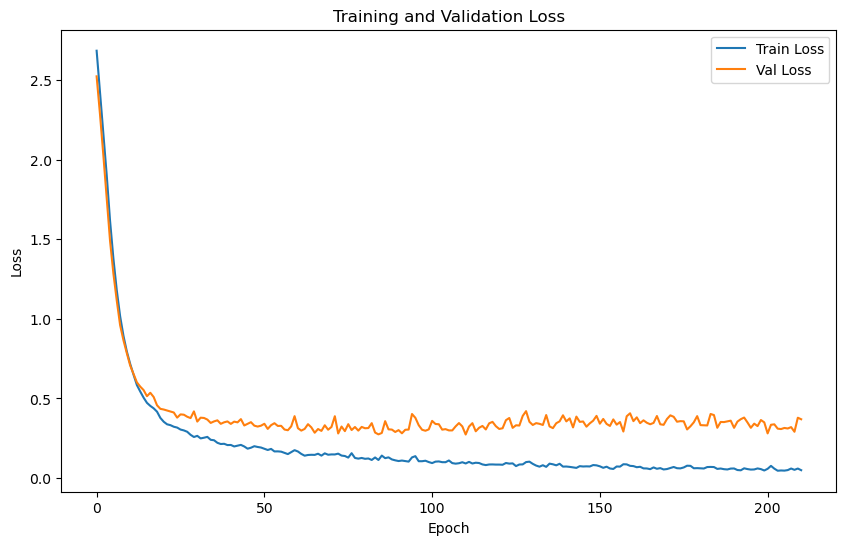

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5819 | Test Accuracy: 88.19%


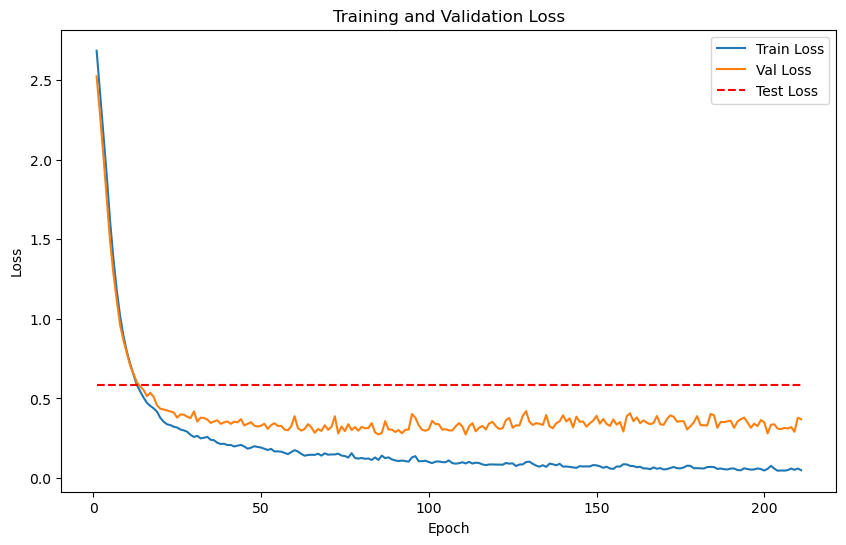

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.0528
    Batch [2/2], Train Loss: 8.0803
Epoch [1/2000], Avg Train Loss: 8.0665
Epoch [1/2000], Avg Val Loss: 3.1842
Validation loss improved from inf to 3.1842. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.2350
    Batch [2/2], Train Loss: 7.9909
Epoch [2/2000], Avg Train Loss: 8.1129
Epoch [2/2000], Avg Val Loss: 3.1520
Validation loss improved from 3.1842 to 3.1520. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.9062
    Batch [2/2], Train Loss: 7.9804
Epoch [3/2000], Avg Train Loss: 7.9433
Epoch [3/2000], Avg Val Loss: 3.1219
Validation loss improved from 3.1520 to 3.1219. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.7222
    Batch [2/2], Train Loss: 7.7027
Epoch [4/2000], Avg Train Loss: 7.7124
Epoch [4/2000], Avg Val Loss: 3.0937
Validation loss improved from 3.1219 to 3.0937. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [1/2], Train Loss: 6.6410
    Batch [2/2], Train Loss: 6.7255
Epoch [12/2000], Avg Train Loss: 6.6832
Epoch [12/2000], Avg Val Loss: 2.9290
Validation loss improved from 2.9447 to 2.9290. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.5720
    Batch [2/2], Train Loss: 6.3885
Epoch [13/2000], Avg Train Loss: 6.4802
Epoch [13/2000], Avg Val Loss: 2.9146
Validation loss improved from 2.9290 to 2.9146. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.6582
    Batch [2/2], Train Loss: 6.5493
Epoch [14/2000], Avg Train Loss: 6.6037
Epoch [14/2000], Avg Val Loss: 2.9015
Validation loss improved from 2.9146 to 2.9015. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.3783
    Batch [2/2], Train Loss: 6.3939
Epoch [15/2000], Avg Train Loss: 6.3861
Epoch [15/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.9015 to 2.8895. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.8899
    Batch [2/2], Train Loss: 5.7989
Epoch [23/2000], Avg Train Loss: 5.8444
Epoch [23/2000], Avg Val Loss: 2.8248
Validation loss improved from 2.8305 to 2.8248. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.8102
    Batch [2/2], Train Loss: 5.7319
Epoch [24/2000], Avg Train Loss: 5.7710
Epoch [24/2000], Avg Val Loss: 2.8196
Validation loss improved from 2.8248 to 2.8196. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.8016
    Batch [2/2], Train Loss: 5.6802
Epoch [25/2000], Avg Train Loss: 5.7409
Epoch [25/2000], Avg Val Loss: 2.8149
Validation loss improved from 2.8196 to 2.8149. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.6828
    Batch [2/2], Train Loss: 5.6853
Epoch [26/2000], Avg Train Loss: 5.6841
Epoch [26/2000], Avg Val Loss: 2.8107
Validation loss improved from 2.8149 to 2.8107. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.3831
Epoch [33/2000], Avg Train Loss: 5.3479
Epoch [33/2000], Avg Val Loss: 2.7878
Validation loss improved from 2.7904 to 2.7878. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3570
    Batch [2/2], Train Loss: 5.3870
Epoch [34/2000], Avg Train Loss: 5.3720
Epoch [34/2000], Avg Val Loss: 2.7853
Validation loss improved from 2.7878 to 2.7853. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.3564
    Batch [2/2], Train Loss: 5.2496
Epoch [35/2000], Avg Train Loss: 5.3030
Epoch [35/2000], Avg Val Loss: 2.7829
Validation loss improved from 2.7853 to 2.7829. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.2837
    Batch [2/2], Train Loss: 5.2195
Epoch [36/2000], Avg Train Loss: 5.2516
Epoch [36/2000], Avg Val Loss: 2.7805
Validation loss improved from 2.7829 to 2.7805. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.1708
    Batch [2

    Batch [2/2], Train Loss: 5.1047
Epoch [43/2000], Avg Train Loss: 5.0808
Epoch [43/2000], Avg Val Loss: 2.7642
Validation loss improved from 2.7666 to 2.7642. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 5.0600
    Batch [2/2], Train Loss: 5.0699
Epoch [44/2000], Avg Train Loss: 5.0649
Epoch [44/2000], Avg Val Loss: 2.7618
Validation loss improved from 2.7642 to 2.7618. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.0540
    Batch [2/2], Train Loss: 5.0353
Epoch [45/2000], Avg Train Loss: 5.0446
Epoch [45/2000], Avg Val Loss: 2.7594
Validation loss improved from 2.7618 to 2.7594. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 4.9803
    Batch [2/2], Train Loss: 5.1029
Epoch [46/2000], Avg Train Loss: 5.0416
Epoch [46/2000], Avg Val Loss: 2.7569
Validation loss improved from 2.7594 to 2.7569. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.0870
    Batch [2

    Batch [1/2], Train Loss: 4.9194
    Batch [2/2], Train Loss: 4.8771
Epoch [54/2000], Avg Train Loss: 4.8982
Epoch [54/2000], Avg Val Loss: 2.7353
Validation loss improved from 2.7382 to 2.7353. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.9188
    Batch [2/2], Train Loss: 4.8602
Epoch [55/2000], Avg Train Loss: 4.8895
Epoch [55/2000], Avg Val Loss: 2.7324
Validation loss improved from 2.7353 to 2.7324. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.8997
    Batch [2/2], Train Loss: 4.8413
Epoch [56/2000], Avg Train Loss: 4.8705
Epoch [56/2000], Avg Val Loss: 2.7294
Validation loss improved from 2.7324 to 2.7294. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.8670
    Batch [2/2], Train Loss: 4.8510
Epoch [57/2000], Avg Train Loss: 4.8590
Epoch [57/2000], Avg Val Loss: 2.7262
Validation loss improved from 2.7294 to 2.7262. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.7814
    Batch [2/2], Train Loss: 4.8639
Epoch [64/2000], Avg Train Loss: 4.8227
Epoch [64/2000], Avg Val Loss: 2.7034
Validation loss improved from 2.7067 to 2.7034. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.8234
    Batch [2/2], Train Loss: 4.7640
Epoch [65/2000], Avg Train Loss: 4.7937
Epoch [65/2000], Avg Val Loss: 2.7001
Validation loss improved from 2.7034 to 2.7001. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.7748
    Batch [2/2], Train Loss: 4.7344
Epoch [66/2000], Avg Train Loss: 4.7546
Epoch [66/2000], Avg Val Loss: 2.6968
Validation loss improved from 2.7001 to 2.6968. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.7553
    Batch [2/2], Train Loss: 4.8206
Epoch [67/2000], Avg Train Loss: 4.7879
Epoch [67/2000], Avg Val Loss: 2.6935
Validation loss improved from 2.6968 to 2.6935. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7500
Epoch [74/2000], Avg Train Loss: 4.7245
Epoch [74/2000], Avg Val Loss: 2.6699
Validation loss improved from 2.6732 to 2.6699. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.7367
    Batch [2/2], Train Loss: 4.7432
Epoch [75/2000], Avg Train Loss: 4.7399
Epoch [75/2000], Avg Val Loss: 2.6666
Validation loss improved from 2.6699 to 2.6666. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.7278
    Batch [2/2], Train Loss: 4.7107
Epoch [76/2000], Avg Train Loss: 4.7192
Epoch [76/2000], Avg Val Loss: 2.6632
Validation loss improved from 2.6666 to 2.6632. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.6788
    Batch [2/2], Train Loss: 4.7258
Epoch [77/2000], Avg Train Loss: 4.7023
Epoch [77/2000], Avg Val Loss: 2.6599
Validation loss improved from 2.6632 to 2.6599. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.6026
    Batch [2

    Batch [2/2], Train Loss: 4.5995
Epoch [85/2000], Avg Train Loss: 4.6179
Epoch [85/2000], Avg Val Loss: 2.6341
Validation loss improved from 2.6372 to 2.6341. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.6524
    Batch [2/2], Train Loss: 4.6476
Epoch [86/2000], Avg Train Loss: 4.6500
Epoch [86/2000], Avg Val Loss: 2.6310
Validation loss improved from 2.6341 to 2.6310. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 4.6465
    Batch [2/2], Train Loss: 4.6520
Epoch [87/2000], Avg Train Loss: 4.6492
Epoch [87/2000], Avg Val Loss: 2.6280
Validation loss improved from 2.6310 to 2.6280. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.5847
    Batch [2/2], Train Loss: 4.6394
Epoch [88/2000], Avg Train Loss: 4.6121
Epoch [88/2000], Avg Val Loss: 2.6251
Validation loss improved from 2.6280 to 2.6251. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.6554
    Batch [2

    Batch [1/2], Train Loss: 4.5659
    Batch [2/2], Train Loss: 4.5671
Epoch [96/2000], Avg Train Loss: 4.5665
Epoch [96/2000], Avg Val Loss: 2.6020
Validation loss improved from 2.6047 to 2.6020. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 4.5452
    Batch [2/2], Train Loss: 4.5770
Epoch [97/2000], Avg Train Loss: 4.5611
Epoch [97/2000], Avg Val Loss: 2.5993
Validation loss improved from 2.6020 to 2.5993. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.5374
    Batch [2/2], Train Loss: 4.5147
Epoch [98/2000], Avg Train Loss: 4.5261
Epoch [98/2000], Avg Val Loss: 2.5966
Validation loss improved from 2.5993 to 2.5966. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.5549
    Batch [2/2], Train Loss: 4.5277
Epoch [99/2000], Avg Train Loss: 4.5413
Epoch [99/2000], Avg Val Loss: 2.5938
Validation loss improved from 2.5966 to 2.5938. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [

    Batch [1/2], Train Loss: 4.4862
    Batch [2/2], Train Loss: 4.4588
Epoch [106/2000], Avg Train Loss: 4.4725
Epoch [106/2000], Avg Val Loss: 2.5744
Validation loss improved from 2.5771 to 2.5744. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.5052
    Batch [2/2], Train Loss: 4.5158
Epoch [107/2000], Avg Train Loss: 4.5105
Epoch [107/2000], Avg Val Loss: 2.5717
Validation loss improved from 2.5744 to 2.5717. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.5027
    Batch [2/2], Train Loss: 4.4939
Epoch [108/2000], Avg Train Loss: 4.4983
Epoch [108/2000], Avg Val Loss: 2.5690
Validation loss improved from 2.5717 to 2.5690. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.4342
    Batch [2/2], Train Loss: 4.4742
Epoch [109/2000], Avg Train Loss: 4.4542
Epoch [109/2000], Avg Val Loss: 2.5663
Validation loss improved from 2.5690 to 2.5663. Saving model...

LOG: Epoch [110/2000] - Training


    Batch [2/2], Train Loss: 4.5194
Epoch [117/2000], Avg Train Loss: 4.4650
Epoch [117/2000], Avg Val Loss: 2.5458
Validation loss improved from 2.5483 to 2.5458. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.4552
    Batch [2/2], Train Loss: 4.4214
Epoch [118/2000], Avg Train Loss: 4.4383
Epoch [118/2000], Avg Val Loss: 2.5434
Validation loss improved from 2.5458 to 2.5434. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 4.4311
    Batch [2/2], Train Loss: 4.4692
Epoch [119/2000], Avg Train Loss: 4.4502
Epoch [119/2000], Avg Val Loss: 2.5409
Validation loss improved from 2.5434 to 2.5409. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.4020
    Batch [2/2], Train Loss: 4.4353
Epoch [120/2000], Avg Train Loss: 4.4187
Epoch [120/2000], Avg Val Loss: 2.5386
Validation loss improved from 2.5409 to 2.5386. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.3779


    Batch [2/2], Train Loss: 4.4082
Epoch [125/2000], Avg Train Loss: 4.4070
Epoch [125/2000], Avg Val Loss: 2.5276
Validation loss improved from 2.5297 to 2.5276. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.4089
    Batch [2/2], Train Loss: 4.3864
Epoch [126/2000], Avg Train Loss: 4.3977
Epoch [126/2000], Avg Val Loss: 2.5255
Validation loss improved from 2.5276 to 2.5255. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 4.3909
    Batch [2/2], Train Loss: 4.3738
Epoch [127/2000], Avg Train Loss: 4.3824
Epoch [127/2000], Avg Val Loss: 2.5234
Validation loss improved from 2.5255 to 2.5234. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.3418
    Batch [2/2], Train Loss: 4.4190
Epoch [128/2000], Avg Train Loss: 4.3804
Epoch [128/2000], Avg Val Loss: 2.5213
Validation loss improved from 2.5234 to 2.5213. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.4297


    Batch [1/2], Train Loss: 4.3480
    Batch [2/2], Train Loss: 4.3153
Epoch [137/2000], Avg Train Loss: 4.3317
Epoch [137/2000], Avg Val Loss: 2.5033
Validation loss improved from 2.5053 to 2.5033. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.3433
    Batch [2/2], Train Loss: 4.3393
Epoch [138/2000], Avg Train Loss: 4.3413
Epoch [138/2000], Avg Val Loss: 2.5013
Validation loss improved from 2.5033 to 2.5013. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 4.3440
    Batch [2/2], Train Loss: 4.3194
Epoch [139/2000], Avg Train Loss: 4.3317
Epoch [139/2000], Avg Val Loss: 2.4992
Validation loss improved from 2.5013 to 2.4992. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 4.3696
    Batch [2/2], Train Loss: 4.3704
Epoch [140/2000], Avg Train Loss: 4.3700
Epoch [140/2000], Avg Val Loss: 2.4973
Validation loss improved from 2.4992 to 2.4973. Saving model...

LOG: Epoch [141/2000] - Training


    Batch [2/2], Train Loss: 4.3068
Epoch [145/2000], Avg Train Loss: 4.2987
Epoch [145/2000], Avg Val Loss: 2.4877
Validation loss improved from 2.4895 to 2.4877. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 4.3244
    Batch [2/2], Train Loss: 4.2953
Epoch [146/2000], Avg Train Loss: 4.3098
Epoch [146/2000], Avg Val Loss: 2.4858
Validation loss improved from 2.4877 to 2.4858. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 4.4002
    Batch [2/2], Train Loss: 4.2870
Epoch [147/2000], Avg Train Loss: 4.3436
Epoch [147/2000], Avg Val Loss: 2.4840
Validation loss improved from 2.4858 to 2.4840. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.2934
    Batch [2/2], Train Loss: 4.3015
Epoch [148/2000], Avg Train Loss: 4.2974
Epoch [148/2000], Avg Val Loss: 2.4823
Validation loss improved from 2.4840 to 2.4823. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 4.3087


Epoch [156/2000], Avg Val Loss: 2.4690
Validation loss improved from 2.4705 to 2.4690. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.3048
    Batch [2/2], Train Loss: 4.2957
Epoch [157/2000], Avg Train Loss: 4.3002
Epoch [157/2000], Avg Val Loss: 2.4675
Validation loss improved from 2.4690 to 2.4675. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.2245
    Batch [2/2], Train Loss: 4.3363
Epoch [158/2000], Avg Train Loss: 4.2804
Epoch [158/2000], Avg Val Loss: 2.4660
Validation loss improved from 2.4675 to 2.4660. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.2671
    Batch [2/2], Train Loss: 4.3173
Epoch [159/2000], Avg Train Loss: 4.2922
Epoch [159/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4660 to 2.4645. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.2152
    Batch [2/2], Train Loss: 4.2046
Epoch [160/2000], Avg Train Loss: 4.2099


    Batch [1/2], Train Loss: 4.3213
    Batch [2/2], Train Loss: 4.2571
Epoch [164/2000], Avg Train Loss: 4.2892
Epoch [164/2000], Avg Val Loss: 2.4569
Validation loss improved from 2.4584 to 2.4569. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.2422
    Batch [2/2], Train Loss: 4.2358
Epoch [165/2000], Avg Train Loss: 4.2390
Epoch [165/2000], Avg Val Loss: 2.4553
Validation loss improved from 2.4569 to 2.4553. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 4.2870
    Batch [2/2], Train Loss: 4.2388
Epoch [166/2000], Avg Train Loss: 4.2629
Epoch [166/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4553 to 2.4537. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.2656
    Batch [2/2], Train Loss: 4.2123
Epoch [167/2000], Avg Train Loss: 4.2390
Epoch [167/2000], Avg Val Loss: 2.4521
Validation loss improved from 2.4537 to 2.4521. Saving model...

LOG: Epoch [168/2000] - Training


    Batch [2/2], Train Loss: 4.1553
Epoch [177/2000], Avg Train Loss: 4.2011
Epoch [177/2000], Avg Val Loss: 2.4355
Validation loss improved from 2.4372 to 2.4355. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.2410
    Batch [2/2], Train Loss: 4.2743
Epoch [178/2000], Avg Train Loss: 4.2577
Epoch [178/2000], Avg Val Loss: 2.4338
Validation loss improved from 2.4355 to 2.4338. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 4.2102
    Batch [2/2], Train Loss: 4.1734
Epoch [179/2000], Avg Train Loss: 4.1918
Epoch [179/2000], Avg Val Loss: 2.4321
Validation loss improved from 2.4338 to 2.4321. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 4.2137
    Batch [2/2], Train Loss: 4.1641
Epoch [180/2000], Avg Train Loss: 4.1889
Epoch [180/2000], Avg Val Loss: 2.4306
Validation loss improved from 2.4321 to 2.4306. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.2329


    Batch [2/2], Train Loss: 4.1795
Epoch [183/2000], Avg Train Loss: 4.1831
Epoch [183/2000], Avg Val Loss: 2.4263
Validation loss improved from 2.4277 to 2.4263. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 4.1769
    Batch [2/2], Train Loss: 4.1675
Epoch [184/2000], Avg Train Loss: 4.1722
Epoch [184/2000], Avg Val Loss: 2.4249
Validation loss improved from 2.4263 to 2.4249. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 4.2386
    Batch [2/2], Train Loss: 4.1480
Epoch [185/2000], Avg Train Loss: 4.1933
Epoch [185/2000], Avg Val Loss: 2.4235
Validation loss improved from 2.4249 to 2.4235. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 4.2227
    Batch [2/2], Train Loss: 4.1819
Epoch [186/2000], Avg Train Loss: 4.2023
Epoch [186/2000], Avg Val Loss: 2.4221
Validation loss improved from 2.4235 to 2.4221. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 4.1824


Epoch [198/2000], Avg Val Loss: 2.4052
Validation loss improved from 2.4065 to 2.4052. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.1182
    Batch [2/2], Train Loss: 4.1618
Epoch [199/2000], Avg Train Loss: 4.1400
Epoch [199/2000], Avg Val Loss: 2.4039
Validation loss improved from 2.4052 to 2.4039. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.1956
    Batch [2/2], Train Loss: 4.1447
Epoch [200/2000], Avg Train Loss: 4.1702
Epoch [200/2000], Avg Val Loss: 2.4027
Validation loss improved from 2.4039 to 2.4027. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.1613
    Batch [2/2], Train Loss: 4.1839
Epoch [201/2000], Avg Train Loss: 4.1726
Epoch [201/2000], Avg Val Loss: 2.4014
Validation loss improved from 2.4027 to 2.4014. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 4.1330
    Batch [2/2], Train Loss: 4.1855
Epoch [202/2000], Avg Train Loss: 4.1592


    Batch [1/2], Train Loss: 4.1541
    Batch [2/2], Train Loss: 4.1244
Epoch [206/2000], Avg Train Loss: 4.1393
Epoch [206/2000], Avg Val Loss: 2.3954
Validation loss improved from 2.3966 to 2.3954. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 4.1447
    Batch [2/2], Train Loss: 4.1462
Epoch [207/2000], Avg Train Loss: 4.1455
Epoch [207/2000], Avg Val Loss: 2.3943
Validation loss improved from 2.3954 to 2.3943. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.1520
    Batch [2/2], Train Loss: 4.1079
Epoch [208/2000], Avg Train Loss: 4.1300
Epoch [208/2000], Avg Val Loss: 2.3931
Validation loss improved from 2.3943 to 2.3931. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.1554
    Batch [2/2], Train Loss: 4.1065
Epoch [209/2000], Avg Train Loss: 4.1310
Epoch [209/2000], Avg Val Loss: 2.3920
Validation loss improved from 2.3931 to 2.3920. Saving model...

LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 4.0952
    Batch [2/2], Train Loss: 4.0995
Epoch [220/2000], Avg Train Loss: 4.0974
Epoch [220/2000], Avg Val Loss: 2.3802
Validation loss improved from 2.3814 to 2.3802. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 4.1607
    Batch [2/2], Train Loss: 4.0984
Epoch [221/2000], Avg Train Loss: 4.1295
Epoch [221/2000], Avg Val Loss: 2.3790
Validation loss improved from 2.3802 to 2.3790. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.1277
    Batch [2/2], Train Loss: 4.1273
Epoch [222/2000], Avg Train Loss: 4.1275
Epoch [222/2000], Avg Val Loss: 2.3777
Validation loss improved from 2.3790 to 2.3777. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.0807
    Batch [2/2], Train Loss: 4.0662
Epoch [223/2000], Avg Train Loss: 4.0735
Epoch [223/2000], Avg Val Loss: 2.3766
Validation loss improved from 2.3777 to 2.3766. Saving model...

LOG: Epoch [224/2000] - Training


    Batch [2/2], Train Loss: 4.0883
Epoch [228/2000], Avg Train Loss: 4.1065
Epoch [228/2000], Avg Val Loss: 2.3716
Validation loss improved from 2.3726 to 2.3716. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.1029
    Batch [2/2], Train Loss: 4.0340
Epoch [229/2000], Avg Train Loss: 4.0685
Epoch [229/2000], Avg Val Loss: 2.3706
Validation loss improved from 2.3716 to 2.3706. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.0387
    Batch [2/2], Train Loss: 4.1078
Epoch [230/2000], Avg Train Loss: 4.0732
Epoch [230/2000], Avg Val Loss: 2.3697
Validation loss improved from 2.3706 to 2.3697. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.1207
    Batch [2/2], Train Loss: 4.0377
Epoch [231/2000], Avg Train Loss: 4.0792
Epoch [231/2000], Avg Val Loss: 2.3687
Validation loss improved from 2.3697 to 2.3687. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 4.1095


    Batch [1/2], Train Loss: 4.0477
    Batch [2/2], Train Loss: 4.0772
Epoch [242/2000], Avg Train Loss: 4.0624
Epoch [242/2000], Avg Val Loss: 2.3577
Validation loss improved from 2.3588 to 2.3577. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 4.0870
    Batch [2/2], Train Loss: 4.0680
Epoch [243/2000], Avg Train Loss: 4.0775
Epoch [243/2000], Avg Val Loss: 2.3566
Validation loss improved from 2.3577 to 2.3566. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.0890
    Batch [2/2], Train Loss: 4.0397
Epoch [244/2000], Avg Train Loss: 4.0644
Epoch [244/2000], Avg Val Loss: 2.3554
Validation loss improved from 2.3566 to 2.3554. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.0023
    Batch [2/2], Train Loss: 4.0741
Epoch [245/2000], Avg Train Loss: 4.0382
Epoch [245/2000], Avg Val Loss: 2.3542
Validation loss improved from 2.3554 to 2.3542. Saving model...

LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 4.0667
    Batch [2/2], Train Loss: 4.0655
Epoch [250/2000], Avg Train Loss: 4.0661
Epoch [250/2000], Avg Val Loss: 2.3483
Validation loss improved from 2.3495 to 2.3483. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 4.0956
    Batch [2/2], Train Loss: 4.0649
Epoch [251/2000], Avg Train Loss: 4.0802
Epoch [251/2000], Avg Val Loss: 2.3474
Validation loss improved from 2.3483 to 2.3474. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 3.9897
    Batch [2/2], Train Loss: 4.0539
Epoch [252/2000], Avg Train Loss: 4.0218
Epoch [252/2000], Avg Val Loss: 2.3465
Validation loss improved from 2.3474 to 2.3465. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.0112
    Batch [2/2], Train Loss: 4.0045
Epoch [253/2000], Avg Train Loss: 4.0078
Epoch [253/2000], Avg Val Loss: 2.3457
Validation loss improved from 2.3465 to 2.3457. Saving model...

LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 4.0492
    Batch [2/2], Train Loss: 4.0757
Epoch [265/2000], Avg Train Loss: 4.0625
Epoch [265/2000], Avg Val Loss: 2.3353
Validation loss improved from 2.3363 to 2.3353. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 4.0424
    Batch [2/2], Train Loss: 4.0056
Epoch [266/2000], Avg Train Loss: 4.0240
Epoch [266/2000], Avg Val Loss: 2.3344
Validation loss improved from 2.3353 to 2.3344. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.0243
    Batch [2/2], Train Loss: 4.0256
Epoch [267/2000], Avg Train Loss: 4.0249
Epoch [267/2000], Avg Val Loss: 2.3337
Validation loss improved from 2.3344 to 2.3337. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.0291
    Batch [2/2], Train Loss: 3.9964
Epoch [268/2000], Avg Train Loss: 4.0128
Epoch [268/2000], Avg Val Loss: 2.3331
Validation loss improved from 2.3337 to 2.3331. Saving model...

LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 4.0052
    Batch [2/2], Train Loss: 4.0128
Epoch [272/2000], Avg Train Loss: 4.0090
Epoch [272/2000], Avg Val Loss: 2.3299
Validation loss improved from 2.3308 to 2.3299. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 3.9773
    Batch [2/2], Train Loss: 4.0150
Epoch [273/2000], Avg Train Loss: 3.9962
Epoch [273/2000], Avg Val Loss: 2.3293
Validation loss improved from 2.3299 to 2.3293. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 3.9836
    Batch [2/2], Train Loss: 3.9896
Epoch [274/2000], Avg Train Loss: 3.9866
Epoch [274/2000], Avg Val Loss: 2.3286
Validation loss improved from 2.3293 to 2.3286. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 4.0121
    Batch [2/2], Train Loss: 4.0298
Epoch [275/2000], Avg Train Loss: 4.0209
Epoch [275/2000], Avg Val Loss: 2.3280
Validation loss improved from 2.3286 to 2.3280. Saving model...

LOG: Epoch [276/2000] - Training


    Batch [2/2], Train Loss: 3.9539
Epoch [285/2000], Avg Train Loss: 3.9710
Epoch [285/2000], Avg Val Loss: 2.3226
Validation loss improved from 2.3233 to 2.3226. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 3.9748
    Batch [2/2], Train Loss: 4.0112
Epoch [286/2000], Avg Train Loss: 3.9930
Epoch [286/2000], Avg Val Loss: 2.3220
Validation loss improved from 2.3226 to 2.3220. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.0276
    Batch [2/2], Train Loss: 3.9785
Epoch [287/2000], Avg Train Loss: 4.0031
Epoch [287/2000], Avg Val Loss: 2.3212
Validation loss improved from 2.3220 to 2.3212. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 4.0215
    Batch [2/2], Train Loss: 3.9771
Epoch [288/2000], Avg Train Loss: 3.9993
Epoch [288/2000], Avg Val Loss: 2.3204
Validation loss improved from 2.3212 to 2.3204. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 3.9995


Epoch [293/2000], Avg Val Loss: 2.3165
Validation loss improved from 2.3172 to 2.3165. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 3.9666
    Batch [2/2], Train Loss: 4.0066
Epoch [294/2000], Avg Train Loss: 3.9866
Epoch [294/2000], Avg Val Loss: 2.3156
Validation loss improved from 2.3165 to 2.3156. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 4.0073
    Batch [2/2], Train Loss: 3.9211
Epoch [295/2000], Avg Train Loss: 3.9642
Epoch [295/2000], Avg Val Loss: 2.3146
Validation loss improved from 2.3156 to 2.3146. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 3.9892
    Batch [2/2], Train Loss: 3.9782
Epoch [296/2000], Avg Train Loss: 3.9837
Epoch [296/2000], Avg Val Loss: 2.3135
Validation loss improved from 2.3146 to 2.3135. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 3.9543
    Batch [2/2], Train Loss: 4.0045
Epoch [297/2000], Avg Train Loss: 3.9794


    Batch [1/2], Train Loss: 3.9615
    Batch [2/2], Train Loss: 3.9530
Epoch [309/2000], Avg Train Loss: 3.9573
Epoch [309/2000], Avg Val Loss: 2.3035
Validation loss improved from 2.3039 to 2.3035. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 3.9516
    Batch [2/2], Train Loss: 3.9625
Epoch [310/2000], Avg Train Loss: 3.9571
Epoch [310/2000], Avg Val Loss: 2.3029
Validation loss improved from 2.3035 to 2.3029. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.9275
    Batch [2/2], Train Loss: 4.0261
Epoch [311/2000], Avg Train Loss: 3.9768
Epoch [311/2000], Avg Val Loss: 2.3021
Validation loss improved from 2.3029 to 2.3021. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 3.9422
    Batch [2/2], Train Loss: 3.9131
Epoch [312/2000], Avg Train Loss: 3.9276
Epoch [312/2000], Avg Val Loss: 2.3014
Validation loss improved from 2.3021 to 2.3014. Saving model...

LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 3.9188
    Batch [2/2], Train Loss: 3.9476
Epoch [316/2000], Avg Train Loss: 3.9332
Epoch [316/2000], Avg Val Loss: 2.2986
Validation loss improved from 2.2992 to 2.2986. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 3.9231
    Batch [2/2], Train Loss: 3.9024
Epoch [317/2000], Avg Train Loss: 3.9127
Epoch [317/2000], Avg Val Loss: 2.2978
Validation loss improved from 2.2986 to 2.2978. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 3.9621
    Batch [2/2], Train Loss: 3.8509
Epoch [318/2000], Avg Train Loss: 3.9065
Epoch [318/2000], Avg Val Loss: 2.2970
Validation loss improved from 2.2978 to 2.2970. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 3.9155
    Batch [2/2], Train Loss: 3.9411
Epoch [319/2000], Avg Train Loss: 3.9283
Epoch [319/2000], Avg Val Loss: 2.2963
Validation loss improved from 2.2970 to 2.2963. Saving model...

LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 3.9247
    Batch [2/2], Train Loss: 3.9272
Epoch [329/2000], Avg Train Loss: 3.9259
Epoch [329/2000], Avg Val Loss: 2.2918
Validation loss improved from 2.2924 to 2.2918. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.8898
    Batch [2/2], Train Loss: 3.9336
Epoch [330/2000], Avg Train Loss: 3.9117
Epoch [330/2000], Avg Val Loss: 2.2913
Validation loss improved from 2.2918 to 2.2913. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 3.9224
    Batch [2/2], Train Loss: 3.8857
Epoch [331/2000], Avg Train Loss: 3.9041
Epoch [331/2000], Avg Val Loss: 2.2908
Validation loss improved from 2.2913 to 2.2908. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 3.8987
    Batch [2/2], Train Loss: 3.9469
Epoch [332/2000], Avg Train Loss: 3.9228
Epoch [332/2000], Avg Val Loss: 2.2903
Validation loss improved from 2.2908 to 2.2903. Saving model...

LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 3.9382
    Batch [2/2], Train Loss: 3.9495
Epoch [337/2000], Avg Train Loss: 3.9439
Epoch [337/2000], Avg Val Loss: 2.2868
Validation loss improved from 2.2875 to 2.2868. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 3.9497
    Batch [2/2], Train Loss: 3.9324
Epoch [338/2000], Avg Train Loss: 3.9411
Epoch [338/2000], Avg Val Loss: 2.2862
Validation loss improved from 2.2868 to 2.2862. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 3.8682
    Batch [2/2], Train Loss: 3.8435
Epoch [339/2000], Avg Train Loss: 3.8558
Epoch [339/2000], Avg Val Loss: 2.2857
Validation loss improved from 2.2862 to 2.2857. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 3.8607
    Batch [2/2], Train Loss: 3.9561
Epoch [340/2000], Avg Train Loss: 3.9084
Epoch [340/2000], Avg Val Loss: 2.2851
Validation loss improved from 2.2857 to 2.2851. Saving model...

LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 3.9068
    Batch [2/2], Train Loss: 3.9636
Epoch [350/2000], Avg Train Loss: 3.9352
Epoch [350/2000], Avg Val Loss: 2.2789
Validation loss improved from 2.2797 to 2.2789. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 3.8820
    Batch [2/2], Train Loss: 3.8707
Epoch [351/2000], Avg Train Loss: 3.8764
Epoch [351/2000], Avg Val Loss: 2.2780
Validation loss improved from 2.2789 to 2.2780. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 3.9099
    Batch [2/2], Train Loss: 3.8334
Epoch [352/2000], Avg Train Loss: 3.8717
Epoch [352/2000], Avg Val Loss: 2.2771
Validation loss improved from 2.2780 to 2.2771. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 3.8931
    Batch [2/2], Train Loss: 3.9109
Epoch [353/2000], Avg Train Loss: 3.9020
Epoch [353/2000], Avg Val Loss: 2.2763
Validation loss improved from 2.2771 to 2.2763. Saving model...

LOG: Epoch [354/2000] - Training


    Batch [2/2], Train Loss: 3.8658
Epoch [357/2000], Avg Train Loss: 3.8726
Epoch [357/2000], Avg Val Loss: 2.2733
Validation loss improved from 2.2739 to 2.2733. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 3.8609
    Batch [2/2], Train Loss: 3.8897
Epoch [358/2000], Avg Train Loss: 3.8753
Epoch [358/2000], Avg Val Loss: 2.2727
Validation loss improved from 2.2733 to 2.2727. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 3.9216
    Batch [2/2], Train Loss: 3.8447
Epoch [359/2000], Avg Train Loss: 3.8831
Epoch [359/2000], Avg Val Loss: 2.2723
Validation loss improved from 2.2727 to 2.2723. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 3.8367
    Batch [2/2], Train Loss: 3.9362
Epoch [360/2000], Avg Train Loss: 3.8864
Epoch [360/2000], Avg Val Loss: 2.2719
Validation loss improved from 2.2723 to 2.2719. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 3.8891


    Batch [2/2], Train Loss: 3.8725
Epoch [372/2000], Avg Train Loss: 3.8669
Epoch [372/2000], Avg Val Loss: 2.2662
Validation loss improved from 2.2669 to 2.2662. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.8305
    Batch [2/2], Train Loss: 3.8567
Epoch [373/2000], Avg Train Loss: 3.8436
Epoch [373/2000], Avg Val Loss: 2.2657
Validation loss improved from 2.2662 to 2.2657. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 3.8175
    Batch [2/2], Train Loss: 3.8522
Epoch [374/2000], Avg Train Loss: 3.8348
Epoch [374/2000], Avg Val Loss: 2.2651
Validation loss improved from 2.2657 to 2.2651. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 3.8621
    Batch [2/2], Train Loss: 3.8864
Epoch [375/2000], Avg Train Loss: 3.8742
Epoch [375/2000], Avg Val Loss: 2.2648
Validation loss improved from 2.2651 to 2.2648. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 3.8830


    Batch [2/2], Train Loss: 3.8968
Epoch [378/2000], Avg Train Loss: 3.8658
Epoch [378/2000], Avg Val Loss: 2.2642
Validation loss improved from 2.2642 to 2.2642. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 3.8964
    Batch [2/2], Train Loss: 3.9106
Epoch [379/2000], Avg Train Loss: 3.9035
Epoch [379/2000], Avg Val Loss: 2.2642
Validation loss did not improve. Patience: 1/100

LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 3.9052
    Batch [2/2], Train Loss: 3.8239
Epoch [380/2000], Avg Train Loss: 3.8645
Epoch [380/2000], Avg Val Loss: 2.2642
Validation loss did not improve. Patience: 2/100

LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 3.8700
    Batch [2/2], Train Loss: 3.8161
Epoch [381/2000], Avg Train Loss: 3.8431
Epoch [381/2000], Avg Val Loss: 2.2640
Validation loss improved from 2.2642 to 2.2640. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 3.8519
    Batch [2/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.7813
    Batch [2/2], Train Loss: 3.8568
Epoch [394/2000], Avg Train Loss: 3.8191
Epoch [394/2000], Avg Val Loss: 2.2556
Validation loss improved from 2.2562 to 2.2556. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 3.8005
    Batch [2/2], Train Loss: 3.8604
Epoch [395/2000], Avg Train Loss: 3.8305
Epoch [395/2000], Avg Val Loss: 2.2550
Validation loss improved from 2.2556 to 2.2550. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.8095
    Batch [2/2], Train Loss: 3.8318
Epoch [396/2000], Avg Train Loss: 3.8206
Epoch [396/2000], Avg Val Loss: 2.2547
Validation loss improved from 2.2550 to 2.2547. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 3.7770
    Batch [2/2], Train Loss: 3.7729
Epoch [397/2000], Avg Train Loss: 3.7750
Epoch [397/2000], Avg Val Loss: 2.2543
Validation loss improved from 2.2547 to 2.2543. Saving model...

LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 3.8110
    Batch [2/2], Train Loss: 3.8014
Epoch [401/2000], Avg Train Loss: 3.8062
Epoch [401/2000], Avg Val Loss: 2.2522
Validation loss improved from 2.2527 to 2.2522. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 3.8542
    Batch [2/2], Train Loss: 3.8018
Epoch [402/2000], Avg Train Loss: 3.8280
Epoch [402/2000], Avg Val Loss: 2.2516
Validation loss improved from 2.2522 to 2.2516. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 3.8632
    Batch [2/2], Train Loss: 3.8097
Epoch [403/2000], Avg Train Loss: 3.8365
Epoch [403/2000], Avg Val Loss: 2.2512
Validation loss improved from 2.2516 to 2.2512. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 3.8332
    Batch [2/2], Train Loss: 3.8032
Epoch [404/2000], Avg Train Loss: 3.8182
Epoch [404/2000], Avg Val Loss: 2.2510
Validation loss improved from 2.2512 to 2.2510. Saving model...

LOG: Epoch [405/2000] - Training


    Batch [2/2], Train Loss: 3.8267
Epoch [416/2000], Avg Train Loss: 3.7958
Epoch [416/2000], Avg Val Loss: 2.2454
Validation loss improved from 2.2458 to 2.2454. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 3.8047
    Batch [2/2], Train Loss: 3.8325
Epoch [417/2000], Avg Train Loss: 3.8186
Epoch [417/2000], Avg Val Loss: 2.2449
Validation loss improved from 2.2454 to 2.2449. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.7981
    Batch [2/2], Train Loss: 3.8309
Epoch [418/2000], Avg Train Loss: 3.8145
Epoch [418/2000], Avg Val Loss: 2.2446
Validation loss improved from 2.2449 to 2.2446. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.8219
    Batch [2/2], Train Loss: 3.8155
Epoch [419/2000], Avg Train Loss: 3.8187
Epoch [419/2000], Avg Val Loss: 2.2443
Validation loss improved from 2.2446 to 2.2443. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.8125


    Batch [1/2], Train Loss: 3.7799
    Batch [2/2], Train Loss: 3.8408
Epoch [422/2000], Avg Train Loss: 3.8103
Epoch [422/2000], Avg Val Loss: 2.2434
Validation loss improved from 2.2436 to 2.2434. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 3.7409
    Batch [2/2], Train Loss: 3.7436
Epoch [423/2000], Avg Train Loss: 3.7423
Epoch [423/2000], Avg Val Loss: 2.2432
Validation loss improved from 2.2434 to 2.2432. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 3.9098
    Batch [2/2], Train Loss: 3.7622
Epoch [424/2000], Avg Train Loss: 3.8360
Epoch [424/2000], Avg Val Loss: 2.2432
Validation loss improved from 2.2432 to 2.2432. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.8026
    Batch [2/2], Train Loss: 3.8023
Epoch [425/2000], Avg Train Loss: 3.8025
Epoch [425/2000], Avg Val Loss: 2.2433
Validation loss did not improve. Patience: 1/100

LOG: Epoch [426/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.7781
Epoch [437/2000], Avg Train Loss: 3.7732
Epoch [437/2000], Avg Val Loss: 2.2408
Validation loss improved from 2.2411 to 2.2408. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 3.7923
    Batch [2/2], Train Loss: 3.7395
Epoch [438/2000], Avg Train Loss: 3.7659
Epoch [438/2000], Avg Val Loss: 2.2407
Validation loss improved from 2.2408 to 2.2407. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 3.8265
    Batch [2/2], Train Loss: 3.8126
Epoch [439/2000], Avg Train Loss: 3.8196
Epoch [439/2000], Avg Val Loss: 2.2403
Validation loss improved from 2.2407 to 2.2403. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 3.7704
    Batch [2/2], Train Loss: 3.7833
Epoch [440/2000], Avg Train Loss: 3.7768
Epoch [440/2000], Avg Val Loss: 2.2399
Validation loss improved from 2.2403 to 2.2399. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.7996


    Batch [1/2], Train Loss: 3.7882
    Batch [2/2], Train Loss: 3.7870
Epoch [443/2000], Avg Train Loss: 3.7876
Epoch [443/2000], Avg Val Loss: 2.2382
Validation loss improved from 2.2388 to 2.2382. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 3.7555
    Batch [2/2], Train Loss: 3.7671
Epoch [444/2000], Avg Train Loss: 3.7613
Epoch [444/2000], Avg Val Loss: 2.2375
Validation loss improved from 2.2382 to 2.2375. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 3.7779
    Batch [2/2], Train Loss: 3.7170
Epoch [445/2000], Avg Train Loss: 3.7474
Epoch [445/2000], Avg Val Loss: 2.2370
Validation loss improved from 2.2375 to 2.2370. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.7851
    Batch [2/2], Train Loss: 3.7735
Epoch [446/2000], Avg Train Loss: 3.7793
Epoch [446/2000], Avg Val Loss: 2.2365
Validation loss improved from 2.2370 to 2.2365. Saving model...

LOG: Epoch [447/2000] - Training


    Batch [2/2], Train Loss: 3.7220
Epoch [458/2000], Avg Train Loss: 3.7414
Epoch [458/2000], Avg Val Loss: 2.2327
Validation loss did not improve. Patience: 1/100

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.7759
    Batch [2/2], Train Loss: 3.7343
Epoch [459/2000], Avg Train Loss: 3.7551
Epoch [459/2000], Avg Val Loss: 2.2326
Validation loss improved from 2.2327 to 2.2326. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 3.7572
    Batch [2/2], Train Loss: 3.7765
Epoch [460/2000], Avg Train Loss: 3.7668
Epoch [460/2000], Avg Val Loss: 2.2325
Validation loss improved from 2.2326 to 2.2325. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 3.7711
    Batch [2/2], Train Loss: 3.7435
Epoch [461/2000], Avg Train Loss: 3.7573
Epoch [461/2000], Avg Val Loss: 2.2323
Validation loss improved from 2.2325 to 2.2323. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 3.7563
    Batch [2/2]

    Batch [1/2], Train Loss: 3.8148
    Batch [2/2], Train Loss: 3.7731
Epoch [464/2000], Avg Train Loss: 3.7940
Epoch [464/2000], Avg Val Loss: 2.2310
Validation loss improved from 2.2315 to 2.2310. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.7311
    Batch [2/2], Train Loss: 3.7197
Epoch [465/2000], Avg Train Loss: 3.7254
Epoch [465/2000], Avg Val Loss: 2.2306
Validation loss improved from 2.2310 to 2.2306. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.7870
    Batch [2/2], Train Loss: 3.7220
Epoch [466/2000], Avg Train Loss: 3.7545
Epoch [466/2000], Avg Val Loss: 2.2304
Validation loss improved from 2.2306 to 2.2304. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.7921
    Batch [2/2], Train Loss: 3.7062
Epoch [467/2000], Avg Train Loss: 3.7491
Epoch [467/2000], Avg Val Loss: 2.2303
Validation loss improved from 2.2304 to 2.2303. Saving model...

LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 3.7179
    Batch [2/2], Train Loss: 3.7417
Epoch [479/2000], Avg Train Loss: 3.7298
Epoch [479/2000], Avg Val Loss: 2.2286
Validation loss did not improve. Patience: 4/100

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 3.7303
    Batch [2/2], Train Loss: 3.6918
Epoch [480/2000], Avg Train Loss: 3.7111
Epoch [480/2000], Avg Val Loss: 2.2283
Validation loss improved from 2.2285 to 2.2283. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.7426
    Batch [2/2], Train Loss: 3.7537
Epoch [481/2000], Avg Train Loss: 3.7481
Epoch [481/2000], Avg Val Loss: 2.2279
Validation loss improved from 2.2283 to 2.2279. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 3.7776
    Batch [2/2], Train Loss: 3.6871
Epoch [482/2000], Avg Train Loss: 3.7324
Epoch [482/2000], Avg Val Loss: 2.2271
Validation loss improved from 2.2279 to 2.2271. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.6883
Epoch [485/2000], Avg Train Loss: 3.7060
Epoch [485/2000], Avg Val Loss: 2.2258
Validation loss improved from 2.2260 to 2.2258. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.7322
    Batch [2/2], Train Loss: 3.7498
Epoch [486/2000], Avg Train Loss: 3.7410
Epoch [486/2000], Avg Val Loss: 2.2254
Validation loss improved from 2.2258 to 2.2254. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 3.7173
    Batch [2/2], Train Loss: 3.6931
Epoch [487/2000], Avg Train Loss: 3.7052
Epoch [487/2000], Avg Val Loss: 2.2246
Validation loss improved from 2.2254 to 2.2246. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 3.7477
    Batch [2/2], Train Loss: 3.7620
Epoch [488/2000], Avg Train Loss: 3.7548
Epoch [488/2000], Avg Val Loss: 2.2240
Validation loss improved from 2.2246 to 2.2240. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 3.6985


    Batch [1/2], Train Loss: 3.7553
    Batch [2/2], Train Loss: 3.7249
Epoch [501/2000], Avg Train Loss: 3.7401
Epoch [501/2000], Avg Val Loss: 2.2193
Validation loss improved from 2.2197 to 2.2193. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.7115
    Batch [2/2], Train Loss: 3.7131
Epoch [502/2000], Avg Train Loss: 3.7123
Epoch [502/2000], Avg Val Loss: 2.2190
Validation loss improved from 2.2193 to 2.2190. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 3.7565
    Batch [2/2], Train Loss: 3.7285
Epoch [503/2000], Avg Train Loss: 3.7425
Epoch [503/2000], Avg Val Loss: 2.2188
Validation loss improved from 2.2190 to 2.2188. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.7371
    Batch [2/2], Train Loss: 3.7269
Epoch [504/2000], Avg Train Loss: 3.7320
Epoch [504/2000], Avg Val Loss: 2.2188
Validation loss did not improve. Patience: 1/100

LOG: Epoch [505/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.6754
Epoch [508/2000], Avg Train Loss: 3.7040
Epoch [508/2000], Avg Val Loss: 2.2200
Validation loss did not improve. Patience: 5/100

LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 3.7795
    Batch [2/2], Train Loss: 3.6994
Epoch [509/2000], Avg Train Loss: 3.7394
Epoch [509/2000], Avg Val Loss: 2.2206
Validation loss did not improve. Patience: 6/100

LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 3.6770
    Batch [2/2], Train Loss: 3.7826
Epoch [510/2000], Avg Train Loss: 3.7298
Epoch [510/2000], Avg Val Loss: 2.2215
Validation loss did not improve. Patience: 7/100

LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 3.7123
    Batch [2/2], Train Loss: 3.6959
Epoch [511/2000], Avg Train Loss: 3.7041
Epoch [511/2000], Avg Val Loss: 2.2220
Validation loss did not improve. Patience: 8/100

LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 3.6879
    Batch [2/2], Train Loss: 3.7087
Epoch [512/2000], Avg Tr

    Batch [1/2], Train Loss: 3.7056
    Batch [2/2], Train Loss: 3.7178
Epoch [518/2000], Avg Train Loss: 3.7117
Epoch [518/2000], Avg Val Loss: 2.2224
Validation loss did not improve. Patience: 15/100

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 3.6991
    Batch [2/2], Train Loss: 3.6784
Epoch [519/2000], Avg Train Loss: 3.6887
Epoch [519/2000], Avg Val Loss: 2.2220
Validation loss did not improve. Patience: 16/100

LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 3.6755
    Batch [2/2], Train Loss: 3.6856
Epoch [520/2000], Avg Train Loss: 3.6805
Epoch [520/2000], Avg Val Loss: 2.2217
Validation loss did not improve. Patience: 17/100

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.6826
    Batch [2/2], Train Loss: 3.6581
Epoch [521/2000], Avg Train Loss: 3.6704
Epoch [521/2000], Avg Val Loss: 2.2215
Validation loss did not improve. Patience: 18/100

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 3.7290
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.6827
    Batch [2/2], Train Loss: 3.6656
Epoch [539/2000], Avg Train Loss: 3.6742
Epoch [539/2000], Avg Val Loss: 2.2196
Validation loss did not improve. Patience: 36/100

LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 3.6669
    Batch [2/2], Train Loss: 3.6788
Epoch [540/2000], Avg Train Loss: 3.6729
Epoch [540/2000], Avg Val Loss: 2.2194
Validation loss did not improve. Patience: 37/100

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.7080
    Batch [2/2], Train Loss: 3.6561
Epoch [541/2000], Avg Train Loss: 3.6820
Epoch [541/2000], Avg Val Loss: 2.2190
Validation loss did not improve. Patience: 38/100

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.7097
    Batch [2/2], Train Loss: 3.6571
Epoch [542/2000], Avg Train Loss: 3.6834
Epoch [542/2000], Avg Val Loss: 2.2188
Validation loss improved from 2.2188 to 2.2188. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.6556
    Ba

    Batch [1/2], Train Loss: 3.6503
    Batch [2/2], Train Loss: 3.6596
Epoch [561/2000], Avg Train Loss: 3.6549
Epoch [561/2000], Avg Val Loss: 2.2161
Validation loss did not improve. Patience: 2/100

LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 3.6309
    Batch [2/2], Train Loss: 3.6371
Epoch [562/2000], Avg Train Loss: 3.6340
Epoch [562/2000], Avg Val Loss: 2.2159
Validation loss improved from 2.2160 to 2.2159. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.6587
    Batch [2/2], Train Loss: 3.6561
Epoch [563/2000], Avg Train Loss: 3.6574
Epoch [563/2000], Avg Val Loss: 2.2160
Validation loss did not improve. Patience: 1/100

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.6112
    Batch [2/2], Train Loss: 3.7027
Epoch [564/2000], Avg Train Loss: 3.6569
Epoch [564/2000], Avg Val Loss: 2.2161
Validation loss did not improve. Patience: 2/100

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.6452
    Batch

    Batch [1/2], Train Loss: 3.6906
    Batch [2/2], Train Loss: 3.6563
Epoch [583/2000], Avg Train Loss: 3.6734
Epoch [583/2000], Avg Val Loss: 2.2195
Validation loss did not improve. Patience: 17/100

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.6179
    Batch [2/2], Train Loss: 3.6120
Epoch [584/2000], Avg Train Loss: 3.6149
Epoch [584/2000], Avg Val Loss: 2.2196
Validation loss did not improve. Patience: 18/100

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.6729
    Batch [2/2], Train Loss: 3.6096
Epoch [585/2000], Avg Train Loss: 3.6413
Epoch [585/2000], Avg Val Loss: 2.2193
Validation loss did not improve. Patience: 19/100

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.6593
    Batch [2/2], Train Loss: 3.6584
Epoch [586/2000], Avg Train Loss: 3.6589
Epoch [586/2000], Avg Val Loss: 2.2189
Validation loss did not improve. Patience: 20/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 3.6763
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5976
    Batch [2/2], Train Loss: 3.6286
Epoch [604/2000], Avg Train Loss: 3.6131
Epoch [604/2000], Avg Val Loss: 2.2139
Validation loss improved from 2.2140 to 2.2139. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 3.6310
    Batch [2/2], Train Loss: 3.6381
Epoch [605/2000], Avg Train Loss: 3.6345
Epoch [605/2000], Avg Val Loss: 2.2139
Validation loss improved from 2.2139 to 2.2139. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 3.6182
    Batch [2/2], Train Loss: 3.6218
Epoch [606/2000], Avg Train Loss: 3.6200
Epoch [606/2000], Avg Val Loss: 2.2138
Validation loss improved from 2.2139 to 2.2138. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 3.6362
    Batch [2/2], Train Loss: 3.6328
Epoch [607/2000], Avg Train Loss: 3.6345
Epoch [607/2000], Avg Val Loss: 2.2141
Validation loss did not improve. Patience: 1/100

LOG: Epoch [608/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.5966
Epoch [625/2000], Avg Train Loss: 3.6003
Epoch [625/2000], Avg Val Loss: 2.2181
Validation loss did not improve. Patience: 19/100

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.5710
    Batch [2/2], Train Loss: 3.5872
Epoch [626/2000], Avg Train Loss: 3.5791
Epoch [626/2000], Avg Val Loss: 2.2182
Validation loss did not improve. Patience: 20/100

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.5919
    Batch [2/2], Train Loss: 3.5933
Epoch [627/2000], Avg Train Loss: 3.5926
Epoch [627/2000], Avg Val Loss: 2.2187
Validation loss did not improve. Patience: 21/100

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.6037
    Batch [2/2], Train Loss: 3.6313
Epoch [628/2000], Avg Train Loss: 3.6175
Epoch [628/2000], Avg Val Loss: 2.2187
Validation loss did not improve. Patience: 22/100

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.6194
    Batch [2/2], Train Loss: 3.6061
Epoch [629/2000], Av

Epoch [646/2000], Avg Val Loss: 2.2174
Validation loss did not improve. Patience: 40/100

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 3.6300
    Batch [2/2], Train Loss: 3.6206
Epoch [647/2000], Avg Train Loss: 3.6253
Epoch [647/2000], Avg Val Loss: 2.2173
Validation loss did not improve. Patience: 41/100

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.6142
    Batch [2/2], Train Loss: 3.6434
Epoch [648/2000], Avg Train Loss: 3.6288
Epoch [648/2000], Avg Val Loss: 2.2176
Validation loss did not improve. Patience: 42/100

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 3.5729
    Batch [2/2], Train Loss: 3.6122
Epoch [649/2000], Avg Train Loss: 3.5926
Epoch [649/2000], Avg Val Loss: 2.2178
Validation loss did not improve. Patience: 43/100

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.5817
    Batch [2/2], Train Loss: 3.6208
Epoch [650/2000], Avg Train Loss: 3.6013
Epoch [650/2000], Avg Val Loss: 2.2180
Validation loss d

    Batch [1/2], Train Loss: 3.5885
    Batch [2/2], Train Loss: 3.5574
Epoch [668/2000], Avg Train Loss: 3.5730
Epoch [668/2000], Avg Val Loss: 2.2149
Validation loss did not improve. Patience: 62/100

LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 3.5768
    Batch [2/2], Train Loss: 3.6058
Epoch [669/2000], Avg Train Loss: 3.5913
Epoch [669/2000], Avg Val Loss: 2.2156
Validation loss did not improve. Patience: 63/100

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 3.5959
    Batch [2/2], Train Loss: 3.5612
Epoch [670/2000], Avg Train Loss: 3.5786
Epoch [670/2000], Avg Val Loss: 2.2164
Validation loss did not improve. Patience: 64/100

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.5531
    Batch [2/2], Train Loss: 3.6008
Epoch [671/2000], Avg Train Loss: 3.5769
Epoch [671/2000], Avg Val Loss: 2.2171
Validation loss did not improve. Patience: 65/100

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.6084
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.5850
    Batch [2/2], Train Loss: 3.5641
Epoch [691/2000], Avg Train Loss: 3.5745
Epoch [691/2000], Avg Val Loss: 2.2168
Validation loss did not improve. Patience: 85/100

LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 3.5403
    Batch [2/2], Train Loss: 3.5864
Epoch [692/2000], Avg Train Loss: 3.5633
Epoch [692/2000], Avg Val Loss: 2.2171
Validation loss did not improve. Patience: 86/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 3.5849
    Batch [2/2], Train Loss: 3.5618
Epoch [693/2000], Avg Train Loss: 3.5733
Epoch [693/2000], Avg Val Loss: 2.2176
Validation loss did not improve. Patience: 87/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.5727
    Batch [2/2], Train Loss: 3.6062
Epoch [694/2000], Avg Train Loss: 3.5895
Epoch [694/2000], Avg Val Loss: 2.2178
Validation loss did not improve. Patience: 88/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.5567
    Batch [2/2], Tra

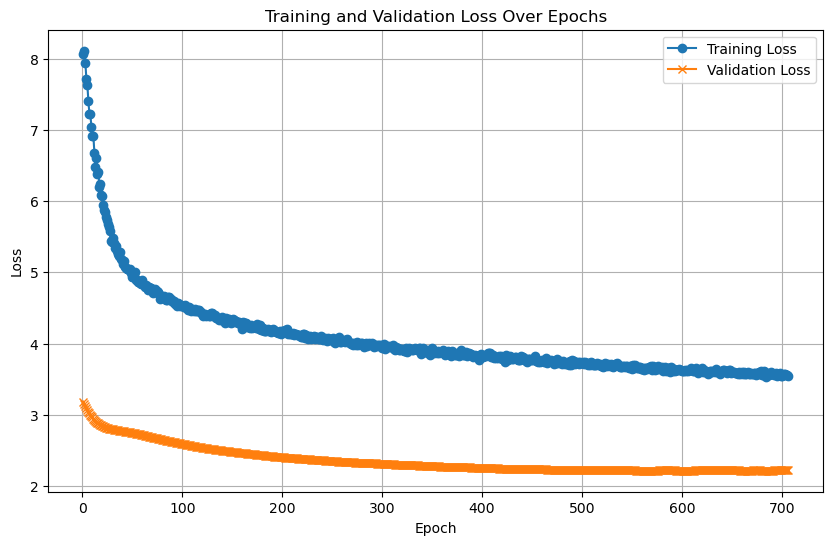

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/209], Loss: 4.4752
Test Batch [20/209], Loss: 4.7348
Test Batch [30/209], Loss: 4.8023
Test Batch [40/209], Loss: 5.1938
Test Batch [50/209], Loss: 4.8147
Test Batch [60/209], Loss: 4.7880
Test Batch [70/209], Loss: 4.8794
Test Batch [80/209], Loss: 4.4862
Test Batch [90/209], Loss: 4.5113
Test Batch [100/209], Loss: 4.5297
Test Batch [110/209], Loss: 4.8204
Test Batch [120/209], Loss: 5.2965
Test Batch [130/209], Loss: 4.5444
Test Batch [140/209], Loss: 4.5468
Test Batch [150/209], Loss: 4.5243
Test Batch [160/209], Loss: 4.4500


Test Batch [170/209], Loss: 4.4990
Test Batch [180/209], Loss: 4.4013
Test Batch [190/209], Loss: 4.4501
Test Batch [200/209], Loss: 4.3855

Test Loss: 4.6424


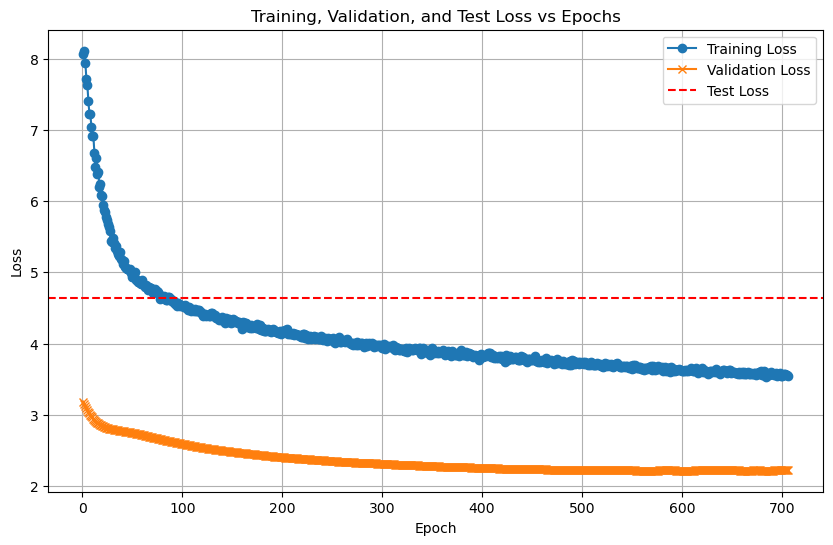

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.


  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.
  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.


  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.


  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.
  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.


  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.


  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      0.80      0.89         5
           9       1.00      0.80      0.89         5
          10       0.67      0.80      0.73         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7254  |  Val Loss: 2.6901
Validation loss improved from inf to 2.6901.
[Epoch 2/1000] Train Loss: 2.6367  |  Val Loss: 2.6074
Validation loss improved from 2.6901 to 2.6074.
[Epoch 3/1000] Train Loss: 2.5635  |  Val Loss: 2.5449
Validation loss improved from 2.6074 to 2.5449.
[Epoch 4/1000] Train Loss: 2.5038  |  Val Loss: 2.4922
Validation loss improved from 2.5449 to 2.4922.
[Epoch 5/1000] Train Loss: 2.4487  |  Val Loss: 2.4426
Validation loss improved from 2.4922 to 2.4426.
[Epoch 6/1000] Train Loss: 2.3976  |  Val Loss: 2.3962
Validation loss improved from 2.4426 to 2.3962.
[Epoch 7/1000] Train Loss: 2.3485  |  Val Loss: 2.3515
Validation loss improved from 2.3962 to 2.3515.
[Epoch 8/1000] Train Loss: 2.3010  |  Val Loss: 2.3085
Validation loss improved from 2.3515 to 2.3085.
[Epoch 9/1000] Train Loss: 2.2569  |  Val Loss: 2.2665
Validation loss improved from 2.3085 to 2.2665.
[Epoch 10/1000] Train Loss: 2.2137  |  Val Loss: 2.2257
Validation loss impr

[Epoch 11/1000] Train Loss: 2.1733  |  Val Loss: 2.1863
Validation loss improved from 2.2257 to 2.1863.
[Epoch 12/1000] Train Loss: 2.1324  |  Val Loss: 2.1484
Validation loss improved from 2.1863 to 2.1484.
[Epoch 13/1000] Train Loss: 2.0940  |  Val Loss: 2.1111
Validation loss improved from 2.1484 to 2.1111.
[Epoch 14/1000] Train Loss: 2.0563  |  Val Loss: 2.0752
Validation loss improved from 2.1111 to 2.0752.
[Epoch 15/1000] Train Loss: 2.0200  |  Val Loss: 2.0392
Validation loss improved from 2.0752 to 2.0392.
[Epoch 16/1000] Train Loss: 1.9830  |  Val Loss: 2.0048
Validation loss improved from 2.0392 to 2.0048.
[Epoch 17/1000] Train Loss: 1.9478  |  Val Loss: 1.9698
Validation loss improved from 2.0048 to 1.9698.
[Epoch 18/1000] Train Loss: 1.9129  |  Val Loss: 1.9361
Validation loss improved from 1.9698 to 1.9361.
[Epoch 19/1000] Train Loss: 1.8783  |  Val Loss: 1.9033
Validation loss improved from 1.9361 to 1.9033.
[Epoch 20/1000] Train Loss: 1.8442  |  Val Loss: 1.8700
Validati

[Epoch 22/1000] Train Loss: 1.7756  |  Val Loss: 1.8030
Validation loss improved from 1.8365 to 1.8030.
[Epoch 23/1000] Train Loss: 1.7416  |  Val Loss: 1.7707
Validation loss improved from 1.8030 to 1.7707.
[Epoch 24/1000] Train Loss: 1.7087  |  Val Loss: 1.7388
Validation loss improved from 1.7707 to 1.7388.
[Epoch 25/1000] Train Loss: 1.6765  |  Val Loss: 1.7071
Validation loss improved from 1.7388 to 1.7071.
[Epoch 26/1000] Train Loss: 1.6446  |  Val Loss: 1.6778
Validation loss improved from 1.7071 to 1.6778.
[Epoch 27/1000] Train Loss: 1.6133  |  Val Loss: 1.6480
Validation loss improved from 1.6778 to 1.6480.
[Epoch 28/1000] Train Loss: 1.5819  |  Val Loss: 1.6188
Validation loss improved from 1.6480 to 1.6188.
[Epoch 29/1000] Train Loss: 1.5510  |  Val Loss: 1.5887
Validation loss improved from 1.6188 to 1.5887.
[Epoch 30/1000] Train Loss: 1.5195  |  Val Loss: 1.5592
Validation loss improved from 1.5887 to 1.5592.
[Epoch 31/1000] Train Loss: 1.4883  |  Val Loss: 1.5302
Validati

[Epoch 33/1000] Train Loss: 1.4263  |  Val Loss: 1.4708
Validation loss improved from 1.5007 to 1.4708.
[Epoch 34/1000] Train Loss: 1.3953  |  Val Loss: 1.4406
Validation loss improved from 1.4708 to 1.4406.
[Epoch 35/1000] Train Loss: 1.3630  |  Val Loss: 1.4107
Validation loss improved from 1.4406 to 1.4107.
[Epoch 36/1000] Train Loss: 1.3311  |  Val Loss: 1.3808
Validation loss improved from 1.4107 to 1.3808.
[Epoch 37/1000] Train Loss: 1.2990  |  Val Loss: 1.3507
Validation loss improved from 1.3808 to 1.3507.
[Epoch 38/1000] Train Loss: 1.2665  |  Val Loss: 1.3206
Validation loss improved from 1.3507 to 1.3206.
[Epoch 39/1000] Train Loss: 1.2341  |  Val Loss: 1.2921
Validation loss improved from 1.3206 to 1.2921.
[Epoch 40/1000] Train Loss: 1.2031  |  Val Loss: 1.2630
Validation loss improved from 1.2921 to 1.2630.
[Epoch 41/1000] Train Loss: 1.1719  |  Val Loss: 1.2333
Validation loss improved from 1.2630 to 1.2333.
[Epoch 42/1000] Train Loss: 1.1423  |  Val Loss: 1.2056
Validati

[Epoch 44/1000] Train Loss: 1.0813  |  Val Loss: 1.1508
Validation loss improved from 1.1776 to 1.1508.
[Epoch 45/1000] Train Loss: 1.0520  |  Val Loss: 1.1222
Validation loss improved from 1.1508 to 1.1222.
[Epoch 46/1000] Train Loss: 1.0218  |  Val Loss: 1.0948
Validation loss improved from 1.1222 to 1.0948.
[Epoch 47/1000] Train Loss: 0.9919  |  Val Loss: 1.0667
Validation loss improved from 1.0948 to 1.0667.
[Epoch 48/1000] Train Loss: 0.9623  |  Val Loss: 1.0393
Validation loss improved from 1.0667 to 1.0393.
[Epoch 49/1000] Train Loss: 0.9334  |  Val Loss: 1.0124
Validation loss improved from 1.0393 to 1.0124.
[Epoch 50/1000] Train Loss: 0.9048  |  Val Loss: 0.9879
Validation loss improved from 1.0124 to 0.9879.
[Epoch 51/1000] Train Loss: 0.8775  |  Val Loss: 0.9619
Validation loss improved from 0.9879 to 0.9619.
[Epoch 52/1000] Train Loss: 0.8504  |  Val Loss: 0.9366
Validation loss improved from 0.9619 to 0.9366.
[Epoch 53/1000] Train Loss: 0.8243  |  Val Loss: 0.9123
Validati

[Epoch 54/1000] Train Loss: 0.7995  |  Val Loss: 0.8889
Validation loss improved from 0.9123 to 0.8889.
[Epoch 55/1000] Train Loss: 0.7746  |  Val Loss: 0.8678
Validation loss improved from 0.8889 to 0.8678.
[Epoch 56/1000] Train Loss: 0.7510  |  Val Loss: 0.8455
Validation loss improved from 0.8678 to 0.8455.
[Epoch 57/1000] Train Loss: 0.7281  |  Val Loss: 0.8257
Validation loss improved from 0.8455 to 0.8257.
[Epoch 58/1000] Train Loss: 0.7061  |  Val Loss: 0.8040
Validation loss improved from 0.8257 to 0.8040.
[Epoch 59/1000] Train Loss: 0.6846  |  Val Loss: 0.7852
Validation loss improved from 0.8040 to 0.7852.
[Epoch 60/1000] Train Loss: 0.6649  |  Val Loss: 0.7680
Validation loss improved from 0.7852 to 0.7680.
[Epoch 61/1000] Train Loss: 0.6449  |  Val Loss: 0.7517
Validation loss improved from 0.7680 to 0.7517.
[Epoch 62/1000] Train Loss: 0.6261  |  Val Loss: 0.7359
Validation loss improved from 0.7517 to 0.7359.
[Epoch 63/1000] Train Loss: 0.6086  |  Val Loss: 0.7237
Validati

[Epoch 64/1000] Train Loss: 0.5906  |  Val Loss: 0.7063
Validation loss improved from 0.7237 to 0.7063.
[Epoch 65/1000] Train Loss: 0.5746  |  Val Loss: 0.6933
Validation loss improved from 0.7063 to 0.6933.
[Epoch 66/1000] Train Loss: 0.5583  |  Val Loss: 0.6825
Validation loss improved from 0.6933 to 0.6825.
[Epoch 67/1000] Train Loss: 0.5427  |  Val Loss: 0.6708
Validation loss improved from 0.6825 to 0.6708.
[Epoch 68/1000] Train Loss: 0.5285  |  Val Loss: 0.6571
Validation loss improved from 0.6708 to 0.6571.
[Epoch 69/1000] Train Loss: 0.5139  |  Val Loss: 0.6464
Validation loss improved from 0.6571 to 0.6464.
[Epoch 70/1000] Train Loss: 0.5003  |  Val Loss: 0.6363
Validation loss improved from 0.6464 to 0.6363.
[Epoch 71/1000] Train Loss: 0.4873  |  Val Loss: 0.6231
Validation loss improved from 0.6363 to 0.6231.
[Epoch 72/1000] Train Loss: 0.4748  |  Val Loss: 0.6122
Validation loss improved from 0.6231 to 0.6122.
[Epoch 73/1000] Train Loss: 0.4627  |  Val Loss: 0.6074
Validati

[Epoch 74/1000] Train Loss: 0.4510  |  Val Loss: 0.6004
Validation loss improved from 0.6074 to 0.6004.
[Epoch 75/1000] Train Loss: 0.4395  |  Val Loss: 0.5894
Validation loss improved from 0.6004 to 0.5894.
[Epoch 76/1000] Train Loss: 0.4285  |  Val Loss: 0.5807
Validation loss improved from 0.5894 to 0.5807.
[Epoch 77/1000] Train Loss: 0.4181  |  Val Loss: 0.5732
Validation loss improved from 0.5807 to 0.5732.
[Epoch 78/1000] Train Loss: 0.4084  |  Val Loss: 0.5682
Validation loss improved from 0.5732 to 0.5682.
[Epoch 79/1000] Train Loss: 0.3988  |  Val Loss: 0.5598
Validation loss improved from 0.5682 to 0.5598.
[Epoch 80/1000] Train Loss: 0.3890  |  Val Loss: 0.5529
Validation loss improved from 0.5598 to 0.5529.
[Epoch 81/1000] Train Loss: 0.3800  |  Val Loss: 0.5476
Validation loss improved from 0.5529 to 0.5476.
[Epoch 82/1000] Train Loss: 0.3723  |  Val Loss: 0.5365
Validation loss improved from 0.5476 to 0.5365.
[Epoch 83/1000] Train Loss: 0.3631  |  Val Loss: 0.5344
Validati

[Epoch 84/1000] Train Loss: 0.3558  |  Val Loss: 0.5313
Validation loss improved from 0.5344 to 0.5313.
[Epoch 85/1000] Train Loss: 0.3479  |  Val Loss: 0.5242
Validation loss improved from 0.5313 to 0.5242.
[Epoch 86/1000] Train Loss: 0.3399  |  Val Loss: 0.5201
Validation loss improved from 0.5242 to 0.5201.
[Epoch 87/1000] Train Loss: 0.3336  |  Val Loss: 0.5185
Validation loss improved from 0.5201 to 0.5185.
[Epoch 88/1000] Train Loss: 0.3262  |  Val Loss: 0.5134
Validation loss improved from 0.5185 to 0.5134.
[Epoch 89/1000] Train Loss: 0.3201  |  Val Loss: 0.5053
Validation loss improved from 0.5134 to 0.5053.
[Epoch 90/1000] Train Loss: 0.3130  |  Val Loss: 0.5027
Validation loss improved from 0.5053 to 0.5027.
[Epoch 91/1000] Train Loss: 0.3067  |  Val Loss: 0.5028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 92/1000] Train Loss: 0.3010  |  Val Loss: 0.4995
Validation loss improved from 0.5027 to 0.4995.
[Epoch 93/1000] Train Loss: 0.2952  |  Val Loss: 0.4942
Va

[Epoch 94/1000] Train Loss: 0.2894  |  Val Loss: 0.4911
Validation loss improved from 0.4942 to 0.4911.
[Epoch 95/1000] Train Loss: 0.2837  |  Val Loss: 0.4880
Validation loss improved from 0.4911 to 0.4880.
[Epoch 96/1000] Train Loss: 0.2779  |  Val Loss: 0.4889
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 0.2729  |  Val Loss: 0.4858
Validation loss improved from 0.4880 to 0.4858.
[Epoch 98/1000] Train Loss: 0.2679  |  Val Loss: 0.4810
Validation loss improved from 0.4858 to 0.4810.
[Epoch 99/1000] Train Loss: 0.2628  |  Val Loss: 0.4790
Validation loss improved from 0.4810 to 0.4790.
[Epoch 100/1000] Train Loss: 0.2587  |  Val Loss: 0.4752
Validation loss improved from 0.4790 to 0.4752.
[Epoch 101/1000] Train Loss: 0.2535  |  Val Loss: 0.4747
Validation loss improved from 0.4752 to 0.4747.
[Epoch 102/1000] Train Loss: 0.2497  |  Val Loss: 0.4734
Validation loss improved from 0.4747 to 0.4734.
[Epoch 103/1000] Train Loss: 0.2457  |  Val Loss: 0.474

[Epoch 105/1000] Train Loss: 0.2376  |  Val Loss: 0.4683
Validation loss improved from 0.4694 to 0.4683.
[Epoch 106/1000] Train Loss: 0.2338  |  Val Loss: 0.4677
Validation loss improved from 0.4683 to 0.4677.
[Epoch 107/1000] Train Loss: 0.2301  |  Val Loss: 0.4703
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 108/1000] Train Loss: 0.2269  |  Val Loss: 0.4660
Validation loss improved from 0.4677 to 0.4660.
[Epoch 109/1000] Train Loss: 0.2229  |  Val Loss: 0.4633
Validation loss improved from 0.4660 to 0.4633.
[Epoch 110/1000] Train Loss: 0.2199  |  Val Loss: 0.4608
Validation loss improved from 0.4633 to 0.4608.
[Epoch 111/1000] Train Loss: 0.2169  |  Val Loss: 0.4614
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.2134  |  Val Loss: 0.4613
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 0.2105  |  Val Loss: 0.4596
Validation loss improved from 0.4608 to 0.4596.
[Epoch 114/1000] Train Loss: 0.2076  

[Epoch 116/1000] Train Loss: 0.2027  |  Val Loss: 0.4584
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.1994  |  Val Loss: 0.4537
Validation loss improved from 0.4579 to 0.4537.
[Epoch 118/1000] Train Loss: 0.1977  |  Val Loss: 0.4560
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.1944  |  Val Loss: 0.4570
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 0.1925  |  Val Loss: 0.4607
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 0.1904  |  Val Loss: 0.4557
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 0.1879  |  Val Loss: 0.4572
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 0.1858  |  Val Loss: 0.4573
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Train Loss: 0.1837  |  Val Loss: 0.4582
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 126/1000] Train Loss: 0.1800  |  Val Loss: 0.4616
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 127/1000] Train Loss: 0.1779  |  Val Loss: 0.4577
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 0.1759  |  Val Loss: 0.4580
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 129/1000] Train Loss: 0.1747  |  Val Loss: 0.4637
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 130/1000] Train Loss: 0.1722  |  Val Loss: 0.4648
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 131/1000] Train Loss: 0.1705  |  Val Loss: 0.4626
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 132/1000] Train Loss: 0.1687  |  Val Loss: 0.4634
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 133/1000] Train Loss: 0.1679  |  Val Loss: 0.4672
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 134/1000] Train Loss: 0.1668  |  Val Loss: 0.4610
!! Validation loss did NOT improve !! Patience: 

[Epoch 136/1000] Train Loss: 0.1629  |  Val Loss: 0.4658
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 137/1000] Train Loss: 0.1612  |  Val Loss: 0.4698
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 138/1000] Train Loss: 0.1597  |  Val Loss: 0.4699
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 139/1000] Train Loss: 0.1587  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 140/1000] Train Loss: 0.1573  |  Val Loss: 0.4704
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 141/1000] Train Loss: 0.1564  |  Val Loss: 0.4672
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 142/1000] Train Loss: 0.1550  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 143/1000] Train Loss: 0.1535  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 144/1000] Train Loss: 0.1522  |  Val Loss: 0.4734
!! Validation loss did NOT improve !! Patience:

[Epoch 146/1000] Train Loss: 0.1496  |  Val Loss: 0.4770
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 147/1000] Train Loss: 0.1488  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 148/1000] Train Loss: 0.1478  |  Val Loss: 0.4779
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 149/1000] Train Loss: 0.1464  |  Val Loss: 0.4755
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 150/1000] Train Loss: 0.1459  |  Val Loss: 0.4835
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 151/1000] Train Loss: 0.1446  |  Val Loss: 0.4776
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 152/1000] Train Loss: 0.1439  |  Val Loss: 0.4800
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 153/1000] Train Loss: 0.1425  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 154/1000] Train Loss: 0.1418  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience:

[Epoch 157/1000] Train Loss: 0.1389  |  Val Loss: 0.4873
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 158/1000] Train Loss: 0.1380  |  Val Loss: 0.4904
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 159/1000] Train Loss: 0.1370  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 160/1000] Train Loss: 0.1363  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 161/1000] Train Loss: 0.1354  |  Val Loss: 0.4866
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 162/1000] Train Loss: 0.1344  |  Val Loss: 0.4972
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 163/1000] Train Loss: 0.1334  |  Val Loss: 0.4974
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 164/1000] Train Loss: 0.1333  |  Val Loss: 0.4941
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 165/1000] Train Loss: 0.1317  |  Val Loss: 0.5002
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.1295  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 169/1000] Train Loss: 0.1290  |  Val Loss: 0.5030
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 170/1000] Train Loss: 0.1281  |  Val Loss: 0.5037
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 171/1000] Train Loss: 0.1273  |  Val Loss: 0.5070
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 172/1000] Train Loss: 0.1271  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 173/1000] Train Loss: 0.1265  |  Val Loss: 0.5052
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 174/1000] Train Loss: 0.1255  |  Val Loss: 0.5087
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 175/1000] Train Loss: 0.1247  |  Val Loss: 0.5130
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 176/1000] Train Loss: 0.1243  |  Val Loss: 0.5118
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.1224  |  Val Loss: 0.5208
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 180/1000] Train Loss: 0.1220  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 181/1000] Train Loss: 0.1210  |  Val Loss: 0.5201
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 182/1000] Train Loss: 0.1215  |  Val Loss: 0.5204
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 183/1000] Train Loss: 0.1201  |  Val Loss: 0.5260
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 184/1000] Train Loss: 0.1201  |  Val Loss: 0.5263
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 185/1000] Train Loss: 0.1198  |  Val Loss: 0.5324
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 186/1000] Train Loss: 0.1184  |  Val Loss: 0.5311
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 187/1000] Train Loss: 0.1177  |  Val Loss: 0.5295
!! Validation loss did NOT improve !! Patience:

[Epoch 189/1000] Train Loss: 0.1166  |  Val Loss: 0.5356
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 190/1000] Train Loss: 0.1162  |  Val Loss: 0.5419
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 191/1000] Train Loss: 0.1163  |  Val Loss: 0.5416
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 192/1000] Train Loss: 0.1150  |  Val Loss: 0.5369
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 193/1000] Train Loss: 0.1149  |  Val Loss: 0.5365
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 194/1000] Train Loss: 0.1146  |  Val Loss: 0.5450
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 195/1000] Train Loss: 0.1138  |  Val Loss: 0.5480
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 196/1000] Train Loss: 0.1137  |  Val Loss: 0.5427
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 197/1000] Train Loss: 0.1129  |  Val Loss: 0.5474
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.1113  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 202/1000] Train Loss: 0.1116  |  Val Loss: 0.5548
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 203/1000] Train Loss: 0.1110  |  Val Loss: 0.5622
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 204/1000] Train Loss: 0.1098  |  Val Loss: 0.5577
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 205/1000] Train Loss: 0.1095  |  Val Loss: 0.5586
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 206/1000] Train Loss: 0.1093  |  Val Loss: 0.5634
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 207/1000] Train Loss: 0.1098  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 208/1000] Train Loss: 0.1079  |  Val Loss: 0.5657
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 209/1000] Train Loss: 0.1074  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience:

[Epoch 211/1000] Train Loss: 0.1068  |  Val Loss: 0.5696
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 212/1000] Train Loss: 0.1071  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 213/1000] Train Loss: 0.1062  |  Val Loss: 0.5747
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 214/1000] Train Loss: 0.1062  |  Val Loss: 0.5755
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 215/1000] Train Loss: 0.1057  |  Val Loss: 0.5758
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 216/1000] Train Loss: 0.1051  |  Val Loss: 0.5837
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 217/1000] Train Loss: 0.1048  |  Val Loss: 0.5804
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 217 !!
No improvement for 100 epochs.


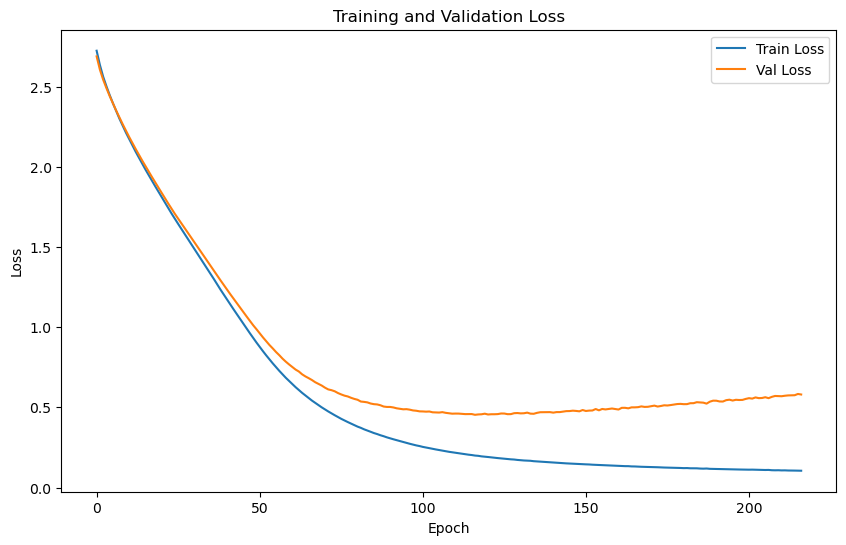

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4900 | Test Accuracy: 83.76%


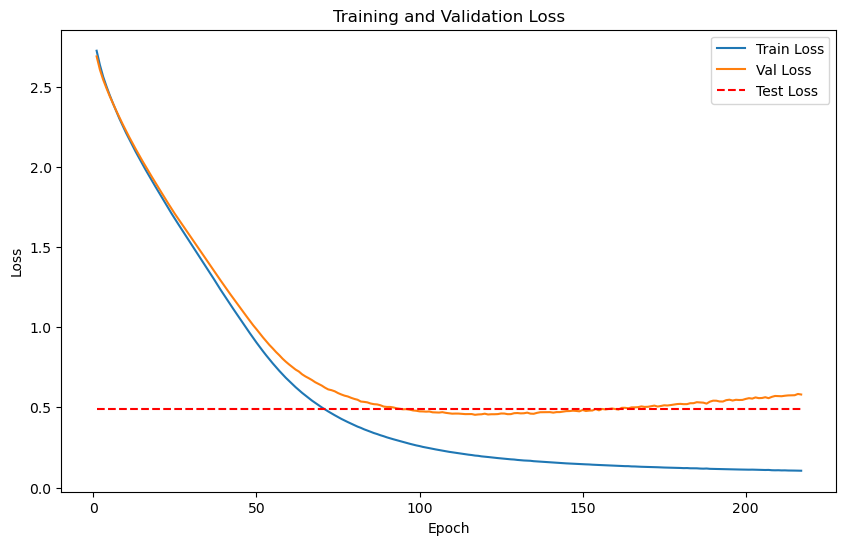

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4607


    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3176
    Batch [2/2], Val Loss: 0.3628
Epoch [1/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.3402

Validation loss improved from inf to 0.3402. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4597


    Batch [2/2], Train Loss: 0.4580
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3174
    Batch [2/2], Val Loss: 0.3565
Epoch [2/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.3370

Validation loss improved from 0.3402 to 0.3370. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4545


    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3172
    Batch [2/2], Val Loss: 0.3469
Epoch [3/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3321

Validation loss improved from 0.3370 to 0.3321. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4523


    Batch [2/2], Train Loss: 0.4586
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.3377
Epoch [4/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3270

Validation loss improved from 0.3321 to 0.3270. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4520


    Batch [2/2], Train Loss: 0.4413
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3161
    Batch [2/2], Val Loss: 0.3284
Epoch [5/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3222

Validation loss improved from 0.3270 to 0.3222. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4533


    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3173
    Batch [2/2], Val Loss: 0.3188
Epoch [6/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3180

Validation loss improved from 0.3222 to 0.3180. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4449


    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.3107
Epoch [7/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3146

Validation loss improved from 0.3180 to 0.3146. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4503


    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3182
    Batch [2/2], Val Loss: 0.3045
Epoch [8/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3114

Validation loss improved from 0.3146 to 0.3114. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4464


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3169
    Batch [2/2], Val Loss: 0.3002
Epoch [9/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3085

Validation loss improved from 0.3114 to 0.3085. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4433


    Batch [2/2], Train Loss: 0.4424
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3151
    Batch [2/2], Val Loss: 0.2965
Epoch [10/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3058

Validation loss improved from 0.3085 to 0.3058. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4474


    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3134
    Batch [2/2], Val Loss: 0.2940
Epoch [11/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3037

Validation loss improved from 0.3058 to 0.3037. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4425


    Batch [2/2], Train Loss: 0.4419
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.2920
Epoch [12/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3018

Validation loss improved from 0.3037 to 0.3018. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4404


    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3103
    Batch [2/2], Val Loss: 0.2902
Epoch [13/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3003

Validation loss improved from 0.3018 to 0.3003. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4381


    Batch [2/2], Train Loss: 0.4343
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.2886
Epoch [14/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2988

Validation loss improved from 0.3003 to 0.2988. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4376


    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.2870
Epoch [15/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2974

Validation loss improved from 0.2988 to 0.2974. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4350


    Batch [2/2], Train Loss: 0.4364
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.2856
Epoch [16/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2961

Validation loss improved from 0.2974 to 0.2961. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4368


    Batch [2/2], Train Loss: 0.4248
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3053
    Batch [2/2], Val Loss: 0.2844
Epoch [17/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2948

Validation loss improved from 0.2961 to 0.2948. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4353


    Batch [2/2], Train Loss: 0.4394
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.2831
Epoch [18/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2935

Validation loss improved from 0.2948 to 0.2935. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4307


    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3028
    Batch [2/2], Val Loss: 0.2816
Epoch [19/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2922

Validation loss improved from 0.2935 to 0.2922. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4270


    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3017
    Batch [2/2], Val Loss: 0.2803
Epoch [20/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2910

Validation loss improved from 0.2922 to 0.2910. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4291
    Batch [2/2], Train Loss: 0.4296
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.2790
Epoch [21/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2898

Validation loss improved from 0.2910 to 0.2898. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4310


    Batch [2/2], Train Loss: 0.4282
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.2995
    Batch [2/2], Val Loss: 0.2776
Epoch [22/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2885

Validation loss improved from 0.2898 to 0.2885. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4274


    Batch [2/2], Train Loss: 0.4301
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.2761
Epoch [23/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2872

Validation loss improved from 0.2885 to 0.2872. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4252


    Batch [2/2], Train Loss: 0.4202
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.2747
Epoch [24/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2861

Validation loss improved from 0.2872 to 0.2861. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4245
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.2964
    Batch [2/2], Val Loss: 0.2737
Epoch [25/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2851

Validation loss improved from 0.2861 to 0.2851. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4286


    Batch [2/2], Train Loss: 0.4242
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.2724
Epoch [26/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2839

Validation loss improved from 0.2851 to 0.2839. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4232


    Batch [2/2], Train Loss: 0.4205
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.2942
    Batch [2/2], Val Loss: 0.2712
Epoch [27/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2827

Validation loss improved from 0.2839 to 0.2827. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4235


    Batch [2/2], Train Loss: 0.4211
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.2699
Epoch [28/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2814

Validation loss improved from 0.2827 to 0.2814. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4172


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.2690
Epoch [29/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2805

Validation loss improved from 0.2814 to 0.2805. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4229


    Batch [2/2], Train Loss: 0.4181
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2909
    Batch [2/2], Val Loss: 0.2680
Epoch [30/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2794

Validation loss improved from 0.2805 to 0.2794. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4138


    Batch [2/2], Train Loss: 0.4170
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2900
    Batch [2/2], Val Loss: 0.2671
Epoch [31/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2786

Validation loss improved from 0.2794 to 0.2786. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4192


    Batch [2/2], Train Loss: 0.4115
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2660
Epoch [32/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2774

Validation loss improved from 0.2786 to 0.2774. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4150
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.2650
Epoch [33/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2764

Validation loss improved from 0.2774 to 0.2764. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4080


    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2868
    Batch [2/2], Val Loss: 0.2639
Epoch [34/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2754

Validation loss improved from 0.2764 to 0.2754. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4140
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2860
    Batch [2/2], Val Loss: 0.2630
Epoch [35/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2745

Validation loss improved from 0.2754 to 0.2745. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4155


    Batch [2/2], Train Loss: 0.4120
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.2619
Epoch [36/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2734

Validation loss improved from 0.2745 to 0.2734. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4108


    Batch [2/2], Train Loss: 0.4096
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.2608
Epoch [37/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2726

Validation loss improved from 0.2734 to 0.2726. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4104


    Batch [2/2], Train Loss: 0.4025
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2598
Epoch [38/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2715

Validation loss improved from 0.2726 to 0.2715. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4165


    Batch [2/2], Train Loss: 0.4065
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2823
    Batch [2/2], Val Loss: 0.2583
Epoch [39/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2703

Validation loss improved from 0.2715 to 0.2703. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4034


    Batch [2/2], Train Loss: 0.3991
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.2570
Epoch [40/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2691

Validation loss improved from 0.2703 to 0.2691. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.3968


    Batch [2/2], Train Loss: 0.4030
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.2556
Epoch [41/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2678

Validation loss improved from 0.2691 to 0.2678. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4026


    Batch [2/2], Train Loss: 0.4050
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2790
    Batch [2/2], Val Loss: 0.2544
Epoch [42/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2667

Validation loss improved from 0.2678 to 0.2667. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.3956


    Batch [2/2], Train Loss: 0.4011
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.2532
Epoch [43/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2657

Validation loss improved from 0.2667 to 0.2657. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4036


    Batch [2/2], Train Loss: 0.4055
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.2522
Epoch [44/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2649

Validation loss improved from 0.2657 to 0.2649. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4002


    Batch [2/2], Train Loss: 0.3945
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.2511
Epoch [45/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2639

Validation loss improved from 0.2649 to 0.2639. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3960


    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.2500
Epoch [46/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2630

Validation loss improved from 0.2639 to 0.2630. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.4038


    Batch [2/2], Train Loss: 0.3958
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.2490
Epoch [47/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2622

Validation loss improved from 0.2630 to 0.2622. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.3999


    Batch [2/2], Train Loss: 0.4003
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2747
    Batch [2/2], Val Loss: 0.2478
Epoch [48/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2612

Validation loss improved from 0.2622 to 0.2612. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4026


    Batch [2/2], Train Loss: 0.4001
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2739
    Batch [2/2], Val Loss: 0.2465
Epoch [49/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2602

Validation loss improved from 0.2612 to 0.2602. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3892


    Batch [2/2], Train Loss: 0.3985
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.2456
Epoch [50/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2594

Validation loss improved from 0.2602 to 0.2594. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.4012


    Batch [2/2], Train Loss: 0.3963
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.2445
Epoch [51/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2585

Validation loss improved from 0.2594 to 0.2585. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.3908


    Batch [2/2], Train Loss: 0.3960
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.2439
Epoch [52/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2578

Validation loss improved from 0.2585 to 0.2578. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3889


    Batch [2/2], Train Loss: 0.3957
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.2434
Epoch [53/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2572

Validation loss improved from 0.2578 to 0.2572. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4019


    Batch [2/2], Train Loss: 0.3856
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2704
    Batch [2/2], Val Loss: 0.2426
Epoch [54/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2565

Validation loss improved from 0.2572 to 0.2565. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3840
    Batch [2/2], Train Loss: 0.3974
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.2421
Epoch [55/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2560

Validation loss improved from 0.2565 to 0.2560. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3815


    Batch [2/2], Train Loss: 0.3884
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2693
    Batch [2/2], Val Loss: 0.2415
Epoch [56/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2554

Validation loss improved from 0.2560 to 0.2554. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3900


    Batch [2/2], Train Loss: 0.3935
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.2410
Epoch [57/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2548

Validation loss improved from 0.2554 to 0.2548. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3892


    Batch [2/2], Train Loss: 0.3931
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2679
    Batch [2/2], Val Loss: 0.2402
Epoch [58/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2541

Validation loss improved from 0.2548 to 0.2541. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3883


    Batch [2/2], Train Loss: 0.3839
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.2395
Epoch [59/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2532

Validation loss improved from 0.2541 to 0.2532. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3919


    Batch [2/2], Train Loss: 0.3838
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.2386
Epoch [60/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2525

Validation loss improved from 0.2532 to 0.2525. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3852


    Batch [2/2], Train Loss: 0.3782
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.2377
Epoch [61/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2516

Validation loss improved from 0.2525 to 0.2516. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3799


    Batch [2/2], Train Loss: 0.3906
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.2365
Epoch [62/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2506

Validation loss improved from 0.2516 to 0.2506. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3853


    Batch [2/2], Train Loss: 0.3848
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2640
    Batch [2/2], Val Loss: 0.2356
Epoch [63/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2498

Validation loss improved from 0.2506 to 0.2498. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3798


    Batch [2/2], Train Loss: 0.3829
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2634
    Batch [2/2], Val Loss: 0.2346
Epoch [64/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2490

Validation loss improved from 0.2498 to 0.2490. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3814


    Batch [2/2], Train Loss: 0.3773
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.2336
Epoch [65/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2482

Validation loss improved from 0.2490 to 0.2482. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3814


    Batch [2/2], Train Loss: 0.3805
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.2326
Epoch [66/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2473

Validation loss improved from 0.2482 to 0.2473. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3739


    Batch [2/2], Train Loss: 0.3754
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2615
    Batch [2/2], Val Loss: 0.2317
Epoch [67/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2466

Validation loss improved from 0.2473 to 0.2466. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3725


    Batch [2/2], Train Loss: 0.3852
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.2307
Epoch [68/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2458

Validation loss improved from 0.2466 to 0.2458. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3760


    Batch [2/2], Train Loss: 0.3782
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.2297
Epoch [69/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2448

Validation loss improved from 0.2458 to 0.2448. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3859


    Batch [2/2], Train Loss: 0.3778
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.2289
Epoch [70/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2441

Validation loss improved from 0.2448 to 0.2441. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3752


    Batch [2/2], Train Loss: 0.3792
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.2280
Epoch [71/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2433

Validation loss improved from 0.2441 to 0.2433. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3753


    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.2271
Epoch [72/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2425

Validation loss improved from 0.2433 to 0.2425. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3714


    Batch [2/2], Train Loss: 0.3709
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.2263
Epoch [73/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2419

Validation loss improved from 0.2425 to 0.2419. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3747


    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2568
    Batch [2/2], Val Loss: 0.2255
Epoch [74/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2412

Validation loss improved from 0.2419 to 0.2412. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3679
    Batch [2/2], Train Loss: 0.3649
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.2251
Epoch [75/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2407

Validation loss improved from 0.2412 to 0.2407. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3644


    Batch [2/2], Train Loss: 0.3651
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.2245
Epoch [76/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2402

Validation loss improved from 0.2407 to 0.2402. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3640


    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.2239
Epoch [77/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2397

Validation loss improved from 0.2402 to 0.2397. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3700


    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.2232
Epoch [78/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2391

Validation loss improved from 0.2397 to 0.2391. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3699


    Batch [2/2], Train Loss: 0.3748
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.2224
Epoch [79/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2385

Validation loss improved from 0.2391 to 0.2385. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3646


    Batch [2/2], Train Loss: 0.3567
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.2216
Epoch [80/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2379

Validation loss improved from 0.2385 to 0.2379. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3657


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.2209
Epoch [81/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2373

Validation loss improved from 0.2379 to 0.2373. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3669


    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.2201
Epoch [82/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2365

Validation loss improved from 0.2373 to 0.2365. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3625


    Batch [2/2], Train Loss: 0.3585
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.2191
Epoch [83/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2356

Validation loss improved from 0.2365 to 0.2356. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3664


    Batch [2/2], Train Loss: 0.3545
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.2182
Epoch [84/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2349

Validation loss improved from 0.2356 to 0.2349. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3615


    Batch [2/2], Train Loss: 0.3638
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.2173
Epoch [85/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2341

Validation loss improved from 0.2349 to 0.2341. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3584


    Batch [2/2], Train Loss: 0.3603
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2165
Epoch [86/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2335

Validation loss improved from 0.2341 to 0.2335. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3626


    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2501
    Batch [2/2], Val Loss: 0.2160
Epoch [87/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2330

Validation loss improved from 0.2335 to 0.2330. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3689
    Batch [2/2], Train Loss: 0.3614
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.2152
Epoch [88/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2324

Validation loss improved from 0.2330 to 0.2324. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3648


    Batch [2/2], Train Loss: 0.3586
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.2146
Epoch [89/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2320

Validation loss improved from 0.2324 to 0.2320. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3526


    Batch [2/2], Train Loss: 0.3614
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.2143
Epoch [90/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.2316

Validation loss improved from 0.2320 to 0.2316. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3523


    Batch [2/2], Train Loss: 0.3524
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2138
Epoch [91/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2312

Validation loss improved from 0.2316 to 0.2312. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3501


    Batch [2/2], Train Loss: 0.3536
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2133
Epoch [92/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2307

Validation loss improved from 0.2312 to 0.2307. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3604


    Batch [2/2], Train Loss: 0.3554
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2475
    Batch [2/2], Val Loss: 0.2129
Epoch [93/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2302

Validation loss improved from 0.2307 to 0.2302. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3535


    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2468
    Batch [2/2], Val Loss: 0.2123
Epoch [94/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2296

Validation loss improved from 0.2302 to 0.2296. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3586


    Batch [2/2], Train Loss: 0.3481
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2463
    Batch [2/2], Val Loss: 0.2118
Epoch [95/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2290

Validation loss improved from 0.2296 to 0.2290. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3513


    Batch [2/2], Train Loss: 0.3494
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2458
    Batch [2/2], Val Loss: 0.2111
Epoch [96/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2284

Validation loss improved from 0.2290 to 0.2284. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3528


    Batch [2/2], Train Loss: 0.3605
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2456
    Batch [2/2], Val Loss: 0.2103
Epoch [97/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2279

Validation loss improved from 0.2284 to 0.2279. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3459


    Batch [2/2], Train Loss: 0.3389
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2450
    Batch [2/2], Val Loss: 0.2092
Epoch [98/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2271

Validation loss improved from 0.2279 to 0.2271. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3429


    Batch [2/2], Train Loss: 0.3533
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2447
    Batch [2/2], Val Loss: 0.2085
Epoch [99/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2266

Validation loss improved from 0.2271 to 0.2266. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3443


    Batch [2/2], Train Loss: 0.3548
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.2080
Epoch [100/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2263

Validation loss improved from 0.2266 to 0.2263. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3492


    Batch [2/2], Train Loss: 0.3515
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.2074
Epoch [101/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2259

Validation loss improved from 0.2263 to 0.2259. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3469


    Batch [2/2], Train Loss: 0.3509
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2442
    Batch [2/2], Val Loss: 0.2070
Epoch [102/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2256

Validation loss improved from 0.2259 to 0.2256. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3494


    Batch [2/2], Train Loss: 0.3529
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.2065
Epoch [103/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2252

Validation loss improved from 0.2256 to 0.2252. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3446


    Batch [2/2], Train Loss: 0.3452
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.2058
Epoch [104/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2248

Validation loss improved from 0.2252 to 0.2248. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3535


    Batch [2/2], Train Loss: 0.3408
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2432
    Batch [2/2], Val Loss: 0.2050
Epoch [105/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2241

Validation loss improved from 0.2248 to 0.2241. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3427


    Batch [2/2], Train Loss: 0.3474
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.2043
Epoch [106/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2234

Validation loss improved from 0.2241 to 0.2234. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3417


    Batch [2/2], Train Loss: 0.3403
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2421
    Batch [2/2], Val Loss: 0.2038
Epoch [107/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2230

Validation loss improved from 0.2234 to 0.2230. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3413


    Batch [2/2], Train Loss: 0.3344
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2417
    Batch [2/2], Val Loss: 0.2033
Epoch [108/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2225

Validation loss improved from 0.2230 to 0.2225. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3449


    Batch [2/2], Train Loss: 0.3422
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.2027
Epoch [109/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2220

Validation loss improved from 0.2225 to 0.2220. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3453


    Batch [2/2], Train Loss: 0.3465
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2408
    Batch [2/2], Val Loss: 0.2022
Epoch [110/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2215

Validation loss improved from 0.2220 to 0.2215. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3426


    Batch [2/2], Train Loss: 0.3352
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2406
    Batch [2/2], Val Loss: 0.2015
Epoch [111/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2210

Validation loss improved from 0.2215 to 0.2210. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3458


    Batch [2/2], Train Loss: 0.3396
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2401
    Batch [2/2], Val Loss: 0.2006
Epoch [112/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2203

Validation loss improved from 0.2210 to 0.2203. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3330


    Batch [2/2], Train Loss: 0.3450
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2395
    Batch [2/2], Val Loss: 0.2001
Epoch [113/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2198

Validation loss improved from 0.2203 to 0.2198. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3298


    Batch [2/2], Train Loss: 0.3399
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2389
    Batch [2/2], Val Loss: 0.1995
Epoch [114/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2192

Validation loss improved from 0.2198 to 0.2192. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3380


    Batch [2/2], Train Loss: 0.3391
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2382
    Batch [2/2], Val Loss: 0.1987
Epoch [115/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2185

Validation loss improved from 0.2192 to 0.2185. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3307


    Batch [2/2], Train Loss: 0.3319
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.1979
Epoch [116/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.2177

Validation loss improved from 0.2185 to 0.2177. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3323


    Batch [2/2], Train Loss: 0.3272
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.1971
Epoch [117/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2171

Validation loss improved from 0.2177 to 0.2171. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3312


    Batch [2/2], Train Loss: 0.3406
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2366
    Batch [2/2], Val Loss: 0.1965
Epoch [118/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2165

Validation loss improved from 0.2171 to 0.2165. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3358


    Batch [2/2], Train Loss: 0.3437
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.1957
Epoch [119/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2160

Validation loss improved from 0.2165 to 0.2160. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3274


    Batch [2/2], Train Loss: 0.3347
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.1951
Epoch [120/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2156

Validation loss improved from 0.2160 to 0.2156. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3322


    Batch [2/2], Train Loss: 0.3337
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2360
    Batch [2/2], Val Loss: 0.1948
Epoch [121/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2154

Validation loss improved from 0.2156 to 0.2154. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3361


    Batch [2/2], Train Loss: 0.3275
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2359
    Batch [2/2], Val Loss: 0.1947
Epoch [122/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3283


    Batch [2/2], Train Loss: 0.3293
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2357
    Batch [2/2], Val Loss: 0.1945
Epoch [123/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2151

Validation loss improved from 0.2153 to 0.2151. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3325


    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2353
    Batch [2/2], Val Loss: 0.1943
Epoch [124/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.2148

Validation loss improved from 0.2151 to 0.2148. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3317


    Batch [2/2], Train Loss: 0.3426
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2350
    Batch [2/2], Val Loss: 0.1942
Epoch [125/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2146

Validation loss improved from 0.2148 to 0.2146. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3378


    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2344
    Batch [2/2], Val Loss: 0.1943
Epoch [126/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2143

Validation loss improved from 0.2146 to 0.2143. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3250


    Batch [2/2], Train Loss: 0.3375
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.1939
Epoch [127/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2140

Validation loss improved from 0.2143 to 0.2140. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3364


    Batch [2/2], Train Loss: 0.3321
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2335
    Batch [2/2], Val Loss: 0.1936
Epoch [128/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2135

Validation loss improved from 0.2140 to 0.2135. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3379


    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.1930
Epoch [129/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2129

Validation loss improved from 0.2135 to 0.2129. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3281


    Batch [2/2], Train Loss: 0.3311
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.1927
Epoch [130/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2125

Validation loss improved from 0.2129 to 0.2125. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3210


    Batch [2/2], Train Loss: 0.3297
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.1919
Epoch [131/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2119

Validation loss improved from 0.2125 to 0.2119. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3063


    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.1910
Epoch [132/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2112

Validation loss improved from 0.2119 to 0.2112. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3262


    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.1901
Epoch [133/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2104

Validation loss improved from 0.2112 to 0.2104. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3318


    Batch [2/2], Train Loss: 0.3306
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.1894
Epoch [134/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2098

Validation loss improved from 0.2104 to 0.2098. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3380


    Batch [2/2], Train Loss: 0.3241
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.1886
Epoch [135/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.2091

Validation loss improved from 0.2098 to 0.2091. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3176
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.1876
Epoch [136/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.2084

Validation loss improved from 0.2091 to 0.2084. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3289


    Batch [2/2], Train Loss: 0.3249
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.1871
Epoch [137/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2080

Validation loss improved from 0.2084 to 0.2080. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3244


    Batch [2/2], Train Loss: 0.3174
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.1867
Epoch [138/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2077

Validation loss improved from 0.2080 to 0.2077. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3268


    Batch [2/2], Train Loss: 0.3275
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.1865
Epoch [139/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2075

Validation loss improved from 0.2077 to 0.2075. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3144
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.1864
Epoch [140/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2074

Validation loss improved from 0.2075 to 0.2074. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3295


    Batch [2/2], Train Loss: 0.3223
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.1863
Epoch [141/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2072

Validation loss improved from 0.2074 to 0.2072. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3178


    Batch [2/2], Train Loss: 0.3364
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.1862
Epoch [142/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2070

Validation loss improved from 0.2072 to 0.2070. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.3153


    Batch [2/2], Train Loss: 0.3143
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.1861
Epoch [143/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2068

Validation loss improved from 0.2070 to 0.2068. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3170


    Batch [2/2], Train Loss: 0.3254
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.1859
Epoch [144/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2068

Validation loss improved from 0.2068 to 0.2068. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3296


    Batch [2/2], Train Loss: 0.3147
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.1856
Epoch [145/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2066

Validation loss improved from 0.2068 to 0.2066. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3292


    Batch [2/2], Train Loss: 0.3292
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.1852
Epoch [146/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2062

Validation loss improved from 0.2066 to 0.2062. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3204


    Batch [2/2], Train Loss: 0.3125
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1844
Epoch [147/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2055

Validation loss improved from 0.2062 to 0.2055. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3177


    Batch [2/2], Train Loss: 0.3225
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.1839
Epoch [148/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2050

Validation loss improved from 0.2055 to 0.2050. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3214


    Batch [2/2], Train Loss: 0.3119
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.1832
Epoch [149/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2044

Validation loss improved from 0.2050 to 0.2044. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.3141


    Batch [2/2], Train Loss: 0.3178
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.1826
Epoch [150/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2038

Validation loss improved from 0.2044 to 0.2038. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3175


    Batch [2/2], Train Loss: 0.3077
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.1822
Epoch [151/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2032

Validation loss improved from 0.2038 to 0.2032. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.3217


    Batch [2/2], Train Loss: 0.3107
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.1815
Epoch [152/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2025

Validation loss improved from 0.2032 to 0.2025. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2227
    Batch [2/2], Val Loss: 0.1811
Epoch [153/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2019

Validation loss improved from 0.2025 to 0.2019. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3037


    Batch [2/2], Train Loss: 0.3137
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1808
Epoch [154/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.2015

Validation loss improved from 0.2019 to 0.2015. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.3125


    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.1805
Epoch [155/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2010

Validation loss improved from 0.2015 to 0.2010. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.3026


    Batch [2/2], Train Loss: 0.3106
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2214
    Batch [2/2], Val Loss: 0.1798
Epoch [156/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2006

Validation loss improved from 0.2010 to 0.2006. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3101


    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.1792
Epoch [157/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2002

Validation loss improved from 0.2006 to 0.2002. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3123


    Batch [2/2], Train Loss: 0.3114
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.1787
Epoch [158/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.1999

Validation loss improved from 0.2002 to 0.1999. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.3198


    Batch [2/2], Train Loss: 0.3041
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1781
Epoch [159/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.1996

Validation loss improved from 0.1999 to 0.1996. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3195


    Batch [2/2], Train Loss: 0.3110
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.1778
Epoch [160/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.1994

Validation loss improved from 0.1996 to 0.1994. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3034


    Batch [2/2], Train Loss: 0.2972
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2207
    Batch [2/2], Val Loss: 0.1773
Epoch [161/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.1990

Validation loss improved from 0.1994 to 0.1990. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3032


    Batch [2/2], Train Loss: 0.3071
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1769
Epoch [162/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.1986

Validation loss improved from 0.1990 to 0.1986. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3074


    Batch [2/2], Train Loss: 0.3133
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2201
    Batch [2/2], Val Loss: 0.1766
Epoch [163/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.1984

Validation loss improved from 0.1986 to 0.1984. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3060


    Batch [2/2], Train Loss: 0.3055
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1765
Epoch [164/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.1981

Validation loss improved from 0.1984 to 0.1981. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.3074


    Batch [2/2], Train Loss: 0.3020
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1759
Epoch [165/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.1976

Validation loss improved from 0.1981 to 0.1976. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.3037


    Batch [2/2], Train Loss: 0.3132
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1754
Epoch [166/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.1970

Validation loss improved from 0.1976 to 0.1970. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3004


    Batch [2/2], Train Loss: 0.3051
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1748
Epoch [167/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.1965

Validation loss improved from 0.1970 to 0.1965. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.3082


    Batch [2/2], Train Loss: 0.3070
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1743
Epoch [168/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.1960

Validation loss improved from 0.1965 to 0.1960. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.3128


    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.1738
Epoch [169/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.1956

Validation loss improved from 0.1960 to 0.1956. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2868


    Batch [2/2], Train Loss: 0.3022
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.1731
Epoch [170/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.1950

Validation loss improved from 0.1956 to 0.1950. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3049


    Batch [2/2], Train Loss: 0.3060
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.1725
Epoch [171/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.1946

Validation loss improved from 0.1950 to 0.1946. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3097


    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1720
Epoch [172/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.1942

Validation loss improved from 0.1946 to 0.1942. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.3057


    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1715
Epoch [173/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.1939

Validation loss improved from 0.1942 to 0.1939. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2922


    Batch [2/2], Train Loss: 0.2948
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.1712
Epoch [174/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.1939

Validation loss improved from 0.1939 to 0.1939. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2958


    Batch [2/2], Train Loss: 0.2990
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1707
Epoch [175/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.1935

Validation loss improved from 0.1939 to 0.1935. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.3135


    Batch [2/2], Train Loss: 0.3006
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1701
Epoch [176/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.1932

Validation loss improved from 0.1935 to 0.1932. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.3126


    Batch [2/2], Train Loss: 0.3004
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1697
Epoch [177/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.1929

Validation loss improved from 0.1932 to 0.1929. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2982


    Batch [2/2], Train Loss: 0.2942
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.1694
Epoch [178/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.1926

Validation loss improved from 0.1929 to 0.1926. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.2952


    Batch [2/2], Train Loss: 0.3039
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.1689
Epoch [179/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.1921

Validation loss improved from 0.1926 to 0.1921. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2983


    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2147
    Batch [2/2], Val Loss: 0.1682
Epoch [180/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.1915

Validation loss improved from 0.1921 to 0.1915. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2947


    Batch [2/2], Train Loss: 0.2991
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.1677
Epoch [181/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.1911

Validation loss improved from 0.1915 to 0.1911. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.3040


    Batch [2/2], Train Loss: 0.2940
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.1670
Epoch [182/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.1905

Validation loss improved from 0.1911 to 0.1905. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2968


    Batch [2/2], Train Loss: 0.2955
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.1668
Epoch [183/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.1903

Validation loss improved from 0.1905 to 0.1903. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.3047


    Batch [2/2], Train Loss: 0.2926
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1665
Epoch [184/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.1899

Validation loss improved from 0.1903 to 0.1899. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2900


    Batch [2/2], Train Loss: 0.2969
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1664
Epoch [185/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.1896

Validation loss improved from 0.1899 to 0.1896. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.3034


    Batch [2/2], Train Loss: 0.2837
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.1665
Epoch [186/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.1896

Validation loss improved from 0.1896 to 0.1896. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2893


    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.1668
Epoch [187/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.1896

Validation loss improved from 0.1896 to 0.1896. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2933


    Batch [2/2], Train Loss: 0.2955
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1667
Epoch [188/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.1893

Validation loss improved from 0.1896 to 0.1893. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2941


    Batch [2/2], Train Loss: 0.2982
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.1665
Epoch [189/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.1890

Validation loss improved from 0.1893 to 0.1890. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2894


    Batch [2/2], Train Loss: 0.2948
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1663
Epoch [190/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.1886

Validation loss improved from 0.1890 to 0.1886. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2948
    Batch [2/2], Train Loss: 0.2977
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1661
Epoch [191/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.1882

Validation loss improved from 0.1886 to 0.1882. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2949


    Batch [2/2], Train Loss: 0.2903
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.1655
Epoch [192/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.1878

Validation loss improved from 0.1882 to 0.1878. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2939


    Batch [2/2], Train Loss: 0.2945
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.1649
Epoch [193/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.1872

Validation loss improved from 0.1878 to 0.1872. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2917


    Batch [2/2], Train Loss: 0.2860
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1644
Epoch [194/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.1868

Validation loss improved from 0.1872 to 0.1868. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2934


    Batch [2/2], Train Loss: 0.2844
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2087
    Batch [2/2], Val Loss: 0.1639
Epoch [195/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.1863

Validation loss improved from 0.1868 to 0.1863. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2876


    Batch [2/2], Train Loss: 0.2902
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2080
    Batch [2/2], Val Loss: 0.1630
Epoch [196/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.1855

Validation loss improved from 0.1863 to 0.1855. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2873


    Batch [2/2], Train Loss: 0.2859
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2075
    Batch [2/2], Val Loss: 0.1621
Epoch [197/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.1848

Validation loss improved from 0.1855 to 0.1848. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2907


    Batch [2/2], Train Loss: 0.2948
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2069
    Batch [2/2], Val Loss: 0.1613
Epoch [198/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.1841

Validation loss improved from 0.1848 to 0.1841. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2863


    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.1608
Epoch [199/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.1837

Validation loss improved from 0.1841 to 0.1837. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2966


    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.1603
Epoch [200/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.1833

Validation loss improved from 0.1837 to 0.1833. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2858


    Batch [2/2], Train Loss: 0.2905
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.1600
Epoch [201/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.1830

Validation loss improved from 0.1833 to 0.1830. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2759


    Batch [2/2], Train Loss: 0.2852
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1598
Epoch [202/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1828

Validation loss improved from 0.1830 to 0.1828. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2808


    Batch [2/2], Train Loss: 0.2881
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1598
Epoch [203/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.1828

Validation loss improved from 0.1828 to 0.1828. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2842


    Batch [2/2], Train Loss: 0.2867
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2057
    Batch [2/2], Val Loss: 0.1599
Epoch [204/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.1828

Validation loss improved from 0.1828 to 0.1828. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2778


    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.1598
Epoch [205/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.1829

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2886


    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.1598
Epoch [206/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.1829

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2846


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1594
Epoch [207/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1826

Validation loss improved from 0.1828 to 0.1826. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2740


    Batch [2/2], Train Loss: 0.2923
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.1592
Epoch [208/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.1825

Validation loss improved from 0.1826 to 0.1825. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2775


    Batch [2/2], Train Loss: 0.2832
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2054
    Batch [2/2], Val Loss: 0.1588
Epoch [209/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.1821

Validation loss improved from 0.1825 to 0.1821. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2806
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1587
Epoch [210/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.1819

Validation loss improved from 0.1821 to 0.1819. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2852


    Batch [2/2], Train Loss: 0.2856
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2048
    Batch [2/2], Val Loss: 0.1584
Epoch [211/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.1816

Validation loss improved from 0.1819 to 0.1816. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2804


    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2047
    Batch [2/2], Val Loss: 0.1581
Epoch [212/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.1814

Validation loss improved from 0.1816 to 0.1814. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2839


    Batch [2/2], Train Loss: 0.2782
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.1576
Epoch [213/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.1809

Validation loss improved from 0.1814 to 0.1809. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2687


    Batch [2/2], Train Loss: 0.2842
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.1571
Epoch [214/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.1804

Validation loss improved from 0.1809 to 0.1804. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2766
    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.1569
Epoch [215/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.1800

Validation loss improved from 0.1804 to 0.1800. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2833
    Batch [2/2], Train Loss: 0.2819
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.2023
    Batch [2/2], Val Loss: 0.1570
Epoch [216/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.1797

Validation loss improved from 0.1800 to 0.1797. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2715


    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.1569
Epoch [217/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.1793

Validation loss improved from 0.1797 to 0.1793. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2799


    Batch [2/2], Train Loss: 0.2800
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2014
    Batch [2/2], Val Loss: 0.1569
Epoch [218/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2823


    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2012
    Batch [2/2], Val Loss: 0.1570
Epoch [219/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.1791

Validation loss improved from 0.1792 to 0.1791. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2788
    Batch [2/2], Train Loss: 0.2718
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.2010
    Batch [2/2], Val Loss: 0.1569
Epoch [220/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.1790

Validation loss improved from 0.1791 to 0.1790. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2824


    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2009
    Batch [2/2], Val Loss: 0.1567
Epoch [221/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.1788

Validation loss improved from 0.1790 to 0.1788. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2759


    Batch [2/2], Train Loss: 0.2731
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.1564
Epoch [222/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.1785

Validation loss improved from 0.1788 to 0.1785. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2802


    Batch [2/2], Train Loss: 0.2779
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2004
    Batch [2/2], Val Loss: 0.1562
Epoch [223/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.1783

Validation loss improved from 0.1785 to 0.1783. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2778


    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2000
    Batch [2/2], Val Loss: 0.1564
Epoch [224/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.1782

Validation loss improved from 0.1783 to 0.1782. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2782
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1563
Epoch [225/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.1780

Validation loss improved from 0.1782 to 0.1780. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2855


    Batch [2/2], Train Loss: 0.2646
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.1563
Epoch [226/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.1778

Validation loss improved from 0.1780 to 0.1778. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2725


    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.1992
    Batch [2/2], Val Loss: 0.1560
Epoch [227/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.1776

Validation loss improved from 0.1778 to 0.1776. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2709


    Batch [2/2], Train Loss: 0.2784
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1556
Epoch [228/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.1771

Validation loss improved from 0.1776 to 0.1771. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2753


    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.1979
    Batch [2/2], Val Loss: 0.1550
Epoch [229/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.1765

Validation loss improved from 0.1771 to 0.1765. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2684


    Batch [2/2], Train Loss: 0.2723
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1546
Epoch [230/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.1760

Validation loss improved from 0.1765 to 0.1760. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2671


    Batch [2/2], Train Loss: 0.2718
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1546
Epoch [231/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.1758

Validation loss improved from 0.1760 to 0.1758. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2669


    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1543
Epoch [232/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.1757

Validation loss improved from 0.1758 to 0.1757. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2728


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1541
Epoch [233/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.1756

Validation loss improved from 0.1757 to 0.1756. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2698


    Batch [2/2], Train Loss: 0.2763
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1538
Epoch [234/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.1756

Validation loss improved from 0.1756 to 0.1756. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2687


    Batch [2/2], Train Loss: 0.2652
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1538
Epoch [235/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2673


    Batch [2/2], Train Loss: 0.2785
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1534
Epoch [236/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.1754

Validation loss improved from 0.1756 to 0.1754. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2659


    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.1976
    Batch [2/2], Val Loss: 0.1526
Epoch [237/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.1751

Validation loss improved from 0.1754 to 0.1751. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2633


    Batch [2/2], Train Loss: 0.2719
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.1976
    Batch [2/2], Val Loss: 0.1521
Epoch [238/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.1749

Validation loss improved from 0.1751 to 0.1749. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2645


    Batch [2/2], Train Loss: 0.2609
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1515
Epoch [239/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.1745

Validation loss improved from 0.1749 to 0.1745. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2614


    Batch [2/2], Train Loss: 0.2574
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1511
Epoch [240/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.1741

Validation loss improved from 0.1745 to 0.1741. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2729


    Batch [2/2], Train Loss: 0.2722
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.1965
    Batch [2/2], Val Loss: 0.1507
Epoch [241/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.1736

Validation loss improved from 0.1741 to 0.1736. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2652


    Batch [2/2], Train Loss: 0.2618
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.1507
Epoch [242/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1733

Validation loss improved from 0.1736 to 0.1733. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2635
    Batch [2/2], Train Loss: 0.2683
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1504
Epoch [243/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.1728

Validation loss improved from 0.1733 to 0.1728. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2601


    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1503
Epoch [244/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1724

Validation loss improved from 0.1728 to 0.1724. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2631


    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.1941
    Batch [2/2], Val Loss: 0.1504
Epoch [245/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2574


    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1508
Epoch [246/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.1723

Validation loss improved from 0.1723 to 0.1723. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2609


    Batch [2/2], Train Loss: 0.2752
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1513
Epoch [247/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2648


    Batch [2/2], Train Loss: 0.2664
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.1932
    Batch [2/2], Val Loss: 0.1516
Epoch [248/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2602


    Batch [2/2], Train Loss: 0.2573
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1516
Epoch [249/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.1722

Validation loss improved from 0.1723 to 0.1722. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2671
    Batch [2/2], Train Loss: 0.2586
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1510
Epoch [250/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.1718

Validation loss improved from 0.1722 to 0.1718. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2538


    Batch [2/2], Train Loss: 0.2611
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1500
Epoch [251/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.1711

Validation loss improved from 0.1718 to 0.1711. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2572


    Batch [2/2], Train Loss: 0.2586
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1494
Epoch [252/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1706

Validation loss improved from 0.1711 to 0.1706. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2563


    Batch [2/2], Train Loss: 0.2520
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1488
Epoch [253/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1702

Validation loss improved from 0.1706 to 0.1702. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2463


    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1486
Epoch [254/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1700

Validation loss improved from 0.1702 to 0.1700. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2625


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1482
Epoch [255/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.1698

Validation loss improved from 0.1700 to 0.1698. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2646


    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.1482
Epoch [256/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1698

Validation loss improved from 0.1698 to 0.1698. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2683


    Batch [2/2], Train Loss: 0.2561
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1482
Epoch [257/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.1696

Validation loss improved from 0.1698 to 0.1696. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.1912
    Batch [2/2], Val Loss: 0.1482
Epoch [258/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1697

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2605


    Batch [2/2], Train Loss: 0.2618
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.1912
    Batch [2/2], Val Loss: 0.1481
Epoch [259/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.1697

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2562


    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1480
Epoch [260/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1694

Validation loss improved from 0.1696 to 0.1694. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2566


    Batch [2/2], Train Loss: 0.2608
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.1479
Epoch [261/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.1692

Validation loss improved from 0.1694 to 0.1692. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.1475
Epoch [262/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.1688

Validation loss improved from 0.1692 to 0.1688. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2538
    Batch [2/2], Train Loss: 0.2538
LOG: Epoch [263/2000] - Validation


    Batch [1/2], Val Loss: 0.1899
    Batch [2/2], Val Loss: 0.1472
Epoch [263/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.1686

Validation loss improved from 0.1688 to 0.1686. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2520


    Batch [2/2], Train Loss: 0.2586
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1466
Epoch [264/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.1680

Validation loss improved from 0.1686 to 0.1680. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2497


    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.1461
Epoch [265/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.1676

Validation loss improved from 0.1680 to 0.1676. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1457
Epoch [266/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.1673

Validation loss improved from 0.1676 to 0.1673. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2466


    Batch [2/2], Train Loss: 0.2623
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1452
Epoch [267/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.1668

Validation loss improved from 0.1673 to 0.1668. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2549


    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1446
Epoch [268/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.1661

Validation loss improved from 0.1668 to 0.1661. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2538
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1439
Epoch [269/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1655

Validation loss improved from 0.1661 to 0.1655. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2551


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1434
Epoch [270/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.1650

Validation loss improved from 0.1655 to 0.1650. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2519


    Batch [2/2], Train Loss: 0.2469
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1428
Epoch [271/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.1645

Validation loss improved from 0.1650 to 0.1645. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2400


    Batch [2/2], Train Loss: 0.2554
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1423
Epoch [272/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1641

Validation loss improved from 0.1645 to 0.1641. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2534


    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1420
Epoch [273/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.1639

Validation loss improved from 0.1641 to 0.1639. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2512


    Batch [2/2], Train Loss: 0.2624
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1419
Epoch [274/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.1639

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2425


    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1420
Epoch [275/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2567


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1423
Epoch [276/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2572


    Batch [2/2], Train Loss: 0.2556
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1425
Epoch [277/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2549


    Batch [2/2], Train Loss: 0.2433
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1427
Epoch [278/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.1641

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2474


    Batch [2/2], Train Loss: 0.2454
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1424
Epoch [279/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1638

Validation loss improved from 0.1639 to 0.1638. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2487


    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1419
Epoch [280/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.1635

Validation loss improved from 0.1638 to 0.1635. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2399


    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1415
Epoch [281/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.1633

Validation loss improved from 0.1635 to 0.1633. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2473
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1411
Epoch [282/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.1630

Validation loss improved from 0.1633 to 0.1630. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2371


    Batch [2/2], Train Loss: 0.2465
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1404
Epoch [283/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1623

Validation loss improved from 0.1630 to 0.1623. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2443


    Batch [2/2], Train Loss: 0.2452
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1400
Epoch [284/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.1620

Validation loss improved from 0.1623 to 0.1620. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1397
Epoch [285/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2486


    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1397
Epoch [286/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1619

Validation loss improved from 0.1619 to 0.1619. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2436


    Batch [2/2], Train Loss: 0.2426
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1397
Epoch [287/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1617

Validation loss improved from 0.1619 to 0.1617. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2438


    Batch [2/2], Train Loss: 0.2461
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1395
Epoch [288/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.1617

Validation loss improved from 0.1617 to 0.1617. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2415


    Batch [2/2], Train Loss: 0.2391
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1397
Epoch [289/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2404


    Batch [2/2], Train Loss: 0.2385
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1832
    Batch [2/2], Val Loss: 0.1393
Epoch [290/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1613

Validation loss improved from 0.1617 to 0.1613. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2417


    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.1391
Epoch [291/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.1610

Validation loss improved from 0.1613 to 0.1610. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2466
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1388
Epoch [292/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.1604

Validation loss improved from 0.1610 to 0.1604. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2451


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1386
Epoch [293/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.1601

Validation loss improved from 0.1604 to 0.1601. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2492


    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1383
Epoch [294/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1597

Validation loss improved from 0.1601 to 0.1597. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2432


    Batch [2/2], Train Loss: 0.2422
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1804
    Batch [2/2], Val Loss: 0.1379
Epoch [295/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.1592

Validation loss improved from 0.1597 to 0.1592. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2368


    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1802
    Batch [2/2], Val Loss: 0.1374
Epoch [296/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.1588

Validation loss improved from 0.1592 to 0.1588. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2421


    Batch [2/2], Train Loss: 0.2358
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1800
    Batch [2/2], Val Loss: 0.1373
Epoch [297/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1587

Validation loss improved from 0.1588 to 0.1587. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2318


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1798
    Batch [2/2], Val Loss: 0.1369
Epoch [298/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1584

Validation loss improved from 0.1587 to 0.1584. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2415


    Batch [2/2], Train Loss: 0.2434
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1794
    Batch [2/2], Val Loss: 0.1369
Epoch [299/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.1582

Validation loss improved from 0.1584 to 0.1582. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1790
    Batch [2/2], Val Loss: 0.1371
Epoch [300/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.1581

Validation loss improved from 0.1582 to 0.1581. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2554


    Batch [2/2], Train Loss: 0.2398
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1788
    Batch [2/2], Val Loss: 0.1370
Epoch [301/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.1579

Validation loss improved from 0.1581 to 0.1579. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2442


    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1369
Epoch [302/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1577

Validation loss improved from 0.1579 to 0.1577. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2546


    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.1368
Epoch [303/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.1574

Validation loss improved from 0.1577 to 0.1574. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2433


    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.1367
Epoch [304/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1571

Validation loss improved from 0.1574 to 0.1571. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2375


    Batch [2/2], Train Loss: 0.2347
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.1363
Epoch [305/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.1570

Validation loss improved from 0.1571 to 0.1570. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2478


    Batch [2/2], Train Loss: 0.2411
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.1361
Epoch [306/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.1569

Validation loss improved from 0.1570 to 0.1569. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2419


    Batch [2/2], Train Loss: 0.2347
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.1359
Epoch [307/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1569

Validation loss improved from 0.1569 to 0.1569. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2465


    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1355
Epoch [308/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.1568

Validation loss improved from 0.1569 to 0.1568. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2289


    Batch [2/2], Train Loss: 0.2329
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1787
    Batch [2/2], Val Loss: 0.1353
Epoch [309/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2364


    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1789
    Batch [2/2], Val Loss: 0.1350
Epoch [310/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2359


    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1790
    Batch [2/2], Val Loss: 0.1349
Epoch [311/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2330


    Batch [2/2], Train Loss: 0.2313
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1790
    Batch [2/2], Val Loss: 0.1349
Epoch [312/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2353


    Batch [2/2], Train Loss: 0.2454
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1787
    Batch [2/2], Val Loss: 0.1349
Epoch [313/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.1568

Validation loss improved from 0.1568 to 0.1568. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2308


    Batch [2/2], Train Loss: 0.2360
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1346
Epoch [314/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1565

Validation loss improved from 0.1568 to 0.1565. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2315


    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1345
Epoch [315/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.1563

Validation loss improved from 0.1565 to 0.1563. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2346


    Batch [2/2], Train Loss: 0.2191
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.1340
Epoch [316/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1558

Validation loss improved from 0.1563 to 0.1558. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2304


    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.1337
Epoch [317/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1553

Validation loss improved from 0.1558 to 0.1553. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2366


    Batch [2/2], Train Loss: 0.2303
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1768
    Batch [2/2], Val Loss: 0.1338
Epoch [318/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1553

Validation loss improved from 0.1553 to 0.1553. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2328


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1771
    Batch [2/2], Val Loss: 0.1340
Epoch [319/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1556

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.2286


    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1769
    Batch [2/2], Val Loss: 0.1343
Epoch [320/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.1556

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2364


    Batch [2/2], Train Loss: 0.2337
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1768
    Batch [2/2], Val Loss: 0.1341
Epoch [321/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1555

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2351


    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.1338
Epoch [322/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1552

Validation loss improved from 0.1553 to 0.1552. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2279


    Batch [2/2], Train Loss: 0.2298
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1767
    Batch [2/2], Val Loss: 0.1335
Epoch [323/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1551

Validation loss improved from 0.1552 to 0.1551. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2392


    Batch [2/2], Train Loss: 0.2288
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1769
    Batch [2/2], Val Loss: 0.1332
Epoch [324/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1551

Validation loss improved from 0.1551 to 0.1551. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2351


    Batch [2/2], Train Loss: 0.2298
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.1331
Epoch [325/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2300


    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.1330
Epoch [326/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1552

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2175


    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1773
    Batch [2/2], Val Loss: 0.1330
Epoch [327/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2363


    Batch [2/2], Train Loss: 0.2296
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1771
    Batch [2/2], Val Loss: 0.1330
Epoch [328/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1550

Validation loss improved from 0.1551 to 0.1550. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.1331
Epoch [329/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1549

Validation loss improved from 0.1550 to 0.1549. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2328


    Batch [2/2], Train Loss: 0.2355
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1758
    Batch [2/2], Val Loss: 0.1329
Epoch [330/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.1544

Validation loss improved from 0.1549 to 0.1544. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2334


    Batch [2/2], Train Loss: 0.2297
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1758
    Batch [2/2], Val Loss: 0.1328
Epoch [331/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1543

Validation loss improved from 0.1544 to 0.1543. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2333


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1755
    Batch [2/2], Val Loss: 0.1327
Epoch [332/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1541

Validation loss improved from 0.1543 to 0.1541. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1755
    Batch [2/2], Val Loss: 0.1327
Epoch [333/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1541

Validation loss improved from 0.1541 to 0.1541. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1755
    Batch [2/2], Val Loss: 0.1326
Epoch [334/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2303


    Batch [2/2], Train Loss: 0.2320
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1753
    Batch [2/2], Val Loss: 0.1325
Epoch [335/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1539

Validation loss improved from 0.1541 to 0.1539. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1751
    Batch [2/2], Val Loss: 0.1323
Epoch [336/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1537

Validation loss improved from 0.1539 to 0.1537. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2132


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.1322
Epoch [337/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1535

Validation loss improved from 0.1537 to 0.1535. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.1319
Epoch [338/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1532

Validation loss improved from 0.1535 to 0.1532. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2333


    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.1314
Epoch [339/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1526

Validation loss improved from 0.1532 to 0.1526. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2254


    Batch [2/2], Train Loss: 0.2299
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.1311
Epoch [340/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1522

Validation loss improved from 0.1526 to 0.1522. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2262


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.1312
Epoch [341/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1524

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2209


    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1734
    Batch [2/2], Val Loss: 0.1310
Epoch [342/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1522

Validation loss improved from 0.1522 to 0.1522. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2297
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.1307
Epoch [343/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1518

Validation loss improved from 0.1522 to 0.1518. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2100
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1725
    Batch [2/2], Val Loss: 0.1307
Epoch [344/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.1516

Validation loss improved from 0.1518 to 0.1516. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2313


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1722
    Batch [2/2], Val Loss: 0.1308
Epoch [345/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.1515

Validation loss improved from 0.1516 to 0.1515. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2320
    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.1310
Epoch [346/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1514

Validation loss improved from 0.1515 to 0.1514. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2160


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.1311
Epoch [347/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1514

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2302


    Batch [2/2], Train Loss: 0.2262
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.1312
Epoch [348/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1513

Validation loss improved from 0.1514 to 0.1513. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.1313
Epoch [349/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1513

Validation loss improved from 0.1513 to 0.1513. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2140
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.1312
Epoch [350/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1511

Validation loss improved from 0.1513 to 0.1511. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2175


    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.1311
Epoch [351/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2227


    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.1307
Epoch [352/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.1507

Validation loss improved from 0.1511 to 0.1507. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2273


    Batch [2/2], Train Loss: 0.2199
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1303
Epoch [353/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.1504

Validation loss improved from 0.1507 to 0.1504. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2174


    Batch [2/2], Train Loss: 0.2260
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1304
Epoch [354/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2110
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1702
    Batch [2/2], Val Loss: 0.1299
Epoch [355/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1501

Validation loss improved from 0.1504 to 0.1501. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2049
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1295
Epoch [356/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1497

Validation loss improved from 0.1501 to 0.1497. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2313


    Batch [2/2], Train Loss: 0.2243
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1292
Epoch [357/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1496

Validation loss improved from 0.1497 to 0.1496. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2199


    Batch [2/2], Train Loss: 0.2202
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1289
Epoch [358/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1495

Validation loss improved from 0.1496 to 0.1495. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2088


    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1290
Epoch [359/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1497

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2227


    Batch [2/2], Train Loss: 0.2295
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.1289
Epoch [360/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1498

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2213


    Batch [2/2], Train Loss: 0.2137
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.1288
Epoch [361/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1496

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2250


    Batch [2/2], Train Loss: 0.2231
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1286
Epoch [362/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.1494

Validation loss improved from 0.1495 to 0.1494. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1699
    Batch [2/2], Val Loss: 0.1285
Epoch [363/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1492

Validation loss improved from 0.1494 to 0.1492. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2061


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1286
Epoch [364/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.1492

Validation loss improved from 0.1492 to 0.1492. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1288
Epoch [365/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1492

Validation loss improved from 0.1492 to 0.1492. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2280


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1289
Epoch [366/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1491

Validation loss improved from 0.1492 to 0.1491. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2239
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1689
    Batch [2/2], Val Loss: 0.1286
Epoch [367/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1488

Validation loss improved from 0.1491 to 0.1488. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2346
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.1283
Epoch [368/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.1487

Validation loss improved from 0.1488 to 0.1487. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2149


    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1691
    Batch [2/2], Val Loss: 0.1282
Epoch [369/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.1486

Validation loss improved from 0.1487 to 0.1486. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2089


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1692
    Batch [2/2], Val Loss: 0.1282
Epoch [370/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1487

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2226
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1277
Epoch [371/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1485

Validation loss improved from 0.1486 to 0.1485. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1273
Epoch [372/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.1483

Validation loss improved from 0.1485 to 0.1483. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2019


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.1267
Epoch [373/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1481

Validation loss improved from 0.1483 to 0.1481. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2190


    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1260
Epoch [374/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1478

Validation loss improved from 0.1481 to 0.1478. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1255
Epoch [375/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1475

Validation loss improved from 0.1478 to 0.1475. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2186


    Batch [2/2], Train Loss: 0.2181
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1689
    Batch [2/2], Val Loss: 0.1250
Epoch [376/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1469

Validation loss improved from 0.1475 to 0.1469. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2078


    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1687
    Batch [2/2], Val Loss: 0.1251
Epoch [377/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1469

Validation loss improved from 0.1469 to 0.1469. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2176


    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1683
    Batch [2/2], Val Loss: 0.1248
Epoch [378/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1466

Validation loss improved from 0.1469 to 0.1466. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.1247
Epoch [379/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.1464

Validation loss improved from 0.1466 to 0.1464. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2143


    Batch [2/2], Train Loss: 0.2045
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.1247
Epoch [380/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1463

Validation loss improved from 0.1464 to 0.1463. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.1245
Epoch [381/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1463

Validation loss improved from 0.1463 to 0.1463. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.1245
Epoch [382/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1462

Validation loss improved from 0.1463 to 0.1462. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.1244
Epoch [383/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.1460

Validation loss improved from 0.1462 to 0.1460. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2012


    Batch [2/2], Train Loss: 0.2169
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1242
Epoch [384/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1457

Validation loss improved from 0.1460 to 0.1457. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2117


    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1243
Epoch [385/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.1458

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1240
Epoch [386/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1457

Validation loss improved from 0.1457 to 0.1457. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2091


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1235
Epoch [387/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1453

Validation loss improved from 0.1457 to 0.1453. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2062


    Batch [2/2], Train Loss: 0.2030
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1233
Epoch [388/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1452

Validation loss improved from 0.1453 to 0.1452. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2168


    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1228
Epoch [389/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1448

Validation loss improved from 0.1452 to 0.1448. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2163


    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1224
Epoch [390/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1443

Validation loss improved from 0.1448 to 0.1443. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2007


    Batch [2/2], Train Loss: 0.2134
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1225
Epoch [391/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1443

Validation loss improved from 0.1443 to 0.1443. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2122


    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1222
Epoch [392/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1441

Validation loss improved from 0.1443 to 0.1441. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1222
Epoch [393/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1441

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2071


    Batch [2/2], Train Loss: 0.2050
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1218
Epoch [394/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.1439

Validation loss improved from 0.1441 to 0.1439. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1215
Epoch [395/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1437

Validation loss improved from 0.1439 to 0.1437. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.1216
Epoch [396/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1437

Validation loss improved from 0.1437 to 0.1437. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2086


    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.1216
Epoch [397/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1437

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2064


    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1220
Epoch [398/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1440

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2070


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.1220
Epoch [399/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1439

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.1986


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1657
    Batch [2/2], Val Loss: 0.1224
Epoch [400/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.1440

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.1883


    Batch [2/2], Train Loss: 0.1946
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1655
    Batch [2/2], Val Loss: 0.1224
Epoch [401/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1440

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2089
    Batch [2/2], Train Loss: 0.2072
LOG: Epoch [402/2000] - Validation


    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.1222
Epoch [402/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1438

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2005


    Batch [2/2], Train Loss: 0.1970
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.1222
Epoch [403/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1437

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1654
    Batch [2/2], Val Loss: 0.1222
Epoch [404/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.1438

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.2079


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1655
    Batch [2/2], Val Loss: 0.1218
Epoch [405/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.1437

Validation loss improved from 0.1437 to 0.1437. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2029


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1657
    Batch [2/2], Val Loss: 0.1215
Epoch [406/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1436

Validation loss improved from 0.1437 to 0.1436. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.1992


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1655
    Batch [2/2], Val Loss: 0.1215
Epoch [407/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1435

Validation loss improved from 0.1436 to 0.1435. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2047


    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.1218
Epoch [408/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.1435

Validation loss improved from 0.1435 to 0.1435. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.1962


    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.1218
Epoch [409/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.1435

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2023


    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1655
    Batch [2/2], Val Loss: 0.1217
Epoch [410/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1436

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.2026


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1654
    Batch [2/2], Val Loss: 0.1218
Epoch [411/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.1436

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.1962


    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.1215
Epoch [412/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1434

Validation loss improved from 0.1435 to 0.1434. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.2008


    Batch [2/2], Train Loss: 0.2092
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1647
    Batch [2/2], Val Loss: 0.1209
Epoch [413/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1428

Validation loss improved from 0.1434 to 0.1428. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.1986


    Batch [2/2], Train Loss: 0.2030
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1645
    Batch [2/2], Val Loss: 0.1209
Epoch [414/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.1427

Validation loss improved from 0.1428 to 0.1427. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.2037
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.1206
Epoch [415/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.1424

Validation loss improved from 0.1427 to 0.1424. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2102


    Batch [2/2], Train Loss: 0.2027
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1639
    Batch [2/2], Val Loss: 0.1205
Epoch [416/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1422

Validation loss improved from 0.1424 to 0.1422. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.2100


    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1634
    Batch [2/2], Val Loss: 0.1204
Epoch [417/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1419

Validation loss improved from 0.1422 to 0.1419. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.1958


    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.1201
Epoch [418/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.1418

Validation loss improved from 0.1419 to 0.1418. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2028


    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.1200
Epoch [419/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.1418

Validation loss improved from 0.1418 to 0.1418. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1636
    Batch [2/2], Val Loss: 0.1200
Epoch [420/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.1968


    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.1199
Epoch [421/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1417

Validation loss improved from 0.1418 to 0.1417. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2032


    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1195
Epoch [422/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1413

Validation loss improved from 0.1417 to 0.1413. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2009


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1196
Epoch [423/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.1413

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.1985


    Batch [2/2], Train Loss: 0.2030
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.1199
Epoch [424/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.1413

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.1988


    Batch [2/2], Train Loss: 0.1947
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1626
    Batch [2/2], Val Loss: 0.1201
Epoch [425/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.1413

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.1988


    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1199
Epoch [426/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1412

Validation loss improved from 0.1413 to 0.1412. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.1935


    Batch [2/2], Train Loss: 0.1992
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.1197
Epoch [427/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1409

Validation loss improved from 0.1412 to 0.1409. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.1887


    Batch [2/2], Train Loss: 0.2050
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1196
Epoch [428/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.2035


    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1193
Epoch [429/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.1999


    Batch [2/2], Train Loss: 0.1879
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.1191
Epoch [430/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.1964
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.1190
Epoch [431/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.1409

Validation loss improved from 0.1409 to 0.1409. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1189
Epoch [432/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1407

Validation loss improved from 0.1409 to 0.1407. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1187
Epoch [433/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1406

Validation loss improved from 0.1407 to 0.1406. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.1183
Epoch [434/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1405

Validation loss improved from 0.1406 to 0.1405. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1987
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.1181
Epoch [435/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1405

Validation loss improved from 0.1405 to 0.1405. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1987


    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1181
Epoch [436/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1405

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1957
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1182
Epoch [437/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1406

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.2028


    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.1182
Epoch [438/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.1406

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.1979


    Batch [2/2], Train Loss: 0.1973
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.1181
Epoch [439/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1404

Validation loss improved from 0.1405 to 0.1404. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.1936


    Batch [2/2], Train Loss: 0.1936
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.1180
Epoch [440/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1402

Validation loss improved from 0.1404 to 0.1402. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.1993


    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1179
Epoch [441/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.1401

Validation loss improved from 0.1402 to 0.1401. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.2059


    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.1182
Epoch [442/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1402

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.1919


    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1626
    Batch [2/2], Val Loss: 0.1183
Epoch [443/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.1405

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.1879


    Batch [2/2], Train Loss: 0.2007
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1181
Epoch [444/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.1403

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1626
    Batch [2/2], Val Loss: 0.1179
Epoch [445/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1402

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.1975


    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1176
Epoch [446/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1400

Validation loss improved from 0.1401 to 0.1400. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.1999


    Batch [2/2], Train Loss: 0.1919
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.1171
Epoch [447/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1397

Validation loss improved from 0.1400 to 0.1397. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.1808


    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.1169
Epoch [448/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1396

Validation loss improved from 0.1397 to 0.1396. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.1978


    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1163
Epoch [449/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1393

Validation loss improved from 0.1396 to 0.1393. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1933


    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.1163
Epoch [450/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1393

Validation loss improved from 0.1393 to 0.1393. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.1163
Epoch [451/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1393

Validation loss improved from 0.1393 to 0.1393. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1619
    Batch [2/2], Val Loss: 0.1164
Epoch [452/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1391

Validation loss improved from 0.1393 to 0.1391. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.1876


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.1165
Epoch [453/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1391

Validation loss improved from 0.1391 to 0.1391. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.1163
Epoch [454/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1390

Validation loss improved from 0.1391 to 0.1390. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.1865
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.1161
Epoch [455/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.1388

Validation loss improved from 0.1390 to 0.1388. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.1954


    Batch [2/2], Train Loss: 0.1991
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.1159
Epoch [456/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.1388

Validation loss improved from 0.1388 to 0.1388. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.1876


    Batch [2/2], Train Loss: 0.1851
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1615
    Batch [2/2], Val Loss: 0.1156
Epoch [457/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1386

Validation loss improved from 0.1388 to 0.1386. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.1914


    Batch [2/2], Train Loss: 0.1824
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.1155
Epoch [458/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1383

Validation loss improved from 0.1386 to 0.1383. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.1854


    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1606
    Batch [2/2], Val Loss: 0.1156
Epoch [459/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1381

Validation loss improved from 0.1383 to 0.1381. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.1812


    Batch [2/2], Train Loss: 0.1920
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1603
    Batch [2/2], Val Loss: 0.1152
Epoch [460/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.1377

Validation loss improved from 0.1381 to 0.1377. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.1856


    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1601
    Batch [2/2], Val Loss: 0.1150
Epoch [461/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1376

Validation loss improved from 0.1377 to 0.1376. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.1806


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.1145
Epoch [462/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.1371

Validation loss improved from 0.1376 to 0.1371. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.1801


    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.1141
Epoch [463/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1367

Validation loss improved from 0.1371 to 0.1367. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.1138
Epoch [464/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1365

Validation loss improved from 0.1367 to 0.1365. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1950


    Batch [2/2], Train Loss: 0.1836
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1138
Epoch [465/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1364

Validation loss improved from 0.1365 to 0.1364. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.1973


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.1138
Epoch [466/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.1364

Validation loss improved from 0.1364 to 0.1364. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.1854


    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.1139
Epoch [467/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1364

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1910


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1587
    Batch [2/2], Val Loss: 0.1139
Epoch [468/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1363

Validation loss improved from 0.1364 to 0.1363. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.1869


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.1141
Epoch [469/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.1365

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.1932


    Batch [2/2], Train Loss: 0.1936
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.1139
Epoch [470/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.1364

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1137
Epoch [471/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1364

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.1858


    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.1136
Epoch [472/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1362

Validation loss improved from 0.1363 to 0.1362. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1911


    Batch [2/2], Train Loss: 0.1937
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.1133
Epoch [473/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1359

Validation loss improved from 0.1362 to 0.1359. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1876
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.1132
Epoch [474/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1357

Validation loss improved from 0.1359 to 0.1357. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.1130
Epoch [475/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1355

Validation loss improved from 0.1357 to 0.1355. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.1822


    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.1126
Epoch [476/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1354

Validation loss improved from 0.1355 to 0.1354. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1913
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.1125
Epoch [477/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.1355

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1834


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.1125
Epoch [478/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.1802


    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.1121
Epoch [479/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1354

Validation loss improved from 0.1354 to 0.1354. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.1890


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.1120
Epoch [480/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1835


    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1121
Epoch [481/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1872
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.1120
Epoch [482/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1825
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.1118
Epoch [483/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1355

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.1834


    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1121
Epoch [484/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.1751


    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.1120
Epoch [485/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1592
    Batch [2/2], Val Loss: 0.1118
Epoch [486/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1355

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1833
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1592
    Batch [2/2], Val Loss: 0.1116
Epoch [487/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.1354

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.1809


    Batch [2/2], Train Loss: 0.1813
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.1115
Epoch [488/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1352

Validation loss improved from 0.1354 to 0.1352. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1777


    Batch [2/2], Train Loss: 0.1921
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.1114
Epoch [489/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.1351

Validation loss improved from 0.1352 to 0.1351. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1885


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1585
    Batch [2/2], Val Loss: 0.1110
Epoch [490/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.1348

Validation loss improved from 0.1351 to 0.1348. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.1108
Epoch [491/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.1345

Validation loss improved from 0.1348 to 0.1345. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1949


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1579
    Batch [2/2], Val Loss: 0.1105
Epoch [492/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.1342

Validation loss improved from 0.1345 to 0.1342. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.1831


    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1579
    Batch [2/2], Val Loss: 0.1103
Epoch [493/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.1341

Validation loss improved from 0.1342 to 0.1341. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1790


    Batch [2/2], Train Loss: 0.1748
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.1102
Epoch [494/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1339

Validation loss improved from 0.1341 to 0.1339. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.1103
Epoch [495/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1339

Validation loss improved from 0.1339 to 0.1339. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.1885


    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.1102
Epoch [496/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.1337

Validation loss improved from 0.1339 to 0.1337. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1569
    Batch [2/2], Val Loss: 0.1102
Epoch [497/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.1336

Validation loss improved from 0.1337 to 0.1336. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1790


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1102
Epoch [498/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1334

Validation loss improved from 0.1336 to 0.1334. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1820


    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1099
Epoch [499/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.1332

Validation loss improved from 0.1334 to 0.1332. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1096
Epoch [500/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1331

Validation loss improved from 0.1332 to 0.1331. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1719
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1092
Epoch [501/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.1329

Validation loss improved from 0.1331 to 0.1329. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1874


    Batch [2/2], Train Loss: 0.1759
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1087
Epoch [502/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1325

Validation loss improved from 0.1329 to 0.1325. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1788
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1084
Epoch [503/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1322

Validation loss improved from 0.1325 to 0.1322. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.1721


    Batch [2/2], Train Loss: 0.1775
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1080
Epoch [504/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1321

Validation loss improved from 0.1322 to 0.1321. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1815


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.1081
Epoch [505/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.1323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1778
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.1084
Epoch [506/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1325

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.1779


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.1086
Epoch [507/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1327

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1570
    Batch [2/2], Val Loss: 0.1088
Epoch [508/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1329

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1572
    Batch [2/2], Val Loss: 0.1092
Epoch [509/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1332

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.1839


    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.1093
Epoch [510/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1334

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.1678


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.1093
Epoch [511/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1334

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.1845


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.1092
Epoch [512/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1334

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1773


    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.1087
Epoch [513/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1331

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1865


    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1571
    Batch [2/2], Val Loss: 0.1081
Epoch [514/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1326

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1569
    Batch [2/2], Val Loss: 0.1078
Epoch [515/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1324

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1755


    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.1072
Epoch [516/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1320

Validation loss improved from 0.1321 to 0.1320. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1922


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.1067
Epoch [517/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1317

Validation loss improved from 0.1320 to 0.1317. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1841


    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1063
Epoch [518/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.1313

Validation loss improved from 0.1317 to 0.1313. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.1720


    Batch [2/2], Train Loss: 0.1765
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.1063
Epoch [519/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1313

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.1736
    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [520/2000] - Validation


    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1064
Epoch [520/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1313

Validation loss improved from 0.1313 to 0.1313. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.1734


    Batch [2/2], Train Loss: 0.1772
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.1065
Epoch [521/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.1314

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1697


    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.1066
Epoch [522/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.1315

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1798


    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.1064
Epoch [523/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1312

Validation loss improved from 0.1313 to 0.1312. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1749
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.1064
Epoch [524/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.1311

Validation loss improved from 0.1312 to 0.1311. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.1752


    Batch [2/2], Train Loss: 0.1739
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.1062
Epoch [525/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.1309

Validation loss improved from 0.1311 to 0.1309. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1796


    Batch [2/2], Train Loss: 0.1754
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.1062
Epoch [526/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.1309

Validation loss improved from 0.1309 to 0.1309. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1839


    Batch [2/2], Train Loss: 0.1712
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.1064
Epoch [527/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.1311

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1767


    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.1065
Epoch [528/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1312

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1733


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.1071
Epoch [529/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1314

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.1808
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.1072
Epoch [530/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.1313

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.1074
Epoch [531/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1310

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1746


    Batch [2/2], Train Loss: 0.1752
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.1075
Epoch [532/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1309

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1670


    Batch [2/2], Train Loss: 0.1759
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1075
Epoch [533/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1309

Validation loss improved from 0.1309 to 0.1309. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.1810


    Batch [2/2], Train Loss: 0.1793
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.1075
Epoch [534/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1308

Validation loss improved from 0.1309 to 0.1308. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1683


    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.1074
Epoch [535/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1307

Validation loss improved from 0.1308 to 0.1307. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1829


    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.1075
Epoch [536/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1310

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.1772


    Batch [2/2], Train Loss: 0.1723
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.1076
Epoch [537/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1311

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1549
    Batch [2/2], Val Loss: 0.1073
Epoch [538/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1311

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1759


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1550
    Batch [2/2], Val Loss: 0.1067
Epoch [539/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.1309

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1777


    Batch [2/2], Train Loss: 0.1742
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.1065
Epoch [540/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1309

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1769


    Batch [2/2], Train Loss: 0.1746
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1551
    Batch [2/2], Val Loss: 0.1067
Epoch [541/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1309

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1835


    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.1066
Epoch [542/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1307

Validation loss improved from 0.1307 to 0.1307. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1728


    Batch [2/2], Train Loss: 0.1736
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.1063
Epoch [543/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1304

Validation loss improved from 0.1307 to 0.1304. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1712
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.1061
Epoch [544/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1302

Validation loss improved from 0.1304 to 0.1302. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1762


    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1057
Epoch [545/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1299

Validation loss improved from 0.1302 to 0.1299. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1648


    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1056
Epoch [546/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1299

Validation loss improved from 0.1299 to 0.1299. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1763


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1542
    Batch [2/2], Val Loss: 0.1057
Epoch [547/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.1300

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.1720


    Batch [2/2], Train Loss: 0.1740
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.1055
Epoch [548/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1298

Validation loss improved from 0.1299 to 0.1298. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1539
    Batch [2/2], Val Loss: 0.1052
Epoch [549/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1295

Validation loss improved from 0.1298 to 0.1295. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1767
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1537
    Batch [2/2], Val Loss: 0.1051
Epoch [550/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1294

Validation loss improved from 0.1295 to 0.1294. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1748


    Batch [2/2], Train Loss: 0.1678
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1535
    Batch [2/2], Val Loss: 0.1053
Epoch [551/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.1294

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1809
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1055
Epoch [552/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1293

Validation loss improved from 0.1294 to 0.1293. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1729


    Batch [2/2], Train Loss: 0.1678
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1054
Epoch [553/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.1291

Validation loss improved from 0.1293 to 0.1291. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1053
Epoch [554/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1293

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1722


    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1053
Epoch [555/2000], Avg Train Loss: 0.1700, Avg Val Loss: 0.1291

Validation loss improved from 0.1291 to 0.1291. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1680


    Batch [2/2], Train Loss: 0.1765
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.1051
Epoch [556/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1288

Validation loss improved from 0.1291 to 0.1288. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1763


    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1047
Epoch [557/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1287

Validation loss improved from 0.1288 to 0.1287. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.1697


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1526
    Batch [2/2], Val Loss: 0.1043
Epoch [558/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1284

Validation loss improved from 0.1287 to 0.1284. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1612
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.1039
Epoch [559/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.1282

Validation loss improved from 0.1284 to 0.1282. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1595


    Batch [2/2], Train Loss: 0.1669
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1039
Epoch [560/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.1732


    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1039
Epoch [561/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.1738


    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1038
Epoch [562/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1282

Validation loss improved from 0.1282 to 0.1282. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1720


    Batch [2/2], Train Loss: 0.1608
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1040
Epoch [563/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1783


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1039
Epoch [564/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.1284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.1743


    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1037
Epoch [565/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1282

Validation loss improved from 0.1282 to 0.1282. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1738


    Batch [2/2], Train Loss: 0.1641
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1036
Epoch [566/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1651


    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1037
Epoch [567/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [568/2000] - Training


    Batch [1/2], Train Loss: 0.1622


    Batch [2/2], Train Loss: 0.1648
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1038
Epoch [568/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1764


    Batch [2/2], Train Loss: 0.1737
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1527
    Batch [2/2], Val Loss: 0.1037
Epoch [569/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.1282

Validation loss improved from 0.1282 to 0.1282. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.1787


    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1037
Epoch [570/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1740


    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.1038
Epoch [571/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.1645


    Batch [2/2], Train Loss: 0.1677
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1038
Epoch [572/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1285

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1673


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1036
Epoch [573/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1284

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.1706


    Batch [2/2], Train Loss: 0.1664
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.1032
Epoch [574/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.1283

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1548


    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.1028
Epoch [575/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.1280

Validation loss improved from 0.1282 to 0.1280. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1583


    Batch [2/2], Train Loss: 0.1639
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.1024
Epoch [576/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1279

Validation loss improved from 0.1280 to 0.1279. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.1532


    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1022
Epoch [577/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1277

Validation loss improved from 0.1279 to 0.1277. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.1699


    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1015
Epoch [578/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1273

Validation loss improved from 0.1277 to 0.1273. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1766


    Batch [2/2], Train Loss: 0.1612
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1013
Epoch [579/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1273

Validation loss improved from 0.1273 to 0.1273. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.1640


    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.1011
Epoch [580/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.1271

Validation loss improved from 0.1273 to 0.1271. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.1583


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.1009
Epoch [581/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1269

Validation loss improved from 0.1271 to 0.1269. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.1684


    Batch [2/2], Train Loss: 0.1637
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1006
Epoch [582/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.1267

Validation loss improved from 0.1269 to 0.1267. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1752


    Batch [2/2], Train Loss: 0.1594
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1006
Epoch [583/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.1267

Validation loss improved from 0.1267 to 0.1267. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.1659


    Batch [2/2], Train Loss: 0.1644
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.1005
Epoch [584/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1268

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.1647


    Batch [2/2], Train Loss: 0.1702
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.1006
Epoch [585/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1269

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1529
    Batch [2/2], Val Loss: 0.1005
Epoch [586/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.1267

Validation loss improved from 0.1267 to 0.1267. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1768


    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1525
    Batch [2/2], Val Loss: 0.1007
Epoch [587/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1266

Validation loss improved from 0.1267 to 0.1266. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.1583


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1524
    Batch [2/2], Val Loss: 0.1003
Epoch [588/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1264

Validation loss improved from 0.1266 to 0.1264. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1574


    Batch [2/2], Train Loss: 0.1780
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1522
    Batch [2/2], Val Loss: 0.1001
Epoch [589/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1261

Validation loss improved from 0.1264 to 0.1261. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.1736


    Batch [2/2], Train Loss: 0.1711
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.1001
Epoch [590/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1261

Validation loss improved from 0.1261 to 0.1261. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.1715


    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.1001
Epoch [591/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1261

Validation loss improved from 0.1261 to 0.1261. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1659


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0997
Epoch [592/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1257

Validation loss improved from 0.1261 to 0.1257. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1708


    Batch [2/2], Train Loss: 0.1723
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0998
Epoch [593/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.1258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1701


    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.1000
Epoch [594/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1259

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1702


    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1520
    Batch [2/2], Val Loss: 0.1000
Epoch [595/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.1699


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1520
    Batch [2/2], Val Loss: 0.1001
Epoch [596/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.1563


    Batch [2/2], Train Loss: 0.1683
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.1002
Epoch [597/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.1262

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1706


    Batch [2/2], Train Loss: 0.1748
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1519
    Batch [2/2], Val Loss: 0.1002
Epoch [598/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.1261

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.1695


    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1519
    Batch [2/2], Val Loss: 0.1006
Epoch [599/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1262

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.1576


    Batch [2/2], Train Loss: 0.1597
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.1006
Epoch [600/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1262

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.1587


    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1520
    Batch [2/2], Val Loss: 0.1004
Epoch [601/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1262

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.1667


    Batch [2/2], Train Loss: 0.1584
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1518
    Batch [2/2], Val Loss: 0.1003
Epoch [602/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.1562


    Batch [2/2], Train Loss: 0.1522
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.1001
Epoch [603/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.1258

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1629
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.1002
Epoch [604/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1259

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.1620


    Batch [2/2], Train Loss: 0.1688
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.1005
Epoch [605/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [606/2000] - Training


    Batch [1/2], Train Loss: 0.1621


    Batch [2/2], Train Loss: 0.1681
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.1005
Epoch [606/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1261

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1690


    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.1006
Epoch [607/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1260

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1620


    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1513
    Batch [2/2], Val Loss: 0.1003
Epoch [608/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.1258

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.1612


    Batch [2/2], Train Loss: 0.1581
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.0998
Epoch [609/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.1254

Validation loss improved from 0.1257 to 0.1254. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.1580


    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0995
Epoch [610/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.1250

Validation loss improved from 0.1254 to 0.1250. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 0.1537


    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0992
Epoch [611/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.1247

Validation loss improved from 0.1250 to 0.1247. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1720


    Batch [2/2], Train Loss: 0.1582
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1498
    Batch [2/2], Val Loss: 0.0988
Epoch [612/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.1243

Validation loss improved from 0.1247 to 0.1243. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1494
    Batch [2/2], Val Loss: 0.0986
Epoch [613/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1240

Validation loss improved from 0.1243 to 0.1240. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1569
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.0983
Epoch [614/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1237

Validation loss improved from 0.1240 to 0.1237. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.1628


    Batch [2/2], Train Loss: 0.1607
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.0982
Epoch [615/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1235

Validation loss improved from 0.1237 to 0.1235. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1681


    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.0985
Epoch [616/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1236

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.1564


    Batch [2/2], Train Loss: 0.1550
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1491
    Batch [2/2], Val Loss: 0.0988
Epoch [617/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.1584


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1496
    Batch [2/2], Val Loss: 0.0989
Epoch [618/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1498
    Batch [2/2], Val Loss: 0.0991
Epoch [619/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1552


    Batch [2/2], Train Loss: 0.1627
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0990
Epoch [620/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.1246

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.1527


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0988
Epoch [621/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1246

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.1643


    Batch [2/2], Train Loss: 0.1484
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0987
Epoch [622/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.1698


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0985
Epoch [623/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1542
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0982
Epoch [624/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.1568


    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0978
Epoch [625/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.1544


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0975
Epoch [626/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.1550


    Batch [2/2], Train Loss: 0.1559
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1511
    Batch [2/2], Val Loss: 0.0973
Epoch [627/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1472
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1513
    Batch [2/2], Val Loss: 0.0975
Epoch [628/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.1611


    Batch [2/2], Train Loss: 0.1538
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.0977
Epoch [629/2000], Avg Train Loss: 0.1575, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.1498


    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1513
    Batch [2/2], Val Loss: 0.0980
Epoch [630/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1246

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.0980
Epoch [631/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.1668


    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.0979
Epoch [632/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1247

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.1535


    Batch [2/2], Train Loss: 0.1553
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0978
Epoch [633/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [634/2000] - Training


    Batch [1/2], Train Loss: 0.1623


    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0978
Epoch [634/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1247

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1677


    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1519
    Batch [2/2], Val Loss: 0.0977
Epoch [635/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [636/2000] - Training


    Batch [1/2], Train Loss: 0.1565


    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0979
Epoch [636/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1661


    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.0978
Epoch [637/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.1457


    Batch [2/2], Train Loss: 0.1620
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.0978
Epoch [638/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1600


    Batch [2/2], Train Loss: 0.1522
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.0980
Epoch [639/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1246

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.1654


    Batch [2/2], Train Loss: 0.1577
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.0984
Epoch [640/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1247

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1574


    Batch [2/2], Train Loss: 0.1568
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1513
    Batch [2/2], Val Loss: 0.0986
Epoch [641/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1249

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.1623


    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.0986
Epoch [642/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1249

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.1591


    Batch [2/2], Train Loss: 0.1492
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.0987
Epoch [643/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.1250

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1610


    Batch [2/2], Train Loss: 0.1562
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.0985
Epoch [644/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1248

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.1618


    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0984
Epoch [645/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1247

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [646/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1666
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0982
Epoch [646/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.1598


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0984
Epoch [647/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.1246

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [648/2000] - Training


    Batch [1/2], Train Loss: 0.1591


    Batch [2/2], Train Loss: 0.1622
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0984
Epoch [648/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1576


    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0983
Epoch [649/2000], Avg Train Loss: 0.1538, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.1565


    Batch [2/2], Train Loss: 0.1620
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0982
Epoch [650/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.1565


    Batch [2/2], Train Loss: 0.1542
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0982
Epoch [651/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 0.1598


    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0981
Epoch [652/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1578


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0981
Epoch [653/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.1584


    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.0981
Epoch [654/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [655/2000] - Training


    Batch [1/2], Train Loss: 0.1693


    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0982
Epoch [655/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.1576


    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0981
Epoch [656/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1563


    Batch [2/2], Train Loss: 0.1536
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0980
Epoch [657/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [658/2000] - Training


    Batch [1/2], Train Loss: 0.1542


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0981
Epoch [658/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.1563


    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0979
Epoch [659/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [660/2000] - Training


    Batch [1/2], Train Loss: 0.1623


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0981
Epoch [660/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1637


    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0979
Epoch [661/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.1631


    Batch [2/2], Train Loss: 0.1628
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0980
Epoch [662/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [663/2000] - Training


    Batch [1/2], Train Loss: 0.1560


    Batch [2/2], Train Loss: 0.1491
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0979
Epoch [663/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [664/2000] - Training


    Batch [1/2], Train Loss: 0.1685


    Batch [2/2], Train Loss: 0.1536
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0981
Epoch [664/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.1689


    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0982
Epoch [665/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1493


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0982
Epoch [666/2000], Avg Train Loss: 0.1532, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [667/2000] - Training


    Batch [1/2], Train Loss: 0.1632


    Batch [2/2], Train Loss: 0.1597
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0983
Epoch [667/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.1525


    Batch [2/2], Train Loss: 0.1458
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0983
Epoch [668/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [669/2000] - Training


    Batch [1/2], Train Loss: 0.1521


    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0982
Epoch [669/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1566


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0982
Epoch [670/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [671/2000] - Training


    Batch [1/2], Train Loss: 0.1512


    Batch [2/2], Train Loss: 0.1696
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.0979
Epoch [671/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1637


    Batch [2/2], Train Loss: 0.1585
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0979
Epoch [672/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [673/2000] - Training


    Batch [1/2], Train Loss: 0.1718


    Batch [2/2], Train Loss: 0.1499
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0980
Epoch [673/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1537


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [674/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.1667


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0980
Epoch [675/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [676/2000] - Training


    Batch [1/2], Train Loss: 0.1562


    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0981
Epoch [676/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.1517


    Batch [2/2], Train Loss: 0.1630
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0983
Epoch [677/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1684


    Batch [2/2], Train Loss: 0.1613
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0983
Epoch [678/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.1545


    Batch [2/2], Train Loss: 0.1641
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0982
Epoch [679/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.1577


    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.0981
Epoch [680/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [681/2000] - Training


    Batch [1/2], Train Loss: 0.1627


    Batch [2/2], Train Loss: 0.1494
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0982
Epoch [681/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1552


    Batch [2/2], Train Loss: 0.1614
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0983
Epoch [682/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.1658


    Batch [2/2], Train Loss: 0.1543
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0983
Epoch [683/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [684/2000] - Training


    Batch [1/2], Train Loss: 0.1533


    Batch [2/2], Train Loss: 0.1504
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0983
Epoch [684/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.1245

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1642
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0978
Epoch [685/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1593


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0980
Epoch [686/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [687/2000] - Training


    Batch [1/2], Train Loss: 0.1649


    Batch [2/2], Train Loss: 0.1568
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0979
Epoch [687/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.1595


    Batch [2/2], Train Loss: 0.1627
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0980
Epoch [688/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [689/2000] - Training


    Batch [1/2], Train Loss: 0.1589


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0980
Epoch [689/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1714


    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0979
Epoch [690/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [691/2000] - Training


    Batch [1/2], Train Loss: 0.1535


    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0980
Epoch [691/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.1457


    Batch [2/2], Train Loss: 0.1581
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [692/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.1549


    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0977
Epoch [693/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.1534


    Batch [2/2], Train Loss: 0.1650
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0976
Epoch [694/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.1555


    Batch [2/2], Train Loss: 0.1484
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0976
Epoch [695/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1602


    Batch [2/2], Train Loss: 0.1463
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0977
Epoch [696/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1605
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0977
Epoch [697/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [698/2000] - Training


    Batch [1/2], Train Loss: 0.1581


    Batch [2/2], Train Loss: 0.1551
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [698/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [699/2000] - Training


    Batch [1/2], Train Loss: 0.1537


    Batch [2/2], Train Loss: 0.1660
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.0978
Epoch [699/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.0979
Epoch [700/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.1244

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.1504


    Batch [2/2], Train Loss: 0.1558
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0980
Epoch [701/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1243

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [702/2000] - Training


    Batch [1/2], Train Loss: 0.1585


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1506
    Batch [2/2], Val Loss: 0.0978
Epoch [702/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [703/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [704/2000] - Training


    Batch [1/2], Train Loss: 0.1621


    Batch [2/2], Train Loss: 0.1503
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0979
Epoch [704/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1484


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1502
    Batch [2/2], Val Loss: 0.0978
Epoch [705/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [706/2000] - Training


    Batch [1/2], Train Loss: 0.1629


    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0978
Epoch [706/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.1666


    Batch [2/2], Train Loss: 0.1683
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0977
Epoch [707/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [708/2000] - Training


    Batch [1/2], Train Loss: 0.1482


    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0978
Epoch [708/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.1492


    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.0977
Epoch [709/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [710/2000] - Training


    Batch [1/2], Train Loss: 0.1693


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0977
Epoch [710/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.1558


    Batch [2/2], Train Loss: 0.1565
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0979
Epoch [711/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [712/2000] - Training


    Batch [1/2], Train Loss: 0.1702


    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0976
Epoch [712/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.1240

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1523


    Batch [2/2], Train Loss: 0.1512
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [713/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [714/2000] - Training


    Batch [1/2], Train Loss: 0.1571


    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1503
    Batch [2/2], Val Loss: 0.0979
Epoch [714/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1241

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [715/2000] - Training


    Batch [1/2], Train Loss: 0.1512


    Batch [2/2], Train Loss: 0.1547
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.0979
Epoch [715/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.1242

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 715!!
No improvement for 100 epochs


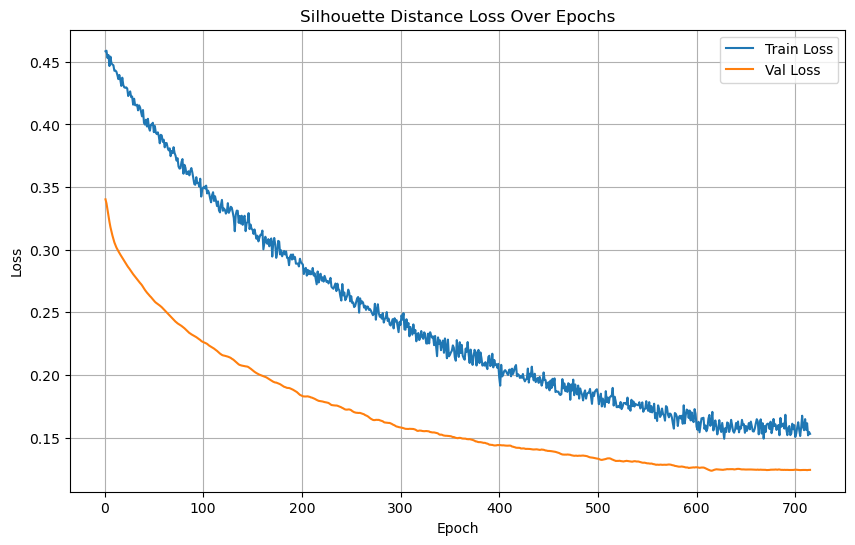

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/835], Loss: 0.0631


Test Batch [20/835], Loss: 0.0866
Test Batch [30/835], Loss: 0.0885
Test Batch [40/835], Loss: 0.5000
Test Batch [50/835], Loss: 0.5000
Test Batch [60/835], Loss: 0.1075
Test Batch [70/835], Loss: 0.0899
Test Batch [80/835], Loss: 0.1437


Test Batch [90/835], Loss: 0.0891
Test Batch [100/835], Loss: 0.1667
Test Batch [110/835], Loss: 0.0990
Test Batch [120/835], Loss: 0.0938
Test Batch [130/835], Loss: 0.1092
Test Batch [140/835], Loss: 0.1124
Test Batch [150/835], Loss: 0.1305


Test Batch [160/835], Loss: 0.0713
Test Batch [170/835], Loss: 0.1105
Test Batch [180/835], Loss: 0.1098
Test Batch [190/835], Loss: 0.0913


Test Batch [200/835], Loss: 0.0509
Test Batch [210/835], Loss: 0.0437
Test Batch [220/835], Loss: 0.0640
Test Batch [230/835], Loss: 0.0488
Test Batch [240/835], Loss: 0.0760


Test Batch [250/835], Loss: 0.0962
Test Batch [260/835], Loss: 0.1487
Test Batch [270/835], Loss: 0.1340
Test Batch [280/835], Loss: 0.0722


Test Batch [290/835], Loss: 0.1991
Test Batch [300/835], Loss: 0.1317
Test Batch [310/835], Loss: 0.1558
Test Batch [320/835], Loss: 0.1467
Test Batch [330/835], Loss: 0.1367
Test Batch [340/835], Loss: 0.5000


Test Batch [350/835], Loss: 0.5000
Test Batch [360/835], Loss: 0.5000
Test Batch [370/835], Loss: 0.5000
Test Batch [380/835], Loss: 0.5000
Test Batch [390/835], Loss: 0.5000
Test Batch [400/835], Loss: 0.5000
Test Batch [410/835], Loss: 0.5000
Test Batch [420/835], Loss: 0.1060
Test Batch [430/835], Loss: 0.0585
Test Batch [440/835], Loss: 0.0511


Test Batch [450/835], Loss: 0.1249
Test Batch [460/835], Loss: 0.0647
Test Batch [470/835], Loss: 0.0909
Test Batch [480/835], Loss: 0.5000
Test Batch [490/835], Loss: 0.5000
Test Batch [500/835], Loss: 0.0359
Test Batch [510/835], Loss: 0.0386


Test Batch [520/835], Loss: 0.0573
Test Batch [530/835], Loss: 0.0414
Test Batch [540/835], Loss: 0.0444
Test Batch [550/835], Loss: 0.0479
Test Batch [560/835], Loss: 0.0450


Test Batch [570/835], Loss: 0.0498
Test Batch [580/835], Loss: 0.1111
Test Batch [590/835], Loss: 0.0437
Test Batch [600/835], Loss: 0.0839
Test Batch [610/835], Loss: 0.5000
Test Batch [620/835], Loss: 0.1743


Test Batch [630/835], Loss: 0.5000
Test Batch [640/835], Loss: 0.1337
Test Batch [650/835], Loss: 0.0818
Test Batch [660/835], Loss: 0.0923


Test Batch [670/835], Loss: 0.3707
Test Batch [680/835], Loss: 0.1028
Test Batch [690/835], Loss: 0.0414
Test Batch [700/835], Loss: 0.5000
Test Batch [710/835], Loss: 0.1634


Test Batch [720/835], Loss: 0.2355
Test Batch [730/835], Loss: 0.2652
Test Batch [740/835], Loss: 0.5000
Test Batch [750/835], Loss: 0.0613
Test Batch [760/835], Loss: 0.1342


Test Batch [770/835], Loss: 0.2034
Test Batch [780/835], Loss: 0.5000
Test Batch [790/835], Loss: 0.1247
Test Batch [800/835], Loss: 0.1661
Test Batch [810/835], Loss: 0.5000
Test Batch [820/835], Loss: 0.0897
Test Batch [830/835], Loss: 0.5000

Test Loss: 0.1825


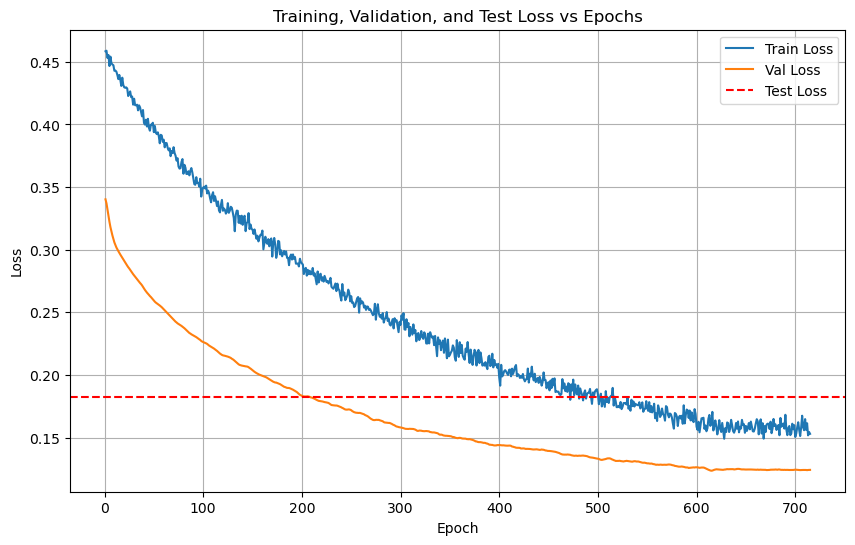

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/835 for test dataset.
  Processed batch 20/835 for test dataset.


  Processed batch 30/835 for test dataset.
  Processed batch 40/835 for test dataset.
  Processed batch 50/835 for test dataset.


  Processed batch 60/835 for test dataset.
  Processed batch 70/835 for test dataset.
  Processed batch 80/835 for test dataset.
  Processed batch 90/835 for test dataset.


  Processed batch 100/835 for test dataset.
  Processed batch 110/835 for test dataset.
  Processed batch 120/835 for test dataset.
  Processed batch 130/835 for test dataset.


  Processed batch 140/835 for test dataset.
  Processed batch 150/835 for test dataset.
  Processed batch 160/835 for test dataset.
  Processed batch 170/835 for test dataset.


  Processed batch 180/835 for test dataset.
  Processed batch 190/835 for test dataset.
  Processed batch 200/835 for test dataset.
  Processed batch 210/835 for test dataset.


  Processed batch 220/835 for test dataset.
  Processed batch 230/835 for test dataset.
  Processed batch 240/835 for test dataset.


  Processed batch 250/835 for test dataset.
  Processed batch 260/835 for test dataset.
  Processed batch 270/835 for test dataset.


  Processed batch 280/835 for test dataset.
  Processed batch 290/835 for test dataset.
  Processed batch 300/835 for test dataset.


  Processed batch 310/835 for test dataset.
  Processed batch 320/835 for test dataset.
  Processed batch 330/835 for test dataset.


  Processed batch 340/835 for test dataset.
  Processed batch 350/835 for test dataset.
  Processed batch 360/835 for test dataset.


  Processed batch 370/835 for test dataset.
  Processed batch 380/835 for test dataset.
  Processed batch 390/835 for test dataset.
  Processed batch 400/835 for test dataset.


  Processed batch 410/835 for test dataset.
  Processed batch 420/835 for test dataset.
  Processed batch 430/835 for test dataset.
  Processed batch 440/835 for test dataset.


  Processed batch 450/835 for test dataset.
  Processed batch 460/835 for test dataset.
  Processed batch 470/835 for test dataset.


  Processed batch 480/835 for test dataset.
  Processed batch 490/835 for test dataset.
  Processed batch 500/835 for test dataset.


  Processed batch 510/835 for test dataset.
  Processed batch 520/835 for test dataset.
  Processed batch 530/835 for test dataset.


  Processed batch 540/835 for test dataset.
  Processed batch 550/835 for test dataset.
  Processed batch 560/835 for test dataset.


  Processed batch 570/835 for test dataset.
  Processed batch 580/835 for test dataset.
  Processed batch 590/835 for test dataset.


  Processed batch 600/835 for test dataset.
  Processed batch 610/835 for test dataset.
  Processed batch 620/835 for test dataset.


  Processed batch 630/835 for test dataset.
  Processed batch 640/835 for test dataset.
  Processed batch 650/835 for test dataset.
  Processed batch 660/835 for test dataset.


  Processed batch 670/835 for test dataset.
  Processed batch 680/835 for test dataset.
  Processed batch 690/835 for test dataset.
  Processed batch 700/835 for test dataset.


  Processed batch 710/835 for test dataset.
  Processed batch 720/835 for test dataset.
  Processed batch 730/835 for test dataset.
  Processed batch 740/835 for test dataset.


  Processed batch 750/835 for test dataset.
  Processed batch 760/835 for test dataset.
  Processed batch 770/835 for test dataset.


  Processed batch 780/835 for test dataset.
  Processed batch 790/835 for test dataset.
  Processed batch 800/835 for test dataset.


  Processed batch 810/835 for test dataset.
  Processed batch 820/835 for test dataset.
  Processed batch 830/835 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.80      0.80      0.80         5
           9       1.00      0.80      0.89         5
          10       0.67      0.80      0.73         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9336  |  Val Loss: 2.8860
Validation loss improved from inf to 2.8860.
[Epoch 2/1000] Train Loss: 2.7911  |  Val Loss: 2.7546
Validation loss improved from 2.8860 to 2.7546.
[Epoch 3/1000] Train Loss: 2.6688  |  Val Loss: 2.6408
Validation loss improved from 2.7546 to 2.6408.
[Epoch 4/1000] Train Loss: 2.5614  |  Val Loss: 2.5417
Validation loss improved from 2.6408 to 2.5417.
[Epoch 5/1000] Train Loss: 2.4653  |  Val Loss: 2.4486
Validation loss improved from 2.5417 to 2.4486.
[Epoch 6/1000] Train Loss: 2.3788  |  Val Loss: 2.3661
Validation loss improved from 2.4486 to 2.3661.
[Epoch 7/1000] Train Loss: 2.2997  |  Val Loss: 2.2889
Validation loss improved from 2.3661 to 2.2889.


[Epoch 8/1000] Train Loss: 2.2226  |  Val Loss: 2.2141
Validation loss improved from 2.2889 to 2.2141.
[Epoch 9/1000] Train Loss: 2.1486  |  Val Loss: 2.1430
Validation loss improved from 2.2141 to 2.1430.
[Epoch 10/1000] Train Loss: 2.0774  |  Val Loss: 2.0713
Validation loss improved from 2.1430 to 2.0713.


[Epoch 11/1000] Train Loss: 2.0059  |  Val Loss: 1.9992
Validation loss improved from 2.0713 to 1.9992.
[Epoch 12/1000] Train Loss: 1.9355  |  Val Loss: 1.9316
Validation loss improved from 1.9992 to 1.9316.
[Epoch 13/1000] Train Loss: 1.8683  |  Val Loss: 1.8679
Validation loss improved from 1.9316 to 1.8679.
[Epoch 14/1000] Train Loss: 1.8043  |  Val Loss: 1.8073
Validation loss improved from 1.8679 to 1.8073.
[Epoch 15/1000] Train Loss: 1.7441  |  Val Loss: 1.7503
Validation loss improved from 1.8073 to 1.7503.
[Epoch 16/1000] Train Loss: 1.6861  |  Val Loss: 1.6961
Validation loss improved from 1.7503 to 1.6961.
[Epoch 17/1000] Train Loss: 1.6310  |  Val Loss: 1.6453
Validation loss improved from 1.6961 to 1.6453.


[Epoch 18/1000] Train Loss: 1.5801  |  Val Loss: 1.5983
Validation loss improved from 1.6453 to 1.5983.
[Epoch 19/1000] Train Loss: 1.5310  |  Val Loss: 1.5537
Validation loss improved from 1.5983 to 1.5537.
[Epoch 20/1000] Train Loss: 1.4838  |  Val Loss: 1.5111
Validation loss improved from 1.5537 to 1.5111.
[Epoch 21/1000] Train Loss: 1.4379  |  Val Loss: 1.4694
Validation loss improved from 1.5111 to 1.4694.
[Epoch 22/1000] Train Loss: 1.3924  |  Val Loss: 1.4299
Validation loss improved from 1.4694 to 1.4299.


[Epoch 23/1000] Train Loss: 1.3479  |  Val Loss: 1.3914
Validation loss improved from 1.4299 to 1.3914.
[Epoch 24/1000] Train Loss: 1.3036  |  Val Loss: 1.3558
Validation loss improved from 1.3914 to 1.3558.
[Epoch 25/1000] Train Loss: 1.2612  |  Val Loss: 1.3239
Validation loss improved from 1.3558 to 1.3239.
[Epoch 26/1000] Train Loss: 1.2185  |  Val Loss: 1.2914
Validation loss improved from 1.3239 to 1.2914.
[Epoch 27/1000] Train Loss: 1.1760  |  Val Loss: 1.2585
Validation loss improved from 1.2914 to 1.2585.
[Epoch 28/1000] Train Loss: 1.1344  |  Val Loss: 1.2271
Validation loss improved from 1.2585 to 1.2271.


[Epoch 29/1000] Train Loss: 1.0930  |  Val Loss: 1.1959
Validation loss improved from 1.2271 to 1.1959.
[Epoch 30/1000] Train Loss: 1.0535  |  Val Loss: 1.1666
Validation loss improved from 1.1959 to 1.1666.
[Epoch 31/1000] Train Loss: 1.0148  |  Val Loss: 1.1376
Validation loss improved from 1.1666 to 1.1376.
[Epoch 32/1000] Train Loss: 0.9786  |  Val Loss: 1.1090
Validation loss improved from 1.1376 to 1.1090.
[Epoch 33/1000] Train Loss: 0.9437  |  Val Loss: 1.0833
Validation loss improved from 1.1090 to 1.0833.


[Epoch 34/1000] Train Loss: 0.9107  |  Val Loss: 1.0594
Validation loss improved from 1.0833 to 1.0594.
[Epoch 35/1000] Train Loss: 0.8789  |  Val Loss: 1.0361
Validation loss improved from 1.0594 to 1.0361.
[Epoch 36/1000] Train Loss: 0.8479  |  Val Loss: 1.0158
Validation loss improved from 1.0361 to 1.0158.
[Epoch 37/1000] Train Loss: 0.8184  |  Val Loss: 0.9953
Validation loss improved from 1.0158 to 0.9953.
[Epoch 38/1000] Train Loss: 0.7897  |  Val Loss: 0.9759
Validation loss improved from 0.9953 to 0.9759.


[Epoch 39/1000] Train Loss: 0.7618  |  Val Loss: 0.9580
Validation loss improved from 0.9759 to 0.9580.
[Epoch 40/1000] Train Loss: 0.7346  |  Val Loss: 0.9412
Validation loss improved from 0.9580 to 0.9412.
[Epoch 41/1000] Train Loss: 0.7091  |  Val Loss: 0.9236
Validation loss improved from 0.9412 to 0.9236.
[Epoch 42/1000] Train Loss: 0.6838  |  Val Loss: 0.9090
Validation loss improved from 0.9236 to 0.9090.
[Epoch 43/1000] Train Loss: 0.6600  |  Val Loss: 0.8951
Validation loss improved from 0.9090 to 0.8951.
[Epoch 44/1000] Train Loss: 0.6360  |  Val Loss: 0.8806
Validation loss improved from 0.8951 to 0.8806.


[Epoch 45/1000] Train Loss: 0.6132  |  Val Loss: 0.8654
Validation loss improved from 0.8806 to 0.8654.
[Epoch 46/1000] Train Loss: 0.5915  |  Val Loss: 0.8524
Validation loss improved from 0.8654 to 0.8524.
[Epoch 47/1000] Train Loss: 0.5693  |  Val Loss: 0.8418
Validation loss improved from 0.8524 to 0.8418.
[Epoch 48/1000] Train Loss: 0.5493  |  Val Loss: 0.8300
Validation loss improved from 0.8418 to 0.8300.


[Epoch 49/1000] Train Loss: 0.5294  |  Val Loss: 0.8196
Validation loss improved from 0.8300 to 0.8196.
[Epoch 50/1000] Train Loss: 0.5103  |  Val Loss: 0.8091
Validation loss improved from 0.8196 to 0.8091.
[Epoch 51/1000] Train Loss: 0.4918  |  Val Loss: 0.8003
Validation loss improved from 0.8091 to 0.8003.
[Epoch 52/1000] Train Loss: 0.4735  |  Val Loss: 0.7914
Validation loss improved from 0.8003 to 0.7914.
[Epoch 53/1000] Train Loss: 0.4559  |  Val Loss: 0.7835
Validation loss improved from 0.7914 to 0.7835.
[Epoch 54/1000] Train Loss: 0.4394  |  Val Loss: 0.7748
Validation loss improved from 0.7835 to 0.7748.


[Epoch 55/1000] Train Loss: 0.4231  |  Val Loss: 0.7661
Validation loss improved from 0.7748 to 0.7661.
[Epoch 56/1000] Train Loss: 0.4073  |  Val Loss: 0.7601
Validation loss improved from 0.7661 to 0.7601.
[Epoch 57/1000] Train Loss: 0.3917  |  Val Loss: 0.7554
Validation loss improved from 0.7601 to 0.7554.
[Epoch 58/1000] Train Loss: 0.3773  |  Val Loss: 0.7511
Validation loss improved from 0.7554 to 0.7511.
[Epoch 59/1000] Train Loss: 0.3635  |  Val Loss: 0.7452
Validation loss improved from 0.7511 to 0.7452.
[Epoch 60/1000] Train Loss: 0.3498  |  Val Loss: 0.7443
Validation loss improved from 0.7452 to 0.7443.


[Epoch 61/1000] Train Loss: 0.3369  |  Val Loss: 0.7417
Validation loss improved from 0.7443 to 0.7417.
[Epoch 62/1000] Train Loss: 0.3250  |  Val Loss: 0.7392
Validation loss improved from 0.7417 to 0.7392.
[Epoch 63/1000] Train Loss: 0.3133  |  Val Loss: 0.7377
Validation loss improved from 0.7392 to 0.7377.
[Epoch 64/1000] Train Loss: 0.3020  |  Val Loss: 0.7375
Validation loss improved from 0.7377 to 0.7375.


[Epoch 65/1000] Train Loss: 0.2917  |  Val Loss: 0.7372
Validation loss improved from 0.7375 to 0.7372.
[Epoch 66/1000] Train Loss: 0.2815  |  Val Loss: 0.7362
Validation loss improved from 0.7372 to 0.7362.
[Epoch 67/1000] Train Loss: 0.2717  |  Val Loss: 0.7366
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.2627  |  Val Loss: 0.7370
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.2537  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 70/1000] Train Loss: 0.2450  |  Val Loss: 0.7391
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 71/1000] Train Loss: 0.2370  |  Val Loss: 0.7406
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 72/1000] Train Loss: 0.2292  |  Val Loss: 0.7421
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 73/1000] Train Loss: 0.2212  |  Val Loss: 0.7438
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 74/1000] Train Loss: 0.2141  |  Val Loss: 0.7447
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 75/1000] Train Loss: 0.2068  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 76/1000] Train Loss: 0.2003  |  Val Loss: 0.7505
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 77/1000] Train Loss: 0.1947  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 78/1000] Train Loss: 0.1883  |  Val Loss: 0.7586
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 79/1000] Train Loss: 0.1832  |  Val Loss: 0.7607
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 80/1000] Train Loss: 0.1779  |  Val Loss: 0.7650
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 81/1000] Train Loss: 0.1728  |  Val Loss: 0.7701
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 82/1000] Train Loss: 0.1686  |  Val Loss: 0.7731
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 83/1000] Train Loss: 0.1636  |  Val Loss: 0.7780
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 84/1000] Train Loss: 0.1599  |  Val Loss: 0.7840
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 85/1000] Train Loss: 0.1553  |  Val Loss: 0.7881
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 86/1000] Train Loss: 0.1512  |  Val Loss: 0.7917
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 87/1000] Train Loss: 0.1475  |  Val Loss: 0.7973
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 88/1000] Train Loss: 0.1439  |  Val Loss: 0.8016
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 89/1000] Train Loss: 0.1405  |  Val Loss: 0.8063
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 90/1000] Train Loss: 0.1373  |  Val Loss: 0.8108
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 91/1000] Train Loss: 0.1342  |  Val Loss: 0.8166
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 92/1000] Train Loss: 0.1311  |  Val Loss: 0.8209
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 93/1000] Train Loss: 0.1282  |  Val Loss: 0.8261
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 94/1000] Train Loss: 0.1253  |  Val Loss: 0.8304
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 95/1000] Train Loss: 0.1230  |  Val Loss: 0.8363
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 96/1000] Train Loss: 0.1203  |  Val Loss: 0.8413
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 97/1000] Train Loss: 0.1178  |  Val Loss: 0.8453
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 98/1000] Train Loss: 0.1152  |  Val Loss: 0.8506
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 99/1000] Train Loss: 0.1135  |  Val Loss: 0.8555
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 100/1000] Train Loss: 0.1109  |  Val Loss: 0.8615
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 101/1000] Train Loss: 0.1089  |  Val Loss: 0.8664
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 102/1000] Train Loss: 0.1069  |  Val Loss: 0.8723
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 103/1000] Train Loss: 0.1047  |  Val Loss: 0.8756
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 104/1000] Train Loss: 0.1032  |  Val Loss: 0.8815
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 105/1000] Train Loss: 0.1009  |  Val Loss: 0.8858
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 106/1000] Train Loss: 0.0993  |  Val Loss: 0.8920
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 107/1000] Train Loss: 0.0974  |  Val Loss: 0.8955
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 108/1000] Train Loss: 0.0958  |  Val Loss: 0.9005
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 109/1000] Train Loss: 0.0943  |  Val Loss: 0.9060
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 110/1000] Train Loss: 0.0924  |  Val Loss: 0.9131
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 111/1000] Train Loss: 0.0912  |  Val Loss: 0.9176
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 112/1000] Train Loss: 0.0895  |  Val Loss: 0.9217
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 113/1000] Train Loss: 0.0884  |  Val Loss: 0.9246
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 114/1000] Train Loss: 0.0867  |  Val Loss: 0.9316
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 115/1000] Train Loss: 0.0854  |  Val Loss: 0.9363
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 116/1000] Train Loss: 0.0847  |  Val Loss: 0.9410
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 117/1000] Train Loss: 0.0831  |  Val Loss: 0.9462
!! Validation loss did NOT improve !! Patience: 51/100


[Epoch 118/1000] Train Loss: 0.0816  |  Val Loss: 0.9503
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 119/1000] Train Loss: 0.0804  |  Val Loss: 0.9552
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 120/1000] Train Loss: 0.0794  |  Val Loss: 0.9609
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 121/1000] Train Loss: 0.0783  |  Val Loss: 0.9655
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 122/1000] Train Loss: 0.0770  |  Val Loss: 0.9714
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 123/1000] Train Loss: 0.0760  |  Val Loss: 0.9778
!! Validation loss did NOT improve !! Patience: 57/100


[Epoch 124/1000] Train Loss: 0.0749  |  Val Loss: 0.9837
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 125/1000] Train Loss: 0.0740  |  Val Loss: 0.9914
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 126/1000] Train Loss: 0.0733  |  Val Loss: 0.9949
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 127/1000] Train Loss: 0.0720  |  Val Loss: 1.0009
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 128/1000] Train Loss: 0.0712  |  Val Loss: 1.0067
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 129/1000] Train Loss: 0.0704  |  Val Loss: 1.0131
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 130/1000] Train Loss: 0.0693  |  Val Loss: 1.0164
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 131/1000] Train Loss: 0.0685  |  Val Loss: 1.0220
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 132/1000] Train Loss: 0.0678  |  Val Loss: 1.0269
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 133/1000] Train Loss: 0.0669  |  Val Loss: 1.0344
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 134/1000] Train Loss: 0.0661  |  Val Loss: 1.0403
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 135/1000] Train Loss: 0.0653  |  Val Loss: 1.0453
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 136/1000] Train Loss: 0.0648  |  Val Loss: 1.0500
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 137/1000] Train Loss: 0.0637  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 138/1000] Train Loss: 0.0633  |  Val Loss: 1.0571
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 139/1000] Train Loss: 0.0626  |  Val Loss: 1.0614
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 140/1000] Train Loss: 0.0618  |  Val Loss: 1.0660
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 141/1000] Train Loss: 0.0610  |  Val Loss: 1.0713
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 142/1000] Train Loss: 0.0605  |  Val Loss: 1.0761
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 143/1000] Train Loss: 0.0599  |  Val Loss: 1.0796
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 144/1000] Train Loss: 0.0592  |  Val Loss: 1.0848
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 145/1000] Train Loss: 0.0586  |  Val Loss: 1.0896
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 146/1000] Train Loss: 0.0582  |  Val Loss: 1.0940
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 147/1000] Train Loss: 0.0577  |  Val Loss: 1.0974
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 148/1000] Train Loss: 0.0570  |  Val Loss: 1.1028
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 149/1000] Train Loss: 0.0565  |  Val Loss: 1.1058
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 150/1000] Train Loss: 0.0559  |  Val Loss: 1.1108
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 151/1000] Train Loss: 0.0556  |  Val Loss: 1.1153
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 152/1000] Train Loss: 0.0549  |  Val Loss: 1.1199
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 153/1000] Train Loss: 0.0545  |  Val Loss: 1.1244
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 154/1000] Train Loss: 0.0539  |  Val Loss: 1.1274
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 155/1000] Train Loss: 0.0535  |  Val Loss: 1.1328
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 156/1000] Train Loss: 0.0530  |  Val Loss: 1.1366
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 157/1000] Train Loss: 0.0524  |  Val Loss: 1.1406
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 158/1000] Train Loss: 0.0520  |  Val Loss: 1.1467
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 159/1000] Train Loss: 0.0515  |  Val Loss: 1.1506
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 160/1000] Train Loss: 0.0511  |  Val Loss: 1.1564
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 161/1000] Train Loss: 0.0509  |  Val Loss: 1.1600
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 162/1000] Train Loss: 0.0502  |  Val Loss: 1.1621
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 163/1000] Train Loss: 0.0499  |  Val Loss: 1.1665
!! Validation loss did NOT improve !! Patience: 97/100


[Epoch 164/1000] Train Loss: 0.0494  |  Val Loss: 1.1711
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 165/1000] Train Loss: 0.0490  |  Val Loss: 1.1744
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 166/1000] Train Loss: 0.0489  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 166 !!
No improvement for 100 epochs.


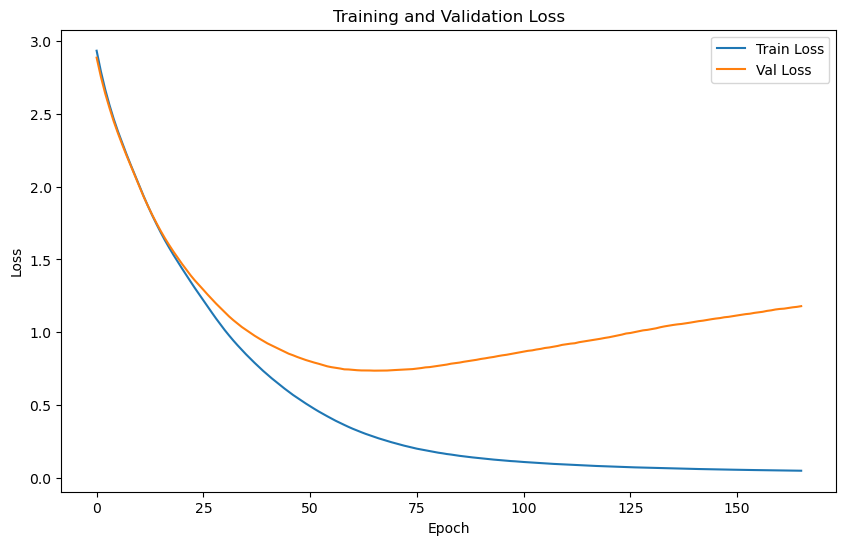

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.5855 | Test Accuracy: 86.93%


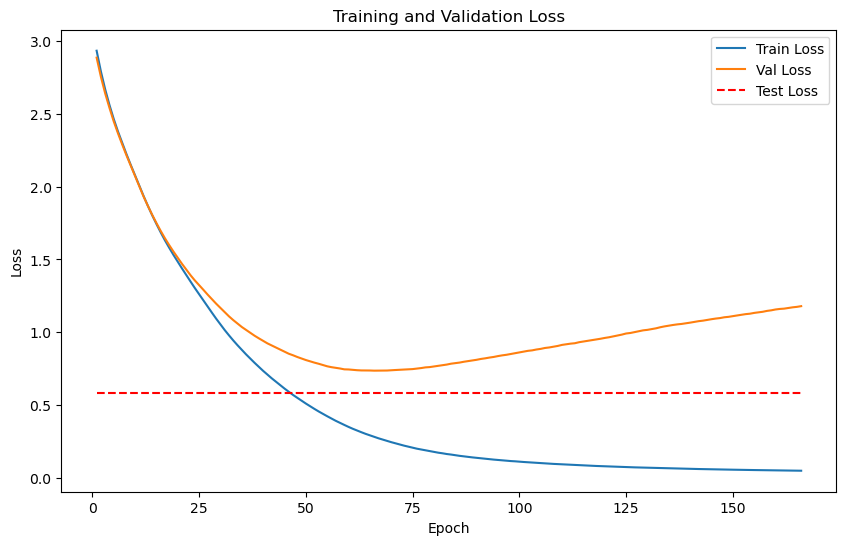

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


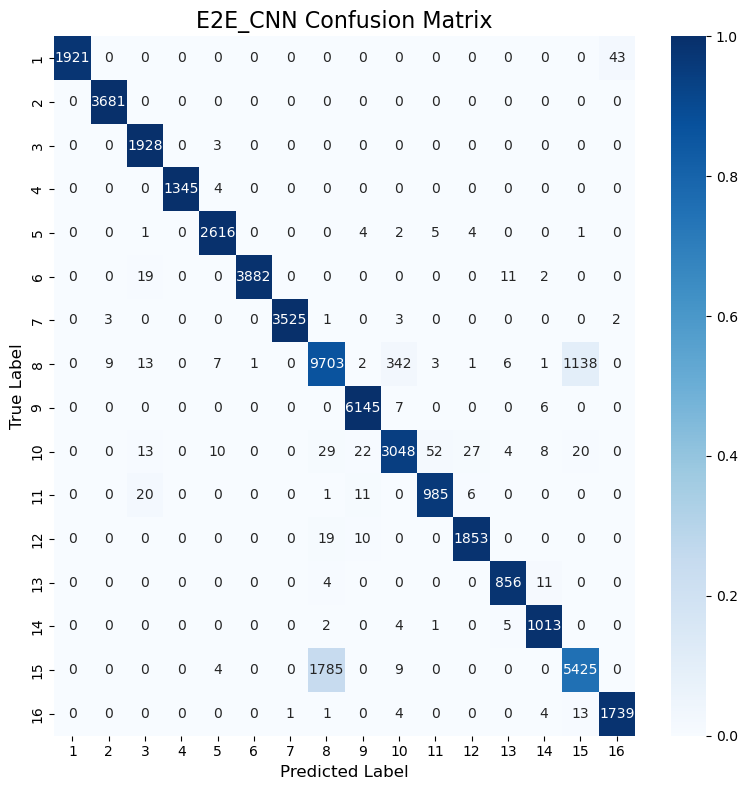

Classification Accuracy: 92.99%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


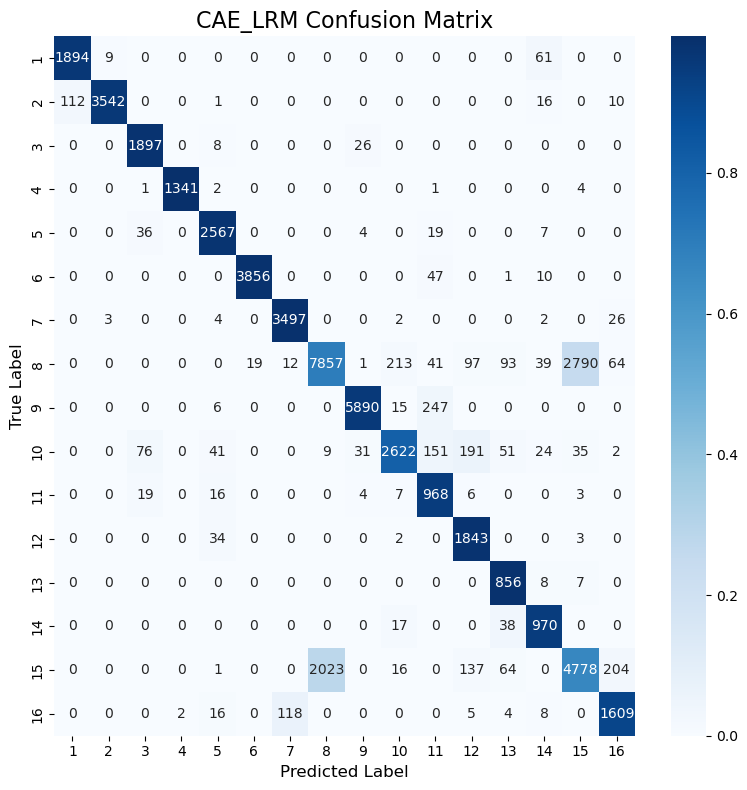

Classification Accuracy: 86.10%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


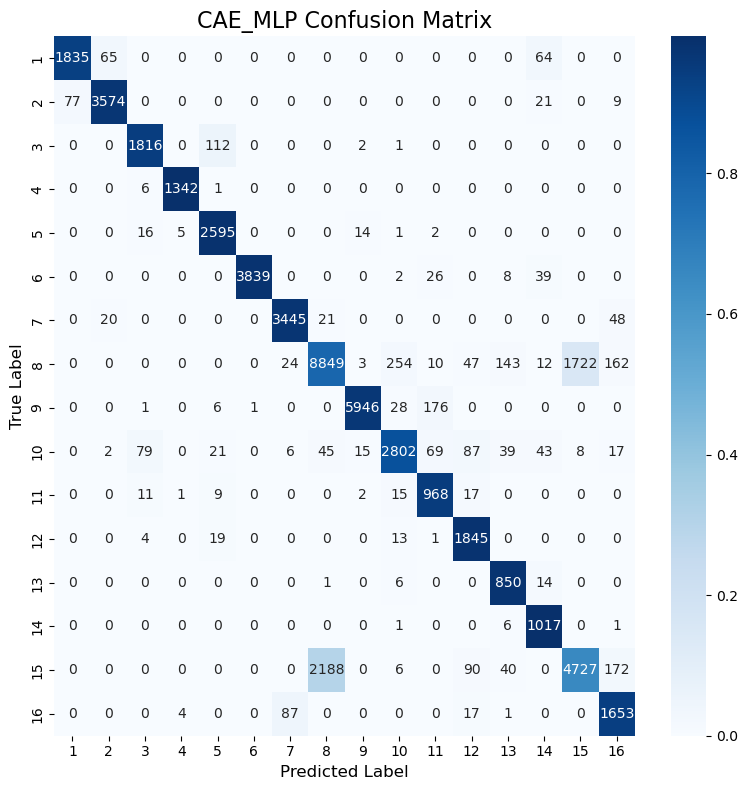

Classification Accuracy: 88.19%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


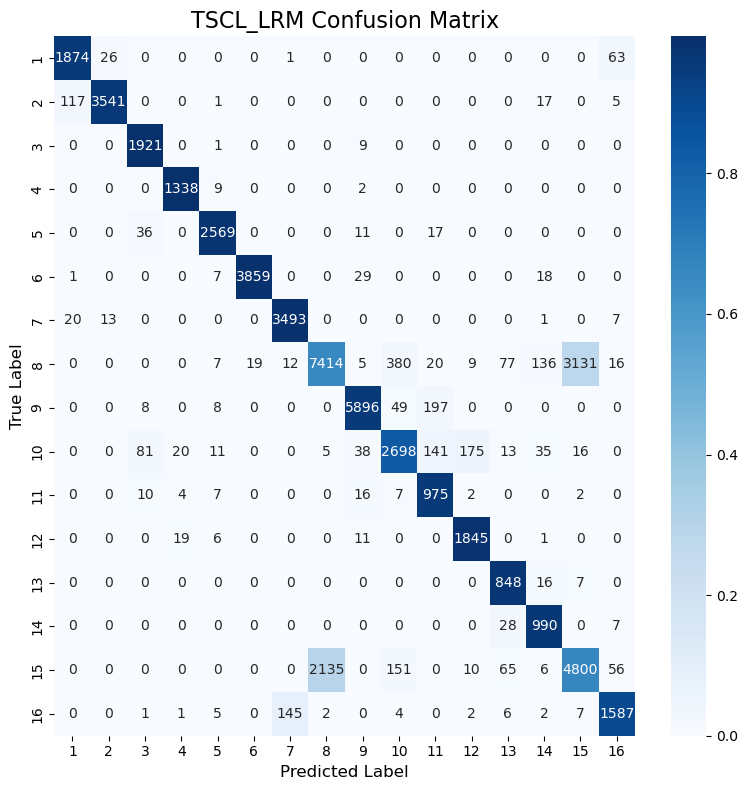

Classification Accuracy: 85.47%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


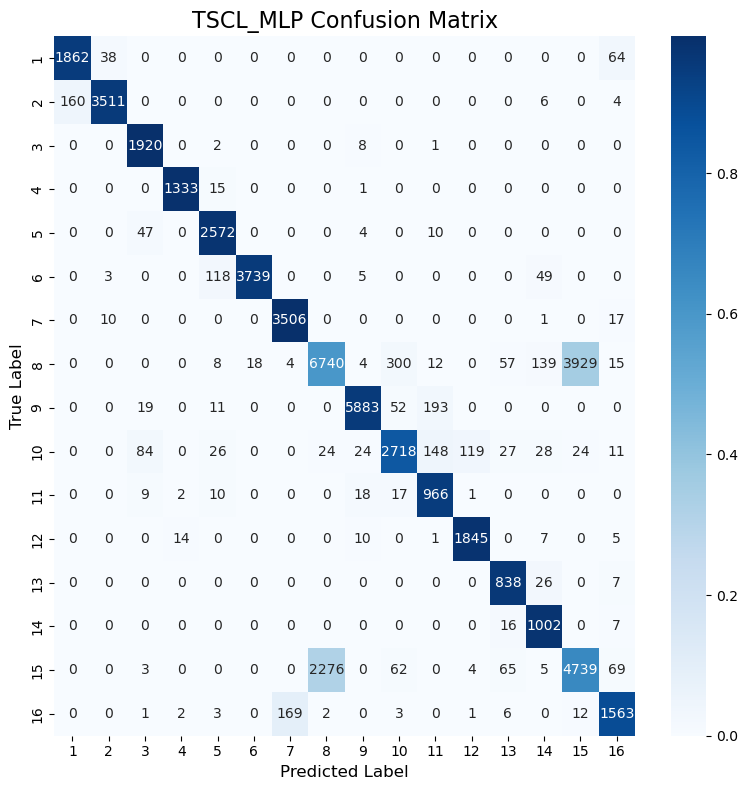

Classification Accuracy: 83.76%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


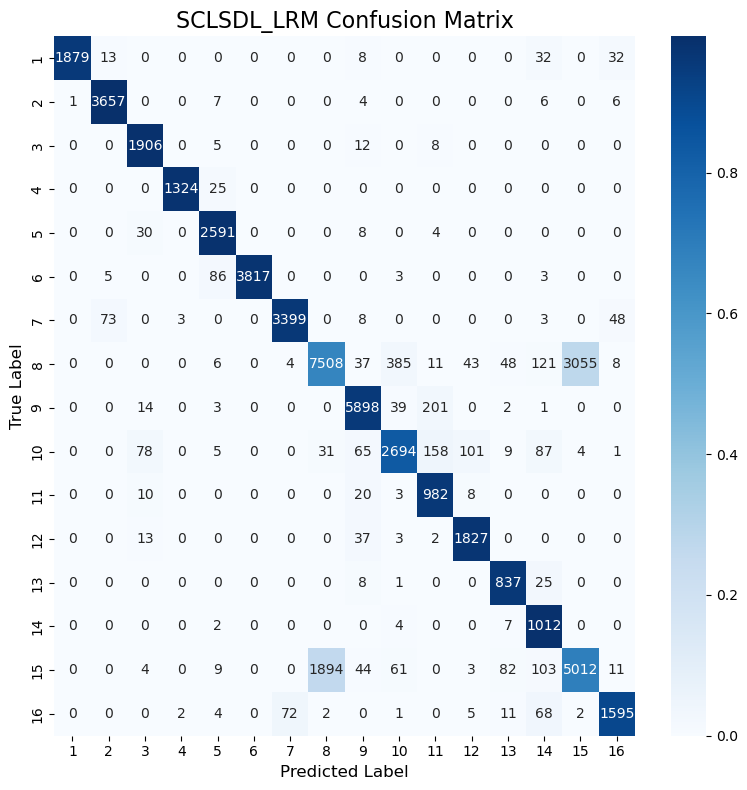

Classification Accuracy: 86.01%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


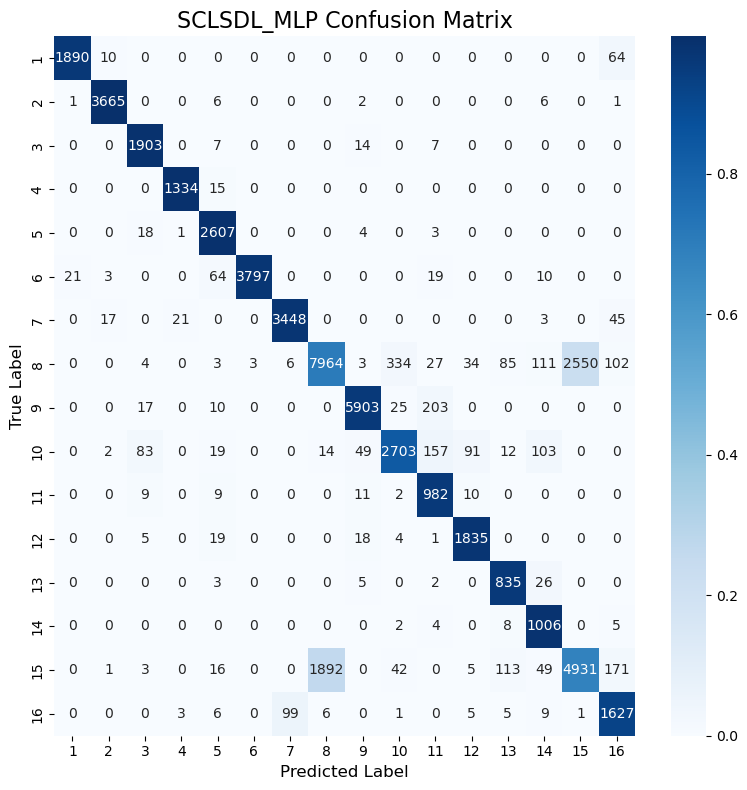

Classification Accuracy: 86.93%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          92.99
1    LRM (CAE)          86.10
2    MLP (CAE)          88.19
3     TSCL LRM          85.47
4     TSCL MLP          83.76
5  SCL_SDL LRM          86.01
6  SCL_SDL MLP          86.93

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          92.99
2    MLP (CAE)          88.19
6  SCL_SDL MLP          86.93
1    LRM (CAE)          86.10
5  SCL_SDL LRM          86.01
3     TSCL LRM          85.47
4     TSCL MLP          83.76
